In [1]:
import centralized as CP
import davisyin as DY
import admm as admm
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
from numpy.linalg import inv
import matplotlib as plt
from matplotlib import rc
# Configura el tipo de letra globalmente
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import proyecciones as pro
import time
import briceno as BA
import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [2]:
# Caso 1: Caso base
    
# Cambiar criterio de parada por errores relativos.
# Establecer la semilla
seed = 40
#41
np.random.seed(seed)

# Seteamos los parámetros:
N, M = 3, 5  # Son 2 tecnologías, 10 escenarios

# Probabilidades:
inv_, mc_, voll_, d_ = [50.0,  1000.0, 10000.0, 1000.0]
                       #[10.0, 2000.0, 10000.0, 1000.0]
                       #[50.0,  1000.0, 10000.0, 1000.0]
#Sigma = np.ones((1,M))
Sigma = np.random.rand(1,M)
Sigma /= Sigma.sum()
Sigma

array([[0.20, 0.03, 0.40, 0.14, 0.23]])

In [3]:
Times = {}
r_ = 1


# Parámetros funciones:
I    = inv_ * np.ones((N, 1)) + r_*np.array([[-45], [0], [45]])
print("I\n",I)
aux  = np.array([1 + r_*20*i for i in range(N)])

mc_11 = 100
mc_22 = 500
mc_33 = 1000
MC   = np.array([np.diag(mc_*aux + r_*np.array([((-1)**m)*mc_11*m, ((-1)**m)*mc_22*m, ((-1)**(m+1))*mc_33*m])) for m in range(M)])
print("MC\n",MC)
VOLL = voll_
print("VOLL\n",VOLL)
D    = d_*np.ones((1,M)) + r_*np.array([-800, -250, 0, 250, 500])[np.newaxis]
print("D\n",D)

e_ = 0

e1  = e_
e2  = e_
e31 = e_*1e2/2
e32 = e_

Q1, B1 = np.zeros((N,N)), I
Q2, B2 = 0.01*MC, np.zeros((N,M))
Q3, B3 = np.zeros((1,M)), VOLL*np.ones((1,M))


frobenius_norm = (e1+e2)*np.sqrt(N)+e31+e32+np.array([LA.norm(np.einsum('i,ikl->ikl',Sigma[0],0.01*MC)[xi], 'fro') for xi in range(M)]).sum()
#frobenius_norm = max([e1*np.sqrt(N),e31+e32,e2*np.sqrt(N)+np.array([LA.norm(np.einsum('i,ikl->ikl',Sigma[0],0.01*MC)[xi], 'fro') for xi in range(M)]).sum()])
print("frobenius_norm:",frobenius_norm)

def Grad_Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, e1 = e1, N = N):
       return np.dot(Q_1,x1)+B_1# - e1*np.dot(np.identity(N),np.maximum(-x1,0))


def Grad_Phi_2(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), e2 = e2, N = N, M = M):

    return np.einsum('ijk,ki->ji', Q_2, x2)+B_2# - e2*np.einsum('ijk,ki->ji', np.array([np.diag(np.ones(N)) for m in range(M)]), np.maximum(-x2,0))


def Grad_Phi_3(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), D=D, e31=e31, e32= e32, M = M):
    return Q_3*x3+B_3 #- e31*np.dot(np.maximum(-x3,0),np.identity(M)) - e32*np.dot(np.maximum(-D+x3,0),np.identity(M))


def Grad_Phi(x1,x2,x3, P = Sigma):
    return Grad_Phi_1(x1), P*Grad_Phi_2(x2), P*Grad_Phi_3(x3)

def Grad_Phi_NA(x1,x2,x3, P = Sigma):
    return P*Grad_Phi_1(x1), P*Grad_Phi_2(x2), P*Grad_Phi_3(x3)

def Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, C_1 = 0.0, e1 = e1):
    return 0.5*np.einsum('ij,ji -> i', x1.T,np.dot(Q_1,x1))[:,np.newaxis]+np.dot(x1.T, B_1)+C_1 + e1/2*LA.norm(np.maximum(-x1.flatten(),0))**2

def Phi_2_xi(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), C_2 = np.zeros((M, 1))):
    return 0.5*np.einsum('ij,ji -> i', x2.T, np.einsum('ijk,ki -> ji', Q_2, x2))[:,np.newaxis]+np.einsum('ij,ji->i',x2.T,B_2)[:,np.newaxis]+C_2 + e2/2*LA.norm(np.maximum(-x2.flatten(),0))**2

def Phi_3_xi(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), C_3 = -VOLL*D ):
    return (0.5*x3*Q_3*x3+B_3*x3+C_3).T + e31/2*LA.norm(np.maximum(-x3.flatten(),0))**2 + e32/2*LA.norm(np.maximum((D-x3).flatten(),0))**2


def objective_function(x1, x2, x3, P = Sigma, NA = True):

# NA = True, cumple la funcion que si se impuso 
#      la condición de no anticipatividad para x1
#      entonces, Phi_1(x1).shape == (M,1)
    if NA:
        return np.dot(P, Phi_1(x1) +Phi_2_xi(x2)+Phi_3_xi(x3))
    else:
        return Phi_1(x1)+ np.dot(P, Phi_2_xi(x2)+Phi_3_xi(x3))

I
 [[5.00]
 [50.00]
 [95.00]]
MC
 [[[1000.00 0.00 0.00]
  [0.00 21000.00 0.00]
  [0.00 0.00 41000.00]]

 [[900.00 0.00 0.00]
  [0.00 20500.00 0.00]
  [0.00 0.00 42000.00]]

 [[1200.00 0.00 0.00]
  [0.00 22000.00 0.00]
  [0.00 0.00 39000.00]]

 [[700.00 0.00 0.00]
  [0.00 19500.00 0.00]
  [0.00 0.00 44000.00]]

 [[1400.00 0.00 0.00]
  [0.00 23000.00 0.00]
  [0.00 0.00 37000.00]]]
VOLL
 10000.0
D
 [[200.00 750.00 1000.00 1250.00 1500.00]]
frobenius_norm: 453.2003170270881


In [4]:
cp = time.time()
x1, x2, x3, rho, mu = map(np.array, CP.modelo(Sigma, N, M, \
                                              parametros = [I.T[0].tolist(),\
                                                            np.array([mc_*aux + r_*np.array([((-1)**m)*mc_11*m, ((-1)**m)*mc_22*m, ((-1)**(m+1))*mc_33*m]) for m in range(M)]).T.tolist(),\
                                                            VOLL,\
                                                            D[0]] , show = 0))
fin = time.time()


Times["CP"] = fin - cp

x1 = x1[:,np.newaxis]
x2 = x2.T
x3 = x3[np.newaxis,:][0]
rho = rho[np.newaxis]

In [5]:
print(f"primal:\n{x1}\n{x2}\n{x3}")
print(f"Dual:\n{mu}\n{rho}")

primal:
[[1188.19]
 [44.88]
 [25.89]]
[[186.57 704.01 833.33 1188.19 714.29]
 [8.88 30.91 44.88 42.83 43.48]
 [4.55 15.09 25.64 18.98 25.89]]
[[0.00 0.00 96.14 0.00 716.34]]
Dual:
[[0.00 0.00 0.00 34.62 0.00]
 [0.00 0.00 126.14 0.00 0.00]
 [0.00 0.00 0.00 0.00 419.62]]
[[1865.66 6336.06 10000.00 8351.93 10000.00]]


In [6]:
# DY
    
dy = time.time()
DY_list, DY_f_list, DY_z_list, Dual_DY_list, iterations_DY   = DY.Davis_Yin(N, M, frobenius_norm, Grad_Phi, D, (x1,x2,x3), Sigma)
fin = time.time()

Times["DY"] = fin - dy

Beta: 0.0022065297892106934
Gamma: 0.003952278108170807
Lambda_k: 1
Iteration: 1 lambda_k: 1 Loss: 0.935093944351969
Iteration: 2 lambda_k: 1 Loss: 0.8317539385093687
Iteration: 3 lambda_k: 1 Loss: 0.7899579480348987
Iteration: 4 lambda_k: 1 Loss: 0.7974379801062146
Iteration: 5 lambda_k: 1 Loss: 0.7868074424584822
Iteration: 6 lambda_k: 1 Loss: 0.7760271808846004
Iteration: 7 lambda_k: 1 Loss: 0.7688170970944757
Iteration: 8 lambda_k: 1 Loss: 0.7635700245610965
Iteration: 9 lambda_k: 1 Loss: 0.7596371567303392
Iteration: 10 lambda_k: 1 Loss: 0.7561239269847461
Iteration: 11 lambda_k: 1 Loss: 0.7527380760804242
Iteration: 12 lambda_k: 1 Loss: 0.7494596449563052
Iteration: 13 lambda_k: 1 Loss: 0.7462678061064898
Iteration: 14 lambda_k: 1 Loss: 0.7431467854172109
Iteration: 15 lambda_k: 1 Loss: 0.740088874976767
Iteration: 16 lambda_k: 1 Loss: 0.7371056457308612
Iteration: 17 lambda_k: 1 Loss: 0.734195260356565
Iteration: 18 lambda_k: 1 Loss: 0.7313117269057752
Iteration: 19 lambda_k: 1 

Iteration: 160 lambda_k: 1 Loss: 0.48998552444575394
Iteration: 161 lambda_k: 1 Loss: 0.48876456456191836
Iteration: 162 lambda_k: 1 Loss: 0.4875484027254454
Iteration: 163 lambda_k: 1 Loss: 0.48633701784203065
Iteration: 164 lambda_k: 1 Loss: 0.4851303889238207
Iteration: 165 lambda_k: 1 Loss: 0.4839284950886486
Iteration: 166 lambda_k: 1 Loss: 0.48273131555928683
Iteration: 167 lambda_k: 1 Loss: 0.4815388296627205
Iteration: 168 lambda_k: 1 Loss: 0.48035101683125014
Iteration: 169 lambda_k: 1 Loss: 0.4791678565952989
Iteration: 170 lambda_k: 1 Loss: 0.47798932859094445
Iteration: 171 lambda_k: 1 Loss: 0.47681541255536136
Iteration: 172 lambda_k: 1 Loss: 0.4756460883263321
Iteration: 173 lambda_k: 1 Loss: 0.47448133584165925
Iteration: 174 lambda_k: 1 Loss: 0.4733211351386697
Iteration: 175 lambda_k: 1 Loss: 0.47216546635362333
Iteration: 176 lambda_k: 1 Loss: 0.4710143097210927
Iteration: 177 lambda_k: 1 Loss: 0.4698676455733522
Iteration: 178 lambda_k: 1 Loss: 0.46872545433978824
It

Iteration: 317 lambda_k: 1 Loss: 0.3458923875976249
Iteration: 318 lambda_k: 1 Loss: 0.34522107194197205
Iteration: 319 lambda_k: 1 Loss: 0.34455223639362215
Iteration: 320 lambda_k: 1 Loss: 0.3438858711071251
Iteration: 321 lambda_k: 1 Loss: 0.34322196628424334
Iteration: 322 lambda_k: 1 Loss: 0.342560512173724
Iteration: 323 lambda_k: 1 Loss: 0.3419014990710723
Iteration: 324 lambda_k: 1 Loss: 0.3412449173183258
Iteration: 325 lambda_k: 1 Loss: 0.3405907573038293
Iteration: 326 lambda_k: 1 Loss: 0.3399390094620121
Iteration: 327 lambda_k: 1 Loss: 0.3392896642731648
Iteration: 328 lambda_k: 1 Loss: 0.33864271226321824
Iteration: 329 lambda_k: 1 Loss: 0.33799814400352324
Iteration: 330 lambda_k: 1 Loss: 0.33735595011063074
Iteration: 331 lambda_k: 1 Loss: 0.3367161212460745
Iteration: 332 lambda_k: 1 Loss: 0.33607864811615284
Iteration: 333 lambda_k: 1 Loss: 0.33544352147171347
Iteration: 334 lambda_k: 1 Loss: 0.33481073210793755
Iteration: 335 lambda_k: 1 Loss: 0.33418027086412605
Ite

Iteration: 474 lambda_k: 1 Loss: 0.2656366166819535
Iteration: 475 lambda_k: 1 Loss: 0.26525914845440307
Iteration: 476 lambda_k: 1 Loss: 0.26488307143181533
Iteration: 477 lambda_k: 1 Loss: 0.26450838096224283
Iteration: 478 lambda_k: 1 Loss: 0.2641350724155803
Iteration: 479 lambda_k: 1 Loss: 0.26376314118345456
Iteration: 480 lambda_k: 1 Loss: 0.26339258268112636
Iteration: 481 lambda_k: 1 Loss: 0.2630233923391791
Iteration: 482 lambda_k: 1 Loss: 0.26265556561595277
Iteration: 483 lambda_k: 1 Loss: 0.26228909798886496
Iteration: 484 lambda_k: 1 Loss: 0.26192398495657926
Iteration: 485 lambda_k: 1 Loss: 0.26156022203885004
Iteration: 486 lambda_k: 1 Loss: 0.2611978047762934
Iteration: 487 lambda_k: 1 Loss: 0.26083672873062247
Iteration: 488 lambda_k: 1 Loss: 0.2604769894842208
Iteration: 489 lambda_k: 1 Loss: 0.2601185826400823
Iteration: 490 lambda_k: 1 Loss: 0.2597615038217776
Iteration: 491 lambda_k: 1 Loss: 0.259405748673335
Iteration: 492 lambda_k: 1 Loss: 0.25905131285913463
It

Iteration: 630 lambda_k: 1 Loss: 0.22065124703452071
Iteration: 631 lambda_k: 1 Loss: 0.2204314485075592
Iteration: 632 lambda_k: 1 Loss: 0.22021321453166443
Iteration: 633 lambda_k: 1 Loss: 0.21999636333032302
Iteration: 634 lambda_k: 1 Loss: 0.21978084774476214
Iteration: 635 lambda_k: 1 Loss: 0.21956645602062524
Iteration: 636 lambda_k: 1 Loss: 0.21935280043749233
Iteration: 637 lambda_k: 1 Loss: 0.21913973571913867
Iteration: 638 lambda_k: 1 Loss: 0.21892716436198992
Iteration: 639 lambda_k: 1 Loss: 0.2187150397958738
Iteration: 640 lambda_k: 1 Loss: 0.2185033414162025
Iteration: 641 lambda_k: 1 Loss: 0.2182920583239265
Iteration: 642 lambda_k: 1 Loss: 0.21808118333230259
Iteration: 643 lambda_k: 1 Loss: 0.21787071169778116
Iteration: 644 lambda_k: 1 Loss: 0.21766064069409335
Iteration: 645 lambda_k: 1 Loss: 0.21745096876303832
Iteration: 646 lambda_k: 1 Loss: 0.21724169471289015
Iteration: 647 lambda_k: 1 Loss: 0.21703281733903845
Iteration: 648 lambda_k: 1 Loss: 0.216824335347178

Iteration: 786 lambda_k: 1 Loss: 0.19100877919392695
Iteration: 787 lambda_k: 1 Loss: 0.1908381601552226
Iteration: 788 lambda_k: 1 Loss: 0.19066772586191646
Iteration: 789 lambda_k: 1 Loss: 0.19049747553792634
Iteration: 790 lambda_k: 1 Loss: 0.1903274084142853
Iteration: 791 lambda_k: 1 Loss: 0.19015752372911024
Iteration: 792 lambda_k: 1 Loss: 0.18998782072755196
Iteration: 793 lambda_k: 1 Loss: 0.18981829866172695
Iteration: 794 lambda_k: 1 Loss: 0.18964895679064295
Iteration: 795 lambda_k: 1 Loss: 0.18947979438012694
Iteration: 796 lambda_k: 1 Loss: 0.18931081070275943
Iteration: 797 lambda_k: 1 Loss: 0.18914200503780648
Iteration: 798 lambda_k: 1 Loss: 0.18897337667115285
Iteration: 799 lambda_k: 1 Loss: 0.18880492489523576
Iteration: 800 lambda_k: 1 Loss: 0.18863664900897906
Iteration: 801 lambda_k: 1 Loss: 0.1884685483177279
Iteration: 802 lambda_k: 1 Loss: 0.1883006221331837
Iteration: 803 lambda_k: 1 Loss: 0.18813286977333996
Iteration: 804 lambda_k: 1 Loss: 0.187965290562418

Iteration: 942 lambda_k: 1 Loss: 0.16627341870336973
Iteration: 943 lambda_k: 1 Loss: 0.1661254141575888
Iteration: 944 lambda_k: 1 Loss: 0.16597752950816322
Iteration: 945 lambda_k: 1 Loss: 0.1658297645899154
Iteration: 946 lambda_k: 1 Loss: 0.16568211924015785
Iteration: 947 lambda_k: 1 Loss: 0.16553459329868386
Iteration: 948 lambda_k: 1 Loss: 0.1653871866077574
Iteration: 949 lambda_k: 1 Loss: 0.16523989901226735
Iteration: 950 lambda_k: 1 Loss: 0.16509273035903085
Iteration: 951 lambda_k: 1 Loss: 0.1649456804978881
Iteration: 952 lambda_k: 1 Loss: 0.16479874928088198
Iteration: 953 lambda_k: 1 Loss: 0.1646519365624706
Iteration: 954 lambda_k: 1 Loss: 0.16450524219953336
Iteration: 955 lambda_k: 1 Loss: 0.16435866605135724
Iteration: 956 lambda_k: 1 Loss: 0.16421220797961986
Iteration: 957 lambda_k: 1 Loss: 0.16406586784837685
Iteration: 958 lambda_k: 1 Loss: 0.16391964552405136
Iteration: 959 lambda_k: 1 Loss: 0.16377354087542503
Iteration: 960 lambda_k: 1 Loss: 0.1636275537736261

Iteration: 1096 lambda_k: 1 Loss: 0.1448429872403541
Iteration: 1097 lambda_k: 1 Loss: 0.14471272671663787
Iteration: 1098 lambda_k: 1 Loss: 0.14458258308410257
Iteration: 1099 lambda_k: 1 Loss: 0.1444525564354091
Iteration: 1100 lambda_k: 1 Loss: 0.144322646854038
Iteration: 1101 lambda_k: 1 Loss: 0.14419285442660884
Iteration: 1102 lambda_k: 1 Loss: 0.14406317924130693
Iteration: 1103 lambda_k: 1 Loss: 0.14393362138745072
Iteration: 1104 lambda_k: 1 Loss: 0.1438041809552177
Iteration: 1105 lambda_k: 1 Loss: 0.1436748580356531
Iteration: 1106 lambda_k: 1 Loss: 0.14354565272071976
Iteration: 1107 lambda_k: 1 Loss: 0.14341656510330517
Iteration: 1108 lambda_k: 1 Loss: 0.14328759527720974
Iteration: 1109 lambda_k: 1 Loss: 0.1431587433371388
Iteration: 1110 lambda_k: 1 Loss: 0.14303000937869917
Iteration: 1111 lambda_k: 1 Loss: 0.14290139349839728
Iteration: 1112 lambda_k: 1 Loss: 0.1427728957936367
Iteration: 1113 lambda_k: 1 Loss: 0.14264451636271425
Iteration: 1114 lambda_k: 1 Loss: 0.

Iteration: 1249 lambda_k: 1 Loss: 0.12633686361758206
Iteration: 1250 lambda_k: 1 Loss: 0.12622398746326885
Iteration: 1251 lambda_k: 1 Loss: 0.12611111022144914
Iteration: 1252 lambda_k: 1 Loss: 0.12599823589640477
Iteration: 1253 lambda_k: 1 Loss: 0.12588536827976085
Iteration: 1254 lambda_k: 1 Loss: 0.12577251095283767
Iteration: 1255 lambda_k: 1 Loss: 0.12565966729145508
Iteration: 1256 lambda_k: 1 Loss: 0.12554684047245268
Iteration: 1257 lambda_k: 1 Loss: 0.125434033481396
Iteration: 1258 lambda_k: 1 Loss: 0.12532124912108913
Iteration: 1259 lambda_k: 1 Loss: 0.12520849002061063
Iteration: 1260 lambda_k: 1 Loss: 0.12509575864464953
Iteration: 1261 lambda_k: 1 Loss: 0.12498305730295853
Iteration: 1262 lambda_k: 1 Loss: 0.1248703881597783
Iteration: 1263 lambda_k: 1 Loss: 0.1247577532431196
Iteration: 1264 lambda_k: 1 Loss: 0.1246451544538182
Iteration: 1265 lambda_k: 1 Loss: 0.12453259357020581
Iteration: 1266 lambda_k: 1 Loss: 0.12442007227145772
Iteration: 1267 lambda_k: 1 Loss:

Iteration: 1402 lambda_k: 1 Loss: 0.1099651202972589
Iteration: 1403 lambda_k: 1 Loss: 0.10986287386745647
Iteration: 1404 lambda_k: 1 Loss: 0.10976067791195247
Iteration: 1405 lambda_k: 1 Loss: 0.1096585323583626
Iteration: 1406 lambda_k: 1 Loss: 0.10955643713487898
Iteration: 1407 lambda_k: 1 Loss: 0.10945439217026351
Iteration: 1408 lambda_k: 1 Loss: 0.1093523973938416
Iteration: 1409 lambda_k: 1 Loss: 0.10925045273549576
Iteration: 1410 lambda_k: 1 Loss: 0.1091485581256592
Iteration: 1411 lambda_k: 1 Loss: 0.1090467134953101
Iteration: 1412 lambda_k: 1 Loss: 0.10894491877596503
Iteration: 1413 lambda_k: 1 Loss: 0.1088431738996732
Iteration: 1414 lambda_k: 1 Loss: 0.10874147879901049
Iteration: 1415 lambda_k: 1 Loss: 0.10863983340707341
Iteration: 1416 lambda_k: 1 Loss: 0.10853823765747352
Iteration: 1417 lambda_k: 1 Loss: 0.10843669148433153
Iteration: 1418 lambda_k: 1 Loss: 0.10833519482227182
Iteration: 1419 lambda_k: 1 Loss: 0.10823374760641666
Iteration: 1420 lambda_k: 1 Loss: 

Iteration: 1555 lambda_k: 1 Loss: 0.09487537614871051
Iteration: 1556 lambda_k: 1 Loss: 0.09478024457110225
Iteration: 1557 lambda_k: 1 Loss: 0.09468515653681514
Iteration: 1558 lambda_k: 1 Loss: 0.0945901120166757
Iteration: 1559 lambda_k: 1 Loss: 0.09449511098162476
Iteration: 1560 lambda_k: 1 Loss: 0.09440015340271622
Iteration: 1561 lambda_k: 1 Loss: 0.09430523925111611
Iteration: 1562 lambda_k: 1 Loss: 0.09421036849810144
Iteration: 1563 lambda_k: 1 Loss: 0.09411554111505904
Iteration: 1564 lambda_k: 1 Loss: 0.0940207570734846
Iteration: 1565 lambda_k: 1 Loss: 0.09392601634498156
Iteration: 1566 lambda_k: 1 Loss: 0.09383131890125988
Iteration: 1567 lambda_k: 1 Loss: 0.09373666471413532
Iteration: 1568 lambda_k: 1 Loss: 0.09364205375552814
Iteration: 1569 lambda_k: 1 Loss: 0.09354748599746228
Iteration: 1570 lambda_k: 1 Loss: 0.09345296141206413
Iteration: 1571 lambda_k: 1 Loss: 0.09335847997156177
Iteration: 1572 lambda_k: 1 Loss: 0.09326404164828372
Iteration: 1573 lambda_k: 1 Lo

Iteration: 1708 lambda_k: 1 Loss: 0.08081142293706016
Iteration: 1709 lambda_k: 1 Loss: 0.08072266265696207
Iteration: 1710 lambda_k: 1 Loss: 0.08063394232541883
Iteration: 1711 lambda_k: 1 Loss: 0.08054526191650924
Iteration: 1712 lambda_k: 1 Loss: 0.08045662142232038
Iteration: 1713 lambda_k: 1 Loss: 0.08036802081727529
Iteration: 1714 lambda_k: 1 Loss: 0.08027946008160103
Iteration: 1715 lambda_k: 1 Loss: 0.08019093919555882
Iteration: 1716 lambda_k: 1 Loss: 0.08010245813944769
Iteration: 1717 lambda_k: 1 Loss: 0.08001401689359781
Iteration: 1718 lambda_k: 1 Loss: 0.07992561543836649
Iteration: 1719 lambda_k: 1 Loss: 0.07983725375413689
Iteration: 1720 lambda_k: 1 Loss: 0.07974893182131937
Iteration: 1721 lambda_k: 1 Loss: 0.07966064962035171
Iteration: 1722 lambda_k: 1 Loss: 0.07957240713169937
Iteration: 1723 lambda_k: 1 Loss: 0.07948420433585492
Iteration: 1724 lambda_k: 1 Loss: 0.07939604121333772
Iteration: 1725 lambda_k: 1 Loss: 0.0793079177446935
Iteration: 1726 lambda_k: 1 L

Iteration: 1861 lambda_k: 1 Loss: 0.06768453427181814
Iteration: 1862 lambda_k: 1 Loss: 0.06760166879531339
Iteration: 1863 lambda_k: 1 Loss: 0.06751884047914035
Iteration: 1864 lambda_k: 1 Loss: 0.06743604930629035
Iteration: 1865 lambda_k: 1 Loss: 0.06735329525976677
Iteration: 1866 lambda_k: 1 Loss: 0.06727057832258508
Iteration: 1867 lambda_k: 1 Loss: 0.06718789847777261
Iteration: 1868 lambda_k: 1 Loss: 0.06710525570836853
Iteration: 1869 lambda_k: 1 Loss: 0.06702264999742394
Iteration: 1870 lambda_k: 1 Loss: 0.06694008132800161
Iteration: 1871 lambda_k: 1 Loss: 0.06685754968317624
Iteration: 1872 lambda_k: 1 Loss: 0.06677505504603405
Iteration: 1873 lambda_k: 1 Loss: 0.06669259739967313
Iteration: 1874 lambda_k: 1 Loss: 0.06661017672720299
Iteration: 1875 lambda_k: 1 Loss: 0.06652779301174479
Iteration: 1876 lambda_k: 1 Loss: 0.06644544623643125
Iteration: 1877 lambda_k: 1 Loss: 0.06636313638440658
Iteration: 1878 lambda_k: 1 Loss: 0.06628086343882642
Iteration: 1879 lambda_k: 1 

Iteration: 2013 lambda_k: 1 Loss: 0.05550590755774374
Iteration: 2014 lambda_k: 1 Loss: 0.05542850139275175
Iteration: 2015 lambda_k: 1 Loss: 0.05535112992148159
Iteration: 2016 lambda_k: 1 Loss: 0.05527379312839996
Iteration: 2017 lambda_k: 1 Loss: 0.055196490997984585
Iteration: 2018 lambda_k: 1 Loss: 0.05511922351472266
Iteration: 2019 lambda_k: 1 Loss: 0.05504199066310978
Iteration: 2020 lambda_k: 1 Loss: 0.05496479242764961
Iteration: 2021 lambda_k: 1 Loss: 0.05488762879285399
Iteration: 2022 lambda_k: 1 Loss: 0.05481049974324314
Iteration: 2023 lambda_k: 1 Loss: 0.05473340526334597
Iteration: 2024 lambda_k: 1 Loss: 0.05465634533769972
Iteration: 2025 lambda_k: 1 Loss: 0.054579319950850115
Iteration: 2026 lambda_k: 1 Loss: 0.05450232908735141
Iteration: 2027 lambda_k: 1 Loss: 0.05442537273176601
Iteration: 2028 lambda_k: 1 Loss: 0.054348450868664556
Iteration: 2029 lambda_k: 1 Loss: 0.054271563482626045
Iteration: 2030 lambda_k: 1 Loss: 0.054194710558237644
Iteration: 2031 lambda_

Iteration: 2164 lambda_k: 1 Loss: 0.04420191733318901
Iteration: 2165 lambda_k: 1 Loss: 0.0441295785974095
Iteration: 2166 lambda_k: 1 Loss: 0.044057272301265604
Iteration: 2167 lambda_k: 1 Loss: 0.04398499843042546
Iteration: 2168 lambda_k: 1 Loss: 0.043912756970565146
Iteration: 2169 lambda_k: 1 Loss: 0.04384054790736867
Iteration: 2170 lambda_k: 1 Loss: 0.04376837122652754
Iteration: 2171 lambda_k: 1 Loss: 0.04369622691374144
Iteration: 2172 lambda_k: 1 Loss: 0.043624114954717685
Iteration: 2173 lambda_k: 1 Loss: 0.04355203533517144
Iteration: 2174 lambda_k: 1 Loss: 0.04347998804082578
Iteration: 2175 lambda_k: 1 Loss: 0.043407973057411675
Iteration: 2176 lambda_k: 1 Loss: 0.043335990370667765
Iteration: 2177 lambda_k: 1 Loss: 0.043264039966340664
Iteration: 2178 lambda_k: 1 Loss: 0.04319212183018484
Iteration: 2179 lambda_k: 1 Loss: 0.04312023594796253
Iteration: 2180 lambda_k: 1 Loss: 0.04304838230544398
Iteration: 2181 lambda_k: 1 Loss: 0.04297656088840727
Iteration: 2182 lambda_

Iteration: 2316 lambda_k: 1 Loss: 0.03357065375726575
Iteration: 2317 lambda_k: 1 Loss: 0.0335030859900729
Iteration: 2318 lambda_k: 1 Loss: 0.033435548577825686
Iteration: 2319 lambda_k: 1 Loss: 0.03336804150748184
Iteration: 2320 lambda_k: 1 Loss: 0.03330056476600879
Iteration: 2321 lambda_k: 1 Loss: 0.03323311834038378
Iteration: 2322 lambda_k: 1 Loss: 0.033165702217594066
Iteration: 2323 lambda_k: 1 Loss: 0.03309831638463664
Iteration: 2324 lambda_k: 1 Loss: 0.033030960828518426
Iteration: 2325 lambda_k: 1 Loss: 0.03296363553625647
Iteration: 2326 lambda_k: 1 Loss: 0.03289634049487757
Iteration: 2327 lambda_k: 1 Loss: 0.03282907569141884
Iteration: 2328 lambda_k: 1 Loss: 0.032761841112927126
Iteration: 2329 lambda_k: 1 Loss: 0.032694636746459685
Iteration: 2330 lambda_k: 1 Loss: 0.03262746257908359
Iteration: 2331 lambda_k: 1 Loss: 0.03256031859787626
Iteration: 2332 lambda_k: 1 Loss: 0.032493204789925276
Iteration: 2333 lambda_k: 1 Loss: 0.03242612114232845
Iteration: 2334 lambda_

Iteration: 2467 lambda_k: 1 Loss: 0.023704584362370978
Iteration: 2468 lambda_k: 1 Loss: 0.023641458944891804
Iteration: 2469 lambda_k: 1 Loss: 0.023578362052672722
Iteration: 2470 lambda_k: 1 Loss: 0.02351529367485553
Iteration: 2471 lambda_k: 1 Loss: 0.023452253800605515
Iteration: 2472 lambda_k: 1 Loss: 0.023389242419111562
Iteration: 2473 lambda_k: 1 Loss: 0.023326259519586612
Iteration: 2474 lambda_k: 1 Loss: 0.023263305091267648
Iteration: 2475 lambda_k: 1 Loss: 0.023200379123416145
Iteration: 2476 lambda_k: 1 Loss: 0.023137481605318255
Iteration: 2477 lambda_k: 1 Loss: 0.023074612526284715
Iteration: 2478 lambda_k: 1 Loss: 0.02301177187565158
Iteration: 2479 lambda_k: 1 Loss: 0.0229489596427802
Iteration: 2480 lambda_k: 1 Loss: 0.022886175817057323
Iteration: 2481 lambda_k: 1 Loss: 0.02282342038789579
Iteration: 2482 lambda_k: 1 Loss: 0.022760693344734236
Iteration: 2483 lambda_k: 1 Loss: 0.02269799467703783
Iteration: 2484 lambda_k: 1 Loss: 0.022635324374298254
Iteration: 2485 

Iteration: 2617 lambda_k: 1 Loss: 0.014549232081275626
Iteration: 2618 lambda_k: 1 Loss: 0.014490284741044985
Iteration: 2619 lambda_k: 1 Loss: 0.014431364807928261
Iteration: 2620 lambda_k: 1 Loss: 0.014372472281318953
Iteration: 2621 lambda_k: 1 Loss: 0.014313607160790602
Iteration: 2622 lambda_k: 1 Loss: 0.014254769446099899
Iteration: 2623 lambda_k: 1 Loss: 0.014195959137190288
Iteration: 2624 lambda_k: 1 Loss: 0.014137176234195485
Iteration: 2625 lambda_k: 1 Loss: 0.014078420737443179
Iteration: 2626 lambda_k: 1 Loss: 0.01401969264745862
Iteration: 2627 lambda_k: 1 Loss: 0.013960991964968637
Iteration: 2628 lambda_k: 1 Loss: 0.013902318690905215
Iteration: 2629 lambda_k: 1 Loss: 0.013843672826409874
Iteration: 2630 lambda_k: 1 Loss: 0.013785054372837318
Iteration: 2631 lambda_k: 1 Loss: 0.01372646333175991
Iteration: 2632 lambda_k: 1 Loss: 0.01366789970497202
Iteration: 2633 lambda_k: 1 Loss: 0.013609363494494226
Iteration: 2634 lambda_k: 1 Loss: 0.013550854702577683
Iteration: 26

Iteration: 2767 lambda_k: 1 Loss: 0.006021251763300348
Iteration: 2768 lambda_k: 1 Loss: 0.0059667039807156505
Iteration: 2769 lambda_k: 1 Loss: 0.005912193248304028
Iteration: 2770 lambda_k: 1 Loss: 0.005857719889830873
Iteration: 2771 lambda_k: 1 Loss: 0.005803284221115246
Iteration: 2772 lambda_k: 1 Loss: 0.005748886588726886
Iteration: 2773 lambda_k: 1 Loss: 0.005694527345860234
Iteration: 2774 lambda_k: 1 Loss: 0.005640206858813389
Iteration: 2775 lambda_k: 1 Loss: 0.005585925507570961
Iteration: 2776 lambda_k: 1 Loss: 0.0055316836864324
Iteration: 2777 lambda_k: 1 Loss: 0.005477481804669772
Iteration: 2778 lambda_k: 1 Loss: 0.005423320287214214
Iteration: 2779 lambda_k: 1 Loss: 0.005369199575376907
Iteration: 2780 lambda_k: 1 Loss: 0.005315120127609934
Iteration: 2781 lambda_k: 1 Loss: 0.005261082420310838
Iteration: 2782 lambda_k: 1 Loss: 0.005207086948672298
Iteration: 2783 lambda_k: 1 Loss: 0.005153134227580891
Iteration: 2784 lambda_k: 1 Loss: 0.005099224792566836
Iteration: 

Iteration: 2916 lambda_k: 1 Loss: 0.0019050945032850247
Iteration: 2917 lambda_k: 1 Loss: 0.00190244589333499
Iteration: 2918 lambda_k: 1 Loss: 0.0018998703348471887
Iteration: 2919 lambda_k: 1 Loss: 0.001897365817643333
Iteration: 2920 lambda_k: 1 Loss: 0.0018949304196237062
Iteration: 2921 lambda_k: 1 Loss: 0.001892562250971516
Iteration: 2922 lambda_k: 1 Loss: 0.0018902594666807635
Iteration: 2923 lambda_k: 1 Loss: 0.0018880202746367118
Iteration: 2924 lambda_k: 1 Loss: 0.0018858429376147402
Iteration: 2925 lambda_k: 1 Loss: 0.0018837257710246152
Iteration: 2926 lambda_k: 1 Loss: 0.0018816671388863064
Iteration: 2927 lambda_k: 1 Loss: 0.001879665449852686
Iteration: 2928 lambda_k: 1 Loss: 0.0018777191541154527
Iteration: 2929 lambda_k: 1 Loss: 0.0018758267412674816
Iteration: 2930 lambda_k: 1 Loss: 0.0018739867387909575
Iteration: 2931 lambda_k: 1 Loss: 0.0018721977107582107
Iteration: 2932 lambda_k: 1 Loss: 0.001870458256444435
Iteration: 2933 lambda_k: 1 Loss: 0.001868767008725681

Iteration: 3064 lambda_k: 1 Loss: 0.001781394825064186
Iteration: 3065 lambda_k: 1 Loss: 0.0017810768700401017
Iteration: 3066 lambda_k: 1 Loss: 0.0017807621172923017
Iteration: 3067 lambda_k: 1 Loss: 0.0017804505340706074
Iteration: 3068 lambda_k: 1 Loss: 0.001780142087937835
Iteration: 3069 lambda_k: 1 Loss: 0.0017798367467282878
Iteration: 3070 lambda_k: 1 Loss: 0.0017795344785372182
Iteration: 3071 lambda_k: 1 Loss: 0.0017792352517421552
Iteration: 3072 lambda_k: 1 Loss: 0.0017789390350336002
Iteration: 3073 lambda_k: 1 Loss: 0.0017786457974322282
Iteration: 3074 lambda_k: 1 Loss: 0.0017783555082874854
Iteration: 3075 lambda_k: 1 Loss: 0.0017780681372668698
Iteration: 3076 lambda_k: 1 Loss: 0.0017777836543469469
Iteration: 3077 lambda_k: 1 Loss: 0.0017775020298093148
Iteration: 3078 lambda_k: 1 Loss: 0.0017772232342397661
Iteration: 3079 lambda_k: 1 Loss: 0.0017769472385281441
Iteration: 3080 lambda_k: 1 Loss: 0.001776674013866995
Iteration: 3081 lambda_k: 1 Loss: 0.001776403531749

Iteration: 3212 lambda_k: 1 Loss: 0.0017567463889404146
Iteration: 3213 lambda_k: 1 Loss: 0.0017566736694024849
Iteration: 3214 lambda_k: 1 Loss: 0.001756601663027911
Iteration: 3215 lambda_k: 1 Loss: 0.0017565303627565592
Iteration: 3216 lambda_k: 1 Loss: 0.0017564597615993274
Iteration: 3217 lambda_k: 1 Loss: 0.0017563898526377405
Iteration: 3218 lambda_k: 1 Loss: 0.001756320629022911
Iteration: 3219 lambda_k: 1 Loss: 0.0017562520839750576
Iteration: 3220 lambda_k: 1 Loss: 0.0017561842107827155
Iteration: 3221 lambda_k: 1 Loss: 0.0017561170028019047
Iteration: 3222 lambda_k: 1 Loss: 0.0017560504534555766
Iteration: 3223 lambda_k: 1 Loss: 0.0017559845562328477
Iteration: 3224 lambda_k: 1 Loss: 0.0017559193046883762
Iteration: 3225 lambda_k: 1 Loss: 0.001755854692441558
Iteration: 3226 lambda_k: 1 Loss: 0.0017557907131759566
Iteration: 3227 lambda_k: 1 Loss: 0.00175572736063866
Iteration: 3228 lambda_k: 1 Loss: 0.0017556646286395773
Iteration: 3229 lambda_k: 1 Loss: 0.00175560251105065

Iteration: 3360 lambda_k: 1 Loss: 0.0017510467726154486
Iteration: 3361 lambda_k: 1 Loss: 0.0017510297556125895
Iteration: 3362 lambda_k: 1 Loss: 0.0017510129044176594
Iteration: 3363 lambda_k: 1 Loss: 0.0017509962174136222
Iteration: 3364 lambda_k: 1 Loss: 0.0017509796929992684
Iteration: 3365 lambda_k: 1 Loss: 0.0017509633295891046
Iteration: 3366 lambda_k: 1 Loss: 0.0017509471256130428
Iteration: 3367 lambda_k: 1 Loss: 0.001750931079516529
Iteration: 3368 lambda_k: 1 Loss: 0.0017509151897600634
Iteration: 3369 lambda_k: 1 Loss: 0.0017508994548193148
Iteration: 3370 lambda_k: 1 Loss: 0.001750883873184917
Iteration: 3371 lambda_k: 1 Loss: 0.0017508684433621463
Iteration: 3372 lambda_k: 1 Loss: 0.0017508531638709569
Iteration: 3373 lambda_k: 1 Loss: 0.0017508380332458327
Iteration: 3374 lambda_k: 1 Loss: 0.0017508230500355526
Iteration: 3375 lambda_k: 1 Loss: 0.001750808212803161
Iteration: 3376 lambda_k: 1 Loss: 0.0017507935201256453
Iteration: 3377 lambda_k: 1 Loss: 0.001750778970593

Iteration: 3507 lambda_k: 1 Loss: 0.0017497143579337992
Iteration: 3508 lambda_k: 1 Loss: 0.0017497103248818495
Iteration: 3509 lambda_k: 1 Loss: 0.0017497063311753532
Iteration: 3510 lambda_k: 1 Loss: 0.001749702376431403
Iteration: 3511 lambda_k: 1 Loss: 0.0017496984602707168
Iteration: 3512 lambda_k: 1 Loss: 0.0017496945823177686
Iteration: 3513 lambda_k: 1 Loss: 0.001749690742200604
Iteration: 3514 lambda_k: 1 Loss: 0.0017496869395509365
Iteration: 3515 lambda_k: 1 Loss: 0.001749683174004122
Iteration: 3516 lambda_k: 1 Loss: 0.0017496794451989381
Iteration: 3517 lambda_k: 1 Loss: 0.0017496757527777729
Iteration: 3518 lambda_k: 1 Loss: 0.0017496720963864564
Iteration: 3519 lambda_k: 1 Loss: 0.0017496684756742337
Iteration: 3520 lambda_k: 1 Loss: 0.001749664890293813
Iteration: 3521 lambda_k: 1 Loss: 0.0017496613399012205
Iteration: 3522 lambda_k: 1 Loss: 0.0017496578241559457
Iteration: 3523 lambda_k: 1 Loss: 0.0017496543427206438
Iteration: 3524 lambda_k: 1 Loss: 0.0017496508952613

Iteration: 3654 lambda_k: 1 Loss: 0.001749398990971896
Iteration: 3655 lambda_k: 1 Loss: 0.0017493980395129147
Iteration: 3656 lambda_k: 1 Loss: 0.0017493970973818905
Iteration: 3657 lambda_k: 1 Loss: 0.001749396164487845
Iteration: 3658 lambda_k: 1 Loss: 0.0017493952407405579
Iteration: 3659 lambda_k: 1 Loss: 0.0017493943260508229
Iteration: 3660 lambda_k: 1 Loss: 0.0017493934203302584
Iteration: 3661 lambda_k: 1 Loss: 0.001749392523491275
Iteration: 3662 lambda_k: 1 Loss: 0.0017493916354471783
Iteration: 3663 lambda_k: 1 Loss: 0.0017493907561121711
Iteration: 3664 lambda_k: 1 Loss: 0.0017493898854012112
Iteration: 3665 lambda_k: 1 Loss: 0.0017493890232301611
Iteration: 3666 lambda_k: 1 Loss: 0.0017493881695156283
Iteration: 3667 lambda_k: 1 Loss: 0.0017493873241749963
Iteration: 3668 lambda_k: 1 Loss: 0.0017493864871266083
Iteration: 3669 lambda_k: 1 Loss: 0.001749385658289481
Iteration: 3670 lambda_k: 1 Loss: 0.0017493848375834216
Iteration: 3671 lambda_k: 1 Loss: 0.0017493840249290

Iteration: 3801 lambda_k: 1 Loss: 0.0017493248342202211
Iteration: 3802 lambda_k: 1 Loss: 0.0017493246119444628
Iteration: 3803 lambda_k: 1 Loss: 0.0017493243918671325
Iteration: 3804 lambda_k: 1 Loss: 0.0017493241739665677
Iteration: 3805 lambda_k: 1 Loss: 0.0017493239582214587
Iteration: 3806 lambda_k: 1 Loss: 0.0017493237446106133
Iteration: 3807 lambda_k: 1 Loss: 0.0017493235331131546
Iteration: 3808 lambda_k: 1 Loss: 0.001749323323708292
Iteration: 3809 lambda_k: 1 Loss: 0.0017493231163754738
Iteration: 3810 lambda_k: 1 Loss: 0.0017493229110943805
Iteration: 3811 lambda_k: 1 Loss: 0.0017493227078448621
Iteration: 3812 lambda_k: 1 Loss: 0.001749322506606922
Iteration: 3813 lambda_k: 1 Loss: 0.0017493223073608971
Iteration: 3814 lambda_k: 1 Loss: 0.0017493221100871332
Iteration: 3815 lambda_k: 1 Loss: 0.0017493219147663415
Iteration: 3816 lambda_k: 1 Loss: 0.001749321721379331
Iteration: 3817 lambda_k: 1 Loss: 0.0017493215299071254
Iteration: 3818 lambda_k: 1 Loss: 0.001749321340330

Iteration: 3949 lambda_k: 1 Loss: 0.001749307557932546
Iteration: 3950 lambda_k: 1 Loss: 0.0017493075073969832
Iteration: 3951 lambda_k: 1 Loss: 0.0017493074573688983
Iteration: 3952 lambda_k: 1 Loss: 0.001749307407843252
Iteration: 3953 lambda_k: 1 Loss: 0.0017493073588150576
Iteration: 3954 lambda_k: 1 Loss: 0.0017493073102794335
Iteration: 3955 lambda_k: 1 Loss: 0.0017493072622314831
Iteration: 3956 lambda_k: 1 Loss: 0.0017493072146663113
Iteration: 3957 lambda_k: 1 Loss: 0.0017493071675792067
Iteration: 3958 lambda_k: 1 Loss: 0.0017493071209654016
Iteration: 3959 lambda_k: 1 Loss: 0.0017493070748202388
Iteration: 3960 lambda_k: 1 Loss: 0.0017493070291390142
Iteration: 3961 lambda_k: 1 Loss: 0.0017493069839171385
Iteration: 3962 lambda_k: 1 Loss: 0.001749306939150031
Iteration: 3963 lambda_k: 1 Loss: 0.0017493068948332725
Iteration: 3964 lambda_k: 1 Loss: 0.0017493068509623077
Iteration: 3965 lambda_k: 1 Loss: 0.0017493068075327843
Iteration: 3966 lambda_k: 1 Loss: 0.001749306764540

Iteration: 4097 lambda_k: 1 Loss: 0.001749303669875836
Iteration: 4098 lambda_k: 1 Loss: 0.001749303658736683
Iteration: 4099 lambda_k: 1 Loss: 0.0017493036477124794
Iteration: 4100 lambda_k: 1 Loss: 0.0017493036368020718
Iteration: 4101 lambda_k: 1 Loss: 0.0017493036260043328
Iteration: 4102 lambda_k: 1 Loss: 0.0017493036153180942
Iteration: 4103 lambda_k: 1 Loss: 0.0017493036047422953
Iteration: 4104 lambda_k: 1 Loss: 0.0017493035942757766
Iteration: 4105 lambda_k: 1 Loss: 0.0017493035839173977
Iteration: 4106 lambda_k: 1 Loss: 0.0017493035736661285
Iteration: 4107 lambda_k: 1 Loss: 0.0017493035635208981
Iteration: 4108 lambda_k: 1 Loss: 0.001749303553480602
Iteration: 4109 lambda_k: 1 Loss: 0.001749303543544244
Iteration: 4110 lambda_k: 1 Loss: 0.0017493035337107208
Iteration: 4111 lambda_k: 1 Loss: 0.0017493035239789221
Iteration: 4112 lambda_k: 1 Loss: 0.0017493035143479085
Iteration: 4113 lambda_k: 1 Loss: 0.0017493035048167112
Iteration: 4114 lambda_k: 1 Loss: 0.0017493034953842

Iteration: 4244 lambda_k: 1 Loss: 0.0017493028313655663
Iteration: 4245 lambda_k: 1 Loss: 0.0017493028290274113
Iteration: 4246 lambda_k: 1 Loss: 0.0017493028267146907
Iteration: 4247 lambda_k: 1 Loss: 0.001749302824427142
Iteration: 4248 lambda_k: 1 Loss: 0.0017493028221644822
Iteration: 4249 lambda_k: 1 Loss: 0.001749302819926533
Iteration: 4250 lambda_k: 1 Loss: 0.0017493028177129305
Iteration: 4251 lambda_k: 1 Loss: 0.0017493028155235082
Iteration: 4252 lambda_k: 1 Loss: 0.0017493028133579536
Iteration: 4253 lambda_k: 1 Loss: 0.0017493028112160866
Iteration: 4254 lambda_k: 1 Loss: 0.0017493028090975807
Iteration: 4255 lambda_k: 1 Loss: 0.0017493028070022661
Iteration: 4256 lambda_k: 1 Loss: 0.0017493028049298995
Iteration: 4257 lambda_k: 1 Loss: 0.001749302802880194
Iteration: 4258 lambda_k: 1 Loss: 0.0017493028008529485
Iteration: 4259 lambda_k: 1 Loss: 0.001749302798847886
Iteration: 4260 lambda_k: 1 Loss: 0.0017493027968647878
Iteration: 4261 lambda_k: 1 Loss: 0.0017493027949034

Iteration: 4391 lambda_k: 1 Loss: 0.0017493026621325668
Iteration: 4392 lambda_k: 1 Loss: 0.001749302661702182
Iteration: 4393 lambda_k: 1 Loss: 0.0017493026612771425
Iteration: 4394 lambda_k: 1 Loss: 0.0017493026608573134
Iteration: 4395 lambda_k: 1 Loss: 0.0017493026604425872
Iteration: 4396 lambda_k: 1 Loss: 0.0017493026600329962
Iteration: 4397 lambda_k: 1 Loss: 0.0017493026596284106
Iteration: 4398 lambda_k: 1 Loss: 0.0017493026592288634
Iteration: 4399 lambda_k: 1 Loss: 0.0017493026588342436
Iteration: 4400 lambda_k: 1 Loss: 0.0017493026584445074
Iteration: 4401 lambda_k: 1 Loss: 0.0017493026580596175
Iteration: 4402 lambda_k: 1 Loss: 0.0017493026576795119
Iteration: 4403 lambda_k: 1 Loss: 0.0017493026573040837
Iteration: 4404 lambda_k: 1 Loss: 0.0017493026569333572
Iteration: 4405 lambda_k: 1 Loss: 0.0017493026565672028
Iteration: 4406 lambda_k: 1 Loss: 0.0017493026562056726
Iteration: 4407 lambda_k: 1 Loss: 0.0017493026558486149
Iteration: 4408 lambda_k: 1 Loss: 0.0017493026554

Iteration: 4538 lambda_k: 1 Loss: 0.001749302634052787
Iteration: 4539 lambda_k: 1 Loss: 0.0017493026340010128
Iteration: 4540 lambda_k: 1 Loss: 0.001749302633950133
Iteration: 4541 lambda_k: 1 Loss: 0.0017493026339002284
Iteration: 4542 lambda_k: 1 Loss: 0.0017493026338512266
Iteration: 4543 lambda_k: 1 Loss: 0.001749302633803118
Iteration: 4544 lambda_k: 1 Loss: 0.00174930263375592
Iteration: 4545 lambda_k: 1 Loss: 0.0017493026337095986
Iteration: 4546 lambda_k: 1 Loss: 0.00174930263366414
Iteration: 4547 lambda_k: 1 Loss: 0.0017493026336195588
Iteration: 4548 lambda_k: 1 Loss: 0.0017493026335757855
Iteration: 4549 lambda_k: 1 Loss: 0.0017493026335329161
Iteration: 4550 lambda_k: 1 Loss: 0.0017493026334908523
Iteration: 4551 lambda_k: 1 Loss: 0.0017493026334495748
Iteration: 4552 lambda_k: 1 Loss: 0.0017493026334091534
Iteration: 4553 lambda_k: 1 Loss: 0.0017493026333695108
Iteration: 4554 lambda_k: 1 Loss: 0.0017493026333306463
Iteration: 4555 lambda_k: 1 Loss: 0.0017493026332925739

Iteration: 4686 lambda_k: 1 Loss: 0.0017493026322709338
Iteration: 4687 lambda_k: 1 Loss: 0.0017493026322790031
Iteration: 4688 lambda_k: 1 Loss: 0.0017493026322871232
Iteration: 4689 lambda_k: 1 Loss: 0.0017493026322953948
Iteration: 4690 lambda_k: 1 Loss: 0.0017493026323037394
Iteration: 4691 lambda_k: 1 Loss: 0.0017493026323121502
Iteration: 4692 lambda_k: 1 Loss: 0.0017493026323206348
Iteration: 4693 lambda_k: 1 Loss: 0.0017493026323292678
Iteration: 4694 lambda_k: 1 Loss: 0.001749302632337919
Iteration: 4695 lambda_k: 1 Loss: 0.001749302632346723
Iteration: 4696 lambda_k: 1 Loss: 0.0017493026323555547
Iteration: 4697 lambda_k: 1 Loss: 0.001749302632364477
Iteration: 4698 lambda_k: 1 Loss: 0.0017493026323734861
Iteration: 4699 lambda_k: 1 Loss: 0.0017493026323826004
Iteration: 4700 lambda_k: 1 Loss: 0.0017493026323917309
Iteration: 4701 lambda_k: 1 Loss: 0.0017493026324009666
Iteration: 4702 lambda_k: 1 Loss: 0.0017493026324102347
Iteration: 4703 lambda_k: 1 Loss: 0.001749302632419

Iteration: 4833 lambda_k: 1 Loss: 0.0017493026338088185
Iteration: 4834 lambda_k: 1 Loss: 0.0017493026338188775
Iteration: 4835 lambda_k: 1 Loss: 0.0017493026338288341
Iteration: 4836 lambda_k: 1 Loss: 0.0017493026338387656
Iteration: 4837 lambda_k: 1 Loss: 0.001749302633848686
Iteration: 4838 lambda_k: 1 Loss: 0.0017493026338586115
Iteration: 4839 lambda_k: 1 Loss: 0.0017493026338685222
Iteration: 4840 lambda_k: 1 Loss: 0.0017493026338783445
Iteration: 4841 lambda_k: 1 Loss: 0.0017493026338881654
Iteration: 4842 lambda_k: 1 Loss: 0.0017493026338979852
Iteration: 4843 lambda_k: 1 Loss: 0.0017493026339077205
Iteration: 4844 lambda_k: 1 Loss: 0.0017493026339174564
Iteration: 4845 lambda_k: 1 Loss: 0.001749302633927188
Iteration: 4846 lambda_k: 1 Loss: 0.0017493026339368482
Iteration: 4847 lambda_k: 1 Loss: 0.0017493026339464963
Iteration: 4848 lambda_k: 1 Loss: 0.001749302633956158
Iteration: 4849 lambda_k: 1 Loss: 0.0017493026339657517
Iteration: 4850 lambda_k: 1 Loss: 0.001749302633975

Iteration: 4980 lambda_k: 1 Loss: 0.0017493026349578375
Iteration: 4981 lambda_k: 1 Loss: 0.001749302634963432
Iteration: 4982 lambda_k: 1 Loss: 0.001749302634969037
Iteration: 4983 lambda_k: 1 Loss: 0.0017493026349745908
Iteration: 4984 lambda_k: 1 Loss: 0.0017493026349801528
Iteration: 4985 lambda_k: 1 Loss: 0.0017493026349856603
Iteration: 4986 lambda_k: 1 Loss: 0.0017493026349911897
Iteration: 4987 lambda_k: 1 Loss: 0.0017493026349966634
Iteration: 4988 lambda_k: 1 Loss: 0.0017493026350020688
Iteration: 4989 lambda_k: 1 Loss: 0.0017493026350074929
Iteration: 4990 lambda_k: 1 Loss: 0.0017493026350128608
Iteration: 4991 lambda_k: 1 Loss: 0.0017493026350182475
Iteration: 4992 lambda_k: 1 Loss: 0.0017493026350235842
Iteration: 4993 lambda_k: 1 Loss: 0.0017493026350289482
Iteration: 4994 lambda_k: 1 Loss: 0.0017493026350342525
Iteration: 4995 lambda_k: 1 Loss: 0.0017493026350394983
Iteration: 4996 lambda_k: 1 Loss: 0.0017493026350447664
Iteration: 4997 lambda_k: 1 Loss: 0.00174930263504

Iteration: 5127 lambda_k: 1 Loss: 0.0017493026355461403
Iteration: 5128 lambda_k: 1 Loss: 0.001749302635548821
Iteration: 5129 lambda_k: 1 Loss: 0.0017493026355514735
Iteration: 5130 lambda_k: 1 Loss: 0.0017493026355541099
Iteration: 5131 lambda_k: 1 Loss: 0.0017493026355567141
Iteration: 5132 lambda_k: 1 Loss: 0.0017493026355592978
Iteration: 5133 lambda_k: 1 Loss: 0.0017493026355618537
Iteration: 5134 lambda_k: 1 Loss: 0.0017493026355644018
Iteration: 5135 lambda_k: 1 Loss: 0.0017493026355669087
Iteration: 5136 lambda_k: 1 Loss: 0.001749302635569477
Iteration: 5137 lambda_k: 1 Loss: 0.0017493026355719582
Iteration: 5138 lambda_k: 1 Loss: 0.0017493026355744857
Iteration: 5139 lambda_k: 1 Loss: 0.0017493026355769898
Iteration: 5140 lambda_k: 1 Loss: 0.0017493026355794798
Iteration: 5141 lambda_k: 1 Loss: 0.001749302635581946
Iteration: 5142 lambda_k: 1 Loss: 0.0017493026355843877
Iteration: 5143 lambda_k: 1 Loss: 0.0017493026355868083
Iteration: 5144 lambda_k: 1 Loss: 0.001749302635589

Iteration: 5275 lambda_k: 1 Loss: 0.0017493026358138257
Iteration: 5276 lambda_k: 1 Loss: 0.0017493026358149566
Iteration: 5277 lambda_k: 1 Loss: 0.0017493026358160716
Iteration: 5278 lambda_k: 1 Loss: 0.0017493026358171725
Iteration: 5279 lambda_k: 1 Loss: 0.0017493026358182684
Iteration: 5280 lambda_k: 1 Loss: 0.0017493026358193664
Iteration: 5281 lambda_k: 1 Loss: 0.0017493026358204565
Iteration: 5282 lambda_k: 1 Loss: 0.0017493026358216127
Iteration: 5283 lambda_k: 1 Loss: 0.0017493026358227726
Iteration: 5284 lambda_k: 1 Loss: 0.0017493026358239132
Iteration: 5285 lambda_k: 1 Loss: 0.0017493026358250498
Iteration: 5286 lambda_k: 1 Loss: 0.001749302635826176
Iteration: 5287 lambda_k: 1 Loss: 0.0017493026358273082
Iteration: 5288 lambda_k: 1 Loss: 0.0017493026358284115
Iteration: 5289 lambda_k: 1 Loss: 0.001749302635829511
Iteration: 5290 lambda_k: 1 Loss: 0.0017493026358306042
Iteration: 5291 lambda_k: 1 Loss: 0.0017493026358316943
Iteration: 5292 lambda_k: 1 Loss: 0.00174930263583

Iteration: 5422 lambda_k: 1 Loss: 0.0017493026359279087
Iteration: 5423 lambda_k: 1 Loss: 0.0017493026359283682
Iteration: 5424 lambda_k: 1 Loss: 0.0017493026359288188
Iteration: 5425 lambda_k: 1 Loss: 0.0017493026359292753
Iteration: 5426 lambda_k: 1 Loss: 0.0017493026359297183
Iteration: 5427 lambda_k: 1 Loss: 0.0017493026359301515
Iteration: 5428 lambda_k: 1 Loss: 0.0017493026359305915
Iteration: 5429 lambda_k: 1 Loss: 0.0017493026359310258
Iteration: 5430 lambda_k: 1 Loss: 0.0017493026359314625
Iteration: 5431 lambda_k: 1 Loss: 0.0017493026359318873
Iteration: 5432 lambda_k: 1 Loss: 0.0017493026359323108
Iteration: 5433 lambda_k: 1 Loss: 0.0017493026359327985
Iteration: 5434 lambda_k: 1 Loss: 0.0017493026359332246
Iteration: 5435 lambda_k: 1 Loss: 0.0017493026359336398
Iteration: 5436 lambda_k: 1 Loss: 0.0017493026359340494
Iteration: 5437 lambda_k: 1 Loss: 0.001749302635934459
Iteration: 5438 lambda_k: 1 Loss: 0.00174930263593487
Iteration: 5439 lambda_k: 1 Loss: 0.001749302635935

Iteration: 5569 lambda_k: 1 Loss: 0.0017493026359774659
Iteration: 5570 lambda_k: 1 Loss: 0.0017493026359776812
Iteration: 5571 lambda_k: 1 Loss: 0.0017493026359779037
Iteration: 5572 lambda_k: 1 Loss: 0.0017493026359781186
Iteration: 5573 lambda_k: 1 Loss: 0.0017493026359783341
Iteration: 5574 lambda_k: 1 Loss: 0.0017493026359785447
Iteration: 5575 lambda_k: 1 Loss: 0.0017493026359787622
Iteration: 5576 lambda_k: 1 Loss: 0.0017493026359789731
Iteration: 5577 lambda_k: 1 Loss: 0.0017493026359791757
Iteration: 5578 lambda_k: 1 Loss: 0.0017493026359793763
Iteration: 5579 lambda_k: 1 Loss: 0.0017493026359795727
Iteration: 5580 lambda_k: 1 Loss: 0.0017493026359797785
Iteration: 5581 lambda_k: 1 Loss: 0.0017493026359799771
Iteration: 5582 lambda_k: 1 Loss: 0.001749302635980176
Iteration: 5583 lambda_k: 1 Loss: 0.0017493026359803776
Iteration: 5584 lambda_k: 1 Loss: 0.00174930263598058
Iteration: 5585 lambda_k: 1 Loss: 0.0017493026359807803
Iteration: 5586 lambda_k: 1 Loss: 0.001749302635980

Iteration: 5716 lambda_k: 1 Loss: 0.0017493026359978918
Iteration: 5717 lambda_k: 1 Loss: 0.0017493026359979777
Iteration: 5718 lambda_k: 1 Loss: 0.0017493026359980625
Iteration: 5719 lambda_k: 1 Loss: 0.0017493026359981477
Iteration: 5720 lambda_k: 1 Loss: 0.0017493026359982299
Iteration: 5721 lambda_k: 1 Loss: 0.0017493026359983168
Iteration: 5722 lambda_k: 1 Loss: 0.001749302635998398
Iteration: 5723 lambda_k: 1 Loss: 0.0017493026359984845
Iteration: 5724 lambda_k: 1 Loss: 0.001749302635998569
Iteration: 5725 lambda_k: 1 Loss: 0.0017493026359986501
Iteration: 5726 lambda_k: 1 Loss: 0.0017493026359987325
Iteration: 5727 lambda_k: 1 Loss: 0.0017493026359988117
Iteration: 5728 lambda_k: 1 Loss: 0.0017493026359988834
Iteration: 5729 lambda_k: 1 Loss: 0.0017493026359989554
Iteration: 5730 lambda_k: 1 Loss: 0.0017493026359990322
Iteration: 5731 lambda_k: 1 Loss: 0.0017493026359991092
Iteration: 5732 lambda_k: 1 Loss: 0.0017493026359991788
Iteration: 5733 lambda_k: 1 Loss: 0.00174930263599

Iteration: 5863 lambda_k: 1 Loss: 0.0017493026360058076
Iteration: 5864 lambda_k: 1 Loss: 0.001749302636005843
Iteration: 5865 lambda_k: 1 Loss: 0.0017493026360058757
Iteration: 5866 lambda_k: 1 Loss: 0.0017493026360059104
Iteration: 5867 lambda_k: 1 Loss: 0.001749302636005946
Iteration: 5868 lambda_k: 1 Loss: 0.001749302636005974
Iteration: 5869 lambda_k: 1 Loss: 0.0017493026360060066
Iteration: 5870 lambda_k: 1 Loss: 0.0017493026360060392
Iteration: 5871 lambda_k: 1 Loss: 0.0017493026360060756
Iteration: 5872 lambda_k: 1 Loss: 0.0017493026360061105
Iteration: 5873 lambda_k: 1 Loss: 0.001749302636006143
Iteration: 5874 lambda_k: 1 Loss: 0.0017493026360061773
Iteration: 5875 lambda_k: 1 Loss: 0.001749302636006212
Iteration: 5876 lambda_k: 1 Loss: 0.0017493026360062445
Iteration: 5877 lambda_k: 1 Loss: 0.0017493026360062799
Iteration: 5878 lambda_k: 1 Loss: 0.0017493026360063141
Iteration: 5879 lambda_k: 1 Loss: 0.0017493026360063467
Iteration: 5880 lambda_k: 1 Loss: 0.00174930263600638

Iteration: 6010 lambda_k: 1 Loss: 0.0017493026360089375
Iteration: 6011 lambda_k: 1 Loss: 0.0017493026360089596
Iteration: 6012 lambda_k: 1 Loss: 0.0017493026360089704
Iteration: 6013 lambda_k: 1 Loss: 0.0017493026360089823
Iteration: 6014 lambda_k: 1 Loss: 0.001749302636008994
Iteration: 6015 lambda_k: 1 Loss: 0.0017493026360090053
Iteration: 6016 lambda_k: 1 Loss: 0.0017493026360090216
Iteration: 6017 lambda_k: 1 Loss: 0.0017493026360090342
Iteration: 6018 lambda_k: 1 Loss: 0.0017493026360090454
Iteration: 6019 lambda_k: 1 Loss: 0.0017493026360090565
Iteration: 6020 lambda_k: 1 Loss: 0.0017493026360090645
Iteration: 6021 lambda_k: 1 Loss: 0.001749302636009076
Iteration: 6022 lambda_k: 1 Loss: 0.001749302636009095
Iteration: 6023 lambda_k: 1 Loss: 0.001749302636009109
Iteration: 6024 lambda_k: 1 Loss: 0.0017493026360091211
Iteration: 6025 lambda_k: 1 Loss: 0.001749302636009132
Iteration: 6026 lambda_k: 1 Loss: 0.0017493026360091478
Iteration: 6027 lambda_k: 1 Loss: 0.00174930263600915

Iteration: 6157 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6158 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6159 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6160 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6161 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6162 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6163 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6164 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6165 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6166 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6167 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6168 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6169 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6170 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6171 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6172 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6173 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6174 lambda_k: 1 Loss: 0.001749302636010277
Iterati

Iteration: 6306 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6307 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6308 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6309 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6310 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6311 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6312 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6313 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6314 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6315 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6316 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6317 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6318 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6319 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6320 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6321 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6322 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6323 lambda_k: 1 Loss: 0.001749302636010277
Iterat

Iteration: 6455 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6456 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6457 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6458 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6459 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6460 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6461 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6462 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6463 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6464 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6465 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6466 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6467 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6468 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6469 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6470 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6471 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6472 lambda_k: 1 Loss: 0.001749302636010277
Iterat

Iteration: 6604 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6605 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6606 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6607 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6608 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6609 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6610 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6611 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6612 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6613 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6614 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6615 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6616 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6617 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6618 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6619 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6620 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6621 lambda_k: 1 Loss: 0.0017493026360102767
Iterat

Iteration: 6753 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6754 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6755 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6756 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6757 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6758 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6759 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6760 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6761 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6762 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6763 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6764 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6765 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6766 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6767 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6768 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6769 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6770 lambda_k: 1 Loss: 0.001749302636010277
Iterati

Iteration: 6902 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6903 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6904 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6905 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6906 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6907 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6908 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6909 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6910 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6911 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6912 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6913 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6914 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6915 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6916 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 6917 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6918 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 6919 lambda_k: 1 Loss: 0.001749302636010277
Iterati

Iteration: 7051 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7052 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7053 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7054 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7055 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7056 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7057 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7058 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7059 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7060 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7061 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7062 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7063 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7064 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7065 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7066 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7067 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7068 lambda_k: 1 Loss: 0.001749302636010277
Iterat

Iteration: 7200 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7201 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7202 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7203 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7204 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7205 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7206 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7207 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7208 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7209 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7210 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7211 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7212 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7213 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7214 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7215 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7216 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7217 lambda_k: 1 Loss: 0.001749302636010277
Iterat

Iteration: 7349 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7350 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7351 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7352 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7353 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7354 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7355 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7356 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7357 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7358 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7359 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7360 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7361 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7362 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7363 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7364 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7365 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7366 lambda_k: 1 Loss: 0.0017493026360102767
Iterat

Iteration: 7498 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7499 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7500 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7501 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7502 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7503 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7504 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7505 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7506 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7507 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7508 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7509 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7510 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7511 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7512 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7513 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7514 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7515 lambda_k: 1 Loss: 0.001749302636010277
Iterati

Iteration: 7647 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7648 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7649 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7650 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7651 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7652 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7653 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7654 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7655 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7656 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7657 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7658 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7659 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7660 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7661 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7662 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7663 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7664 lambda_k: 1 Loss: 0.001749302636010277
Iterati

Iteration: 7796 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7797 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7798 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7799 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7800 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7801 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7802 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7803 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7804 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7805 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7806 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7807 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7808 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7809 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7810 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7811 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7812 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7813 lambda_k: 1 Loss: 0.001749302636010277
Iterat

Iteration: 7945 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7946 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7947 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7948 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7949 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7950 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7951 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7952 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7953 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7954 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7955 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7956 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7957 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7958 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7959 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7960 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 7961 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 7962 lambda_k: 1 Loss: 0.001749302636010277
Iterat

Iteration: 8094 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8095 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8096 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8097 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8098 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8099 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8100 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8101 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8102 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8103 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8104 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8105 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8106 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8107 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8108 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8109 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8110 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8111 lambda_k: 1 Loss: 0.0017493026360102767
Iterat

Iteration: 8243 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8244 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8245 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8246 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8247 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8248 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8249 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8250 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8251 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8252 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8253 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8254 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8255 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8256 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8257 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8258 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8259 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8260 lambda_k: 1 Loss: 0.001749302636010277
Iterati

Iteration: 8392 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8393 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8394 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8395 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8396 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8397 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8398 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8399 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8400 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8401 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8402 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8403 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8404 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8405 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8406 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8407 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8408 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8409 lambda_k: 1 Loss: 0.001749302636010277
Iterati

Iteration: 8541 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8542 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8543 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8544 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8545 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8546 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8547 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8548 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8549 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8550 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8551 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8552 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8553 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8554 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8555 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8556 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8557 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8558 lambda_k: 1 Loss: 0.001749302636010277
Iterat

Iteration: 8690 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8691 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8692 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8693 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8694 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8695 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8696 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8697 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8698 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8699 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8700 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8701 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8702 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8703 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8704 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8705 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8706 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8707 lambda_k: 1 Loss: 0.001749302636010277
Iterat

Iteration: 8839 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8840 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8841 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8842 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8843 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8844 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8845 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8846 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8847 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8848 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8849 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8850 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8851 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8852 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8853 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8854 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8855 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8856 lambda_k: 1 Loss: 0.0017493026360102767
Iterat

Iteration: 8988 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8989 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8990 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8991 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8992 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8993 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8994 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8995 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8996 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 8997 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8998 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 8999 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9000 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9001 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9002 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9003 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9004 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9005 lambda_k: 1 Loss: 0.001749302636010277
Iterati

Iteration: 9137 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9138 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9139 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9140 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9141 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9142 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9143 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9144 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9145 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9146 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9147 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9148 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9149 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9150 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9151 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9152 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9153 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9154 lambda_k: 1 Loss: 0.001749302636010277
Iterati

Iteration: 9286 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9287 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9288 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9289 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9290 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9291 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9292 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9293 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9294 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9295 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9296 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9297 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9298 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9299 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9300 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9301 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9302 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9303 lambda_k: 1 Loss: 0.001749302636010277
Iterat

Iteration: 9435 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9436 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9437 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9438 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9439 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9440 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9441 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9442 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9443 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9444 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9445 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9446 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9447 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9448 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9449 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9450 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9451 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9452 lambda_k: 1 Loss: 0.001749302636010277
Iterat

Iteration: 9584 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9585 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9586 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9587 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9588 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9589 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9590 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9591 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9592 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9593 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9594 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9595 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9596 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9597 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9598 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9599 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9600 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9601 lambda_k: 1 Loss: 0.0017493026360102767
Iterat

Iteration: 9733 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9734 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9735 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9736 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9737 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9738 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9739 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9740 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9741 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9742 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9743 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9744 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9745 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9746 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9747 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9748 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9749 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9750 lambda_k: 1 Loss: 0.001749302636010277
Iterati

Iteration: 9882 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9883 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9884 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9885 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9886 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9887 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9888 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9889 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9890 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9891 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9892 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9893 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9894 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9895 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9896 lambda_k: 1 Loss: 0.0017493026360102767
Iteration: 9897 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9898 lambda_k: 1 Loss: 0.001749302636010277
Iteration: 9899 lambda_k: 1 Loss: 0.001749302636010277
Iterati

In [7]:
iter_ = -2
print(f"Iterations:\n{iterations_DY}")
print("Primal: (x1,x2,x3)\n",DY_list[iter_])
print("Primal: (xf1,xf2,xf3)\n",DY_f_list[iter_])
print("Primal: (z1,z2,z3)\n",DY_z_list[iter_])
print("Dual: (Capacity, Equilibrium)\n",Dual_DY_list[iter_])

Iterations:
10000
Primal: (x1,x2,x3)
 ((array([[1186.74],
       [44.01],
       [24.78]]), array([[186.57, 704.01, 833.33, 1186.74, 714.29],
       [8.88, 30.91, 44.01, 43.83, 43.48],
       [4.55, 15.09, 24.78, 19.42, 24.78]]), array([[0.00, 0.00, 97.87, 0.00, 717.45]])), 'infactible')
Primal: (xf1,xf2,xf3)
 ((array([[1186.74],
       [44.01],
       [24.78]]), array([[186.57, 704.01, 833.33, 1186.74, 714.29],
       [8.88, 30.91, 44.01, 43.83, 43.48],
       [4.55, 15.09, 24.78, 19.42, 24.78]]), array([[0.00, 0.00, 97.87, 0.00, 717.45]])), 'infactible')
Primal: (z1,z2,z3)
 ((array([[1186.73],
       [43.81],
       [24.41]]), array([[186.57, 704.01, 833.33, 1186.88, 714.29],
       [8.88, 30.91, 44.51, 43.83, 43.48],
       [4.55, 15.09, 25.31, 19.42, 25.53]]), array([[0.00, 0.00, 97.87, 0.00, 717.45]])), 'infactible')
Dual: (Capacity, Equilibrium)
 (array([[0.00, 0.00, 0.00, 34.62, 0.00],
       [0.00, 0.00, 126.14, 0.00, 0.00],
       [0.00, 0.00, 132.38, 0.00, 187.83]]), array([[

In [8]:
# BA    
ba = time.time()
x_BA_list, z_BA_list, dual_BA_list, iterations_BA   = BA.Briceno_Arias(N, M, frobenius_norm, Grad_Phi_NA, Sigma, D, (x1,x2,x3),gamma=1e-3, lambdan=1e-3)
fin = time.time()

Times["BA"] = fin - ba

beta:  0.0022065297892106934
gamma: 0.004099555511074575
Iteration: 1 lambda_n: 0.9796505734384187 Loss: 0.5896406610236383
Iteration: 2 lambda_n: 1.0034723735576268 Loss: 0.5140032064605676
Iteration: 3 lambda_n: 0.9893730493422823 Loss: 0.49587051213404004
Iteration: 4 lambda_n: 1.0352678538488005 Loss: 0.48958808936766435
Iteration: 5 lambda_n: 0.9760692621851123 Loss: 0.48573720569568857
Iteration: 6 lambda_n: 1.009264651924267 Loss: 0.4824467179876218
Iteration: 7 lambda_n: 0.9928620696061934 Loss: 0.47943575879546246
Iteration: 8 lambda_n: 0.886789022213463 Loss: 0.47682741622721303
Iteration: 9 lambda_n: 1.0233273603878803 Loss: 0.47475362770968166
Iteration: 10 lambda_n: 0.9525670318179469 Loss: 0.47257529167477885
Iteration: 11 lambda_n: 0.9010216810994416 Loss: 0.47071951143399915
Iteration: 12 lambda_n: 1.0125867470202046 Loss: 0.4690716071150566
Iteration: 13 lambda_n: 0.9139981153153838 Loss: 0.46730088782327
Iteration: 14 lambda_n: 0.9096304280094878 Loss: 0.4657556131918

Iteration: 120 lambda_n: 0.9603152705717422 Loss: 0.36045339572856566
Iteration: 121 lambda_n: 0.9505928960723992 Loss: 0.3596880580842628
Iteration: 122 lambda_n: 0.9484879748206765 Loss: 0.3589326442611299
Iteration: 123 lambda_n: 0.9279137076694626 Loss: 0.3581810482118677
Iteration: 124 lambda_n: 0.9877465430956136 Loss: 0.3574478455679026
Iteration: 125 lambda_n: 0.9742894950656195 Loss: 0.35666953938002743
Iteration: 126 lambda_n: 1.0152773099025154 Loss: 0.3559041146876093
Iteration: 127 lambda_n: 0.8834125261952733 Loss: 0.3551088271205356
Iteration: 128 lambda_n: 0.8953975993786271 Loss: 0.3544189459460431
Iteration: 129 lambda_n: 0.9629944735600476 Loss: 0.3537215680878801
Iteration: 130 lambda_n: 0.9249559844807503 Loss: 0.3529735708284255
Iteration: 131 lambda_n: 0.9658355757148739 Loss: 0.3522572098972385
Iteration: 132 lambda_n: 0.9006718042954567 Loss: 0.35151128246603464
Iteration: 133 lambda_n: 1.0091510322184183 Loss: 0.3508177159930463
Iteration: 134 lambda_n: 1.0256

Iteration: 239 lambda_n: 0.9527963777704386 Loss: 0.2838122348297034
Iteration: 240 lambda_n: 0.9649088711719571 Loss: 0.28327781488429343
Iteration: 241 lambda_n: 0.9016090318648158 Loss: 0.28273818306273063
Iteration: 242 lambda_n: 0.9319188748002202 Loss: 0.28223544340315965
Iteration: 243 lambda_n: 1.0108528236507601 Loss: 0.28171723920277636
Iteration: 244 lambda_n: 0.9139506784801581 Loss: 0.281156748618522
Iteration: 245 lambda_n: 0.9608073935080171 Loss: 0.28065155557897886
Iteration: 246 lambda_n: 0.9399388871441542 Loss: 0.28012194847063954
Iteration: 247 lambda_n: 1.01475507380358 Loss: 0.27960536730688657
Iteration: 248 lambda_n: 0.8949813149139009 Loss: 0.27904927196004914
Iteration: 249 lambda_n: 0.8855630618004228 Loss: 0.2785603342183131
Iteration: 250 lambda_n: 1.0120813814385818 Loss: 0.2780778647610777
Iteration: 251 lambda_n: 0.9736506334634875 Loss: 0.2775279587665164
Iteration: 252 lambda_n: 1.013841971204513 Loss: 0.27700056809699014
Iteration: 253 lambda_n: 0.99

Iteration: 358 lambda_n: 0.9039937958121828 Loss: 0.2298349157769877
Iteration: 359 lambda_n: 0.9885905196885213 Loss: 0.22947333581028093
Iteration: 360 lambda_n: 0.9216588047310906 Loss: 0.2290789477321021
Iteration: 361 lambda_n: 0.9632471474127449 Loss: 0.22871230617158833
Iteration: 362 lambda_n: 0.9696963245635523 Loss: 0.22833013568673913
Iteration: 363 lambda_n: 0.9669095295129269 Loss: 0.2279464709203142
Iteration: 364 lambda_n: 0.9238545101249485 Loss: 0.22756497363325429
Iteration: 365 lambda_n: 0.8931404218857488 Loss: 0.2272014747334748
Iteration: 366 lambda_n: 0.9679060261309689 Loss: 0.22685099127481287
Iteration: 367 lambda_n: 1.0240650403608684 Loss: 0.22647214113739567
Iteration: 368 lambda_n: 0.972879192982784 Loss: 0.22607242126475643
Iteration: 369 lambda_n: 1.0208378603836297 Loss: 0.22569379347580554
Iteration: 370 lambda_n: 0.8998569985029585 Loss: 0.22529760707806598
Iteration: 371 lambda_n: 0.9608529807633347 Loss: 0.22494939192658558
Iteration: 372 lambda_n: 

Iteration: 476 lambda_n: 0.9440452831087804 Loss: 0.19097624598056595
Iteration: 477 lambda_n: 0.9362253386215469 Loss: 0.19070102197876054
Iteration: 478 lambda_n: 0.9835406934443367 Loss: 0.19042877304838743
Iteration: 479 lambda_n: 1.0142433933362989 Loss: 0.1901434874293571
Iteration: 480 lambda_n: 0.9386895409773944 Loss: 0.18985007628996534
Iteration: 481 lambda_n: 1.032512818048625 Loss: 0.18957926396958907
Iteration: 482 lambda_n: 0.9546157229524496 Loss: 0.18928213689021198
Iteration: 483 lambda_n: 0.9934104297890549 Loss: 0.18900818945777556
Iteration: 484 lambda_n: 0.9825691414745269 Loss: 0.18872384123703712
Iteration: 485 lambda_n: 0.8935076124751199 Loss: 0.18844334729228926
Iteration: 486 lambda_n: 0.8851834851218887 Loss: 0.18818895091863483
Iteration: 487 lambda_n: 0.916412044385455 Loss: 0.18793752933295574
Iteration: 488 lambda_n: 0.9484268434684044 Loss: 0.18767785641440443
Iteration: 489 lambda_n: 0.9199211396805492 Loss: 0.18740977276582568
Iteration: 490 lambda_n

Iteration: 594 lambda_n: 1.0089119415636827 Loss: 0.162368617362077
Iteration: 595 lambda_n: 0.9813068158062282 Loss: 0.16215544423478567
Iteration: 596 lambda_n: 1.018825547608283 Loss: 0.1619488237276686
Iteration: 597 lambda_n: 0.9421773517018773 Loss: 0.16173502491221325
Iteration: 598 lambda_n: 0.9102560406926041 Loss: 0.16153799780181388
Iteration: 599 lambda_n: 0.9118323626551785 Loss: 0.1613482552644726
Iteration: 600 lambda_n: 1.0042445384431948 Loss: 0.16115876951144392
Iteration: 601 lambda_n: 1.020075397957292 Loss: 0.1609507212748501
Iteration: 602 lambda_n: 1.0284647869826185 Loss: 0.16074010570215
Iteration: 603 lambda_n: 0.8867547068682787 Loss: 0.16052848175692155
Iteration: 604 lambda_n: 1.0151852531337509 Loss: 0.16034664091144582
Iteration: 605 lambda_n: 0.9193647296822978 Loss: 0.1601390751811274
Iteration: 606 lambda_n: 0.9329166755160794 Loss: 0.15995173006100394
Iteration: 607 lambda_n: 1.0273264804939126 Loss: 0.1597621971010115
Iteration: 608 lambda_n: 0.94788

Iteration: 713 lambda_n: 0.9366740671174393 Loss: 0.14162223084922737
Iteration: 714 lambda_n: 1.0130704551055905 Loss: 0.14147647714245082
Iteration: 715 lambda_n: 0.9805314234473494 Loss: 0.14131912230817742
Iteration: 716 lambda_n: 0.9942034059067651 Loss: 0.14116711945006727
Iteration: 717 lambda_n: 0.9156088195788151 Loss: 0.14101328752280687
Iteration: 718 lambda_n: 0.9134947933691916 Loss: 0.14087188548291185
Iteration: 719 lambda_n: 0.9441679875857667 Loss: 0.14073105559689225
Iteration: 720 lambda_n: 0.9810473217853154 Loss: 0.14058574876131763
Iteration: 721 lambda_n: 0.9457439162391199 Loss: 0.140435034958504
Iteration: 722 lambda_n: 0.8957432710945343 Loss: 0.14029001187403523
Iteration: 723 lambda_n: 0.8879066280503736 Loss: 0.14015289831508534
Iteration: 724 lambda_n: 0.9776712120247505 Loss: 0.14001721041508605
Iteration: 725 lambda_n: 1.0323012375930296 Loss: 0.1398680504206221
Iteration: 726 lambda_n: 1.026073445646444 Loss: 0.13971083928755973
Iteration: 727 lambda_n:

Iteration: 831 lambda_n: 0.9688814512812849 Loss: 0.12553460084466056
Iteration: 832 lambda_n: 0.9704997318778564 Loss: 0.12540736743670586
Iteration: 833 lambda_n: 1.0086304302896894 Loss: 0.12528006372189276
Iteration: 834 lambda_n: 0.8868765814181189 Loss: 0.1251479057292671
Iteration: 835 lambda_n: 1.021021934748655 Loss: 0.12503183434624734
Iteration: 836 lambda_n: 0.9344359160270296 Loss: 0.12489834191386473
Iteration: 837 lambda_n: 1.0309648908447548 Loss: 0.12477631129154848
Iteration: 838 lambda_n: 0.9848244366935079 Loss: 0.12464181723081405
Iteration: 839 lambda_n: 0.8973927999997648 Loss: 0.12451349137250482
Iteration: 840 lambda_n: 0.9635437324437705 Loss: 0.12439668700043345
Iteration: 841 lambda_n: 0.9585796141677022 Loss: 0.12427139844257969
Iteration: 842 lambda_n: 0.9191011188924563 Loss: 0.12414688908262601
Iteration: 843 lambda_n: 0.9534983251662621 Loss: 0.12402763438897335
Iteration: 844 lambda_n: 0.9801175279203633 Loss: 0.123904042439938
Iteration: 845 lambda_n:

Iteration: 949 lambda_n: 0.9970782723591256 Loss: 0.1113821004052701
Iteration: 950 lambda_n: 0.9865838273681345 Loss: 0.11126472120625991
Iteration: 951 lambda_n: 0.8998661933277222 Loss: 0.11114867133611464
Iteration: 952 lambda_n: 1.0265017588650438 Loss: 0.11104290602524522
Iteration: 953 lambda_n: 0.9968047482198068 Loss: 0.1109223449786916
Iteration: 954 lambda_n: 1.0034916801356348 Loss: 0.11080536850703615
Iteration: 955 lambda_n: 1.0242947554954072 Loss: 0.11068770173219795
Iteration: 956 lambda_n: 0.99683249273069 Loss: 0.1105676924445349
Iteration: 957 lambda_n: 0.9892371041037014 Loss: 0.1104509963405681
Iteration: 958 lambda_n: 1.0166960819896196 Loss: 0.1103352815679758
Iteration: 959 lambda_n: 0.9933703705258102 Loss: 0.11021644871030209
Iteration: 960 lambda_n: 1.0241273672920164 Loss: 0.11010043594973479
Iteration: 961 lambda_n: 1.0347196794915237 Loss: 0.10998092559957459
Iteration: 962 lambda_n: 0.9081330695443458 Loss: 0.10986027714371396
Iteration: 963 lambda_n: 1.

Iteration: 1066 lambda_n: 0.9295063090280182 Loss: 0.09882853735798187
Iteration: 1067 lambda_n: 0.9407998829841066 Loss: 0.09872899107542225
Iteration: 1068 lambda_n: 0.9974995439892123 Loss: 0.09862828869496869
Iteration: 1069 lambda_n: 1.0097040745493875 Loss: 0.09852157472395988
Iteration: 1070 lambda_n: 1.0040115188258525 Loss: 0.09841361652087403
Iteration: 1071 lambda_n: 0.971384261040893 Loss: 0.09830632866914842
Iteration: 1072 lambda_n: 0.8913530705052178 Loss: 0.09820258653172799
Iteration: 1073 lambda_n: 0.9717782676303354 Loss: 0.09810744389152097
Iteration: 1074 lambda_n: 0.9708339874997043 Loss: 0.0980037697276907
Iteration: 1075 lambda_n: 1.0102299112939546 Loss: 0.09790025360706629
Iteration: 1076 lambda_n: 1.0353963876368686 Loss: 0.09779259659089469
Iteration: 1077 lambda_n: 0.8980462905559015 Loss: 0.09768232125015791
Iteration: 1078 lambda_n: 0.9808349120659 Loss: 0.09758673021838406
Iteration: 1079 lambda_n: 0.9995638275169726 Loss: 0.09748238066077439
Iteration: 

Iteration: 1182 lambda_n: 0.9508953655486203 Loss: 0.08718133785457459
Iteration: 1183 lambda_n: 0.9579213115048852 Loss: 0.08708583807692713
Iteration: 1184 lambda_n: 0.9409010970859532 Loss: 0.08698968577936547
Iteration: 1185 lambda_n: 1.0228683219286852 Loss: 0.0868952943271178
Iteration: 1186 lambda_n: 0.9685222637805648 Loss: 0.08679273637631688
Iteration: 1187 lambda_n: 1.0332305507403485 Loss: 0.08669568486216434
Iteration: 1188 lambda_n: 0.9197356207618275 Loss: 0.08659220780518347
Iteration: 1189 lambda_n: 0.9299238028336722 Loss: 0.08650015195078271
Iteration: 1190 lambda_n: 0.9826475583926698 Loss: 0.08640712619284595
Iteration: 1191 lambda_n: 0.8978382061037804 Loss: 0.0863088796040075
Iteration: 1192 lambda_n: 0.891086898883985 Loss: 0.0862191633293795
Iteration: 1193 lambda_n: 1.023310146765225 Loss: 0.0861301681879597
Iteration: 1194 lambda_n: 1.0056945290509693 Loss: 0.08602802129490512
Iteration: 1195 lambda_n: 0.9772243149498718 Loss: 0.08592769255562194
Iteration: 1

Iteration: 1299 lambda_n: 1.036940430260431 Loss: 0.0762366692648496
Iteration: 1300 lambda_n: 0.9501304215762685 Loss: 0.07613930033185717
Iteration: 1301 lambda_n: 0.9788967943156364 Loss: 0.0760501396366087
Iteration: 1302 lambda_n: 1.024288490281558 Loss: 0.075958333767082
Iteration: 1303 lambda_n: 0.9621906734156671 Loss: 0.07586232946788056
Iteration: 1304 lambda_n: 0.9310935520670638 Loss: 0.0757722024212355
Iteration: 1305 lambda_n: 0.9203034745966019 Loss: 0.07568504015261528
Iteration: 1306 lambda_n: 0.9784011830543498 Loss: 0.07559893779325448
Iteration: 1307 lambda_n: 1.0088008574811238 Loss: 0.07550745269634357
Iteration: 1308 lambda_n: 0.9247082060752613 Loss: 0.07541318278135277
Iteration: 1309 lambda_n: 0.9015861863311271 Loss: 0.07532682495235238
Iteration: 1310 lambda_n: 0.9175478156044229 Loss: 0.0752426749212827
Iteration: 1311 lambda_n: 0.9793004959794742 Loss: 0.07515708342468035
Iteration: 1312 lambda_n: 1.0301931934037196 Loss: 0.07506578426124201
Iteration: 131

Iteration: 1415 lambda_n: 0.8849732367207198 Loss: 0.06612425393742209
Iteration: 1416 lambda_n: 0.8865175352024983 Loss: 0.0660487554737613
Iteration: 1417 lambda_n: 0.9890530731473821 Loss: 0.06597317873864611
Iteration: 1418 lambda_n: 0.9987468084021738 Loss: 0.0658889211683968
Iteration: 1419 lambda_n: 1.035162205918549 Loss: 0.06580390492738294
Iteration: 1420 lambda_n: 0.88949304636777 Loss: 0.06571585924862165
Iteration: 1421 lambda_n: 0.9099832210533194 Loss: 0.0656402646672417
Iteration: 1422 lambda_n: 1.0244860348762581 Loss: 0.06556298346664988
Iteration: 1423 lambda_n: 0.9087531225429116 Loss: 0.06547604174339333
Iteration: 1424 lambda_n: 0.9551497199134654 Loss: 0.06539898329834677
Iteration: 1425 lambda_n: 0.9455235316931846 Loss: 0.06531804922583814
Iteration: 1426 lambda_n: 1.032185994696985 Loss: 0.0652379912564173
Iteration: 1427 lambda_n: 1.01983154573862 Loss: 0.06515066153539352
Iteration: 1428 lambda_n: 0.9191443871510753 Loss: 0.0650644472713725
Iteration: 1429 l

Iteration: 1531 lambda_n: 0.9014056273901382 Loss: 0.05699705553640621
Iteration: 1532 lambda_n: 1.0065702164065504 Loss: 0.05692658922818099
Iteration: 1533 lambda_n: 0.9679440407829859 Loss: 0.056847959184969245
Iteration: 1534 lambda_n: 0.8977850851806227 Loss: 0.05677240648503321
Iteration: 1535 lambda_n: 0.9679628860940186 Loss: 0.05670238320904651
Iteration: 1536 lambda_n: 0.974862930082231 Loss: 0.056626940969644234
Iteration: 1537 lambda_n: 0.9686817186943033 Loss: 0.056551019502925653
Iteration: 1538 lambda_n: 0.9381194028798898 Loss: 0.0564756378835542
Iteration: 1539 lambda_n: 1.034342696480806 Loss: 0.05640269058993509
Iteration: 1540 lambda_n: 1.029298469911676 Loss: 0.056322322290571006
Iteration: 1541 lambda_n: 0.974876893790665 Loss: 0.056242411854704334
Iteration: 1542 lambda_n: 1.0293636202840244 Loss: 0.05616678808754715
Iteration: 1543 lambda_n: 0.9736108714078522 Loss: 0.05608700045776804
Iteration: 1544 lambda_n: 0.987512903118382 Loss: 0.05601159582736575
Iterati

Iteration: 1647 lambda_n: 0.9781615365022442 Loss: 0.04864402337676824
Iteration: 1648 lambda_n: 1.0014070309246992 Loss: 0.04857443812028717
Iteration: 1649 lambda_n: 1.0292905681967286 Loss: 0.0485032631947751
Iteration: 1650 lambda_n: 1.0065754113433 Loss: 0.048430173905294326
Iteration: 1651 lambda_n: 0.9876135134740484 Loss: 0.048358764677175245
Iteration: 1652 lambda_n: 0.9582355349144891 Loss: 0.04828876511805006
Iteration: 1653 lambda_n: 0.9398178372461057 Loss: 0.048220909051918545
Iteration: 1654 lambda_n: 0.9225222543842521 Loss: 0.04815441569364494
Iteration: 1655 lambda_n: 0.8943239592551747 Loss: 0.04808920238267854
Iteration: 1656 lambda_n: 0.8848284998834441 Loss: 0.04802603593555941
Iteration: 1657 lambda_n: 1.007940004787057 Loss: 0.047963591775735094
Iteration: 1658 lambda_n: 0.9367356835759563 Loss: 0.04789251970319033
Iteration: 1659 lambda_n: 1.0292105449433517 Loss: 0.047826529211329696
Iteration: 1660 lambda_n: 0.9569073169801008 Loss: 0.04775408883244649
Iterat

Iteration: 1763 lambda_n: 0.9801666024136239 Loss: 0.04105799583795696
Iteration: 1764 lambda_n: 0.8870884400756099 Loss: 0.04099588972009083
Iteration: 1765 lambda_n: 0.8890324486800042 Loss: 0.040939744080656586
Iteration: 1766 lambda_n: 0.9465662601321347 Loss: 0.040883534125472853
Iteration: 1767 lambda_n: 0.8986956002547648 Loss: 0.04082375046093012
Iteration: 1768 lambda_n: 0.9640283411862351 Loss: 0.040767052749560516
Iteration: 1769 lambda_n: 0.9652686799714701 Loss: 0.040706299423541994
Iteration: 1770 lambda_n: 0.9417028407434158 Loss: 0.04064553759833267
Iteration: 1771 lambda_n: 0.9441472935229651 Loss: 0.04058632682415918
Iteration: 1772 lambda_n: 0.9656970628128885 Loss: 0.04052702913853501
Iteration: 1773 lambda_n: 0.9151297506690972 Loss: 0.040466447016989475
Iteration: 1774 lambda_n: 0.9365260619593588 Loss: 0.040409102660661285
Iteration: 1775 lambda_n: 0.9315367086899562 Loss: 0.04035048262644508
Iteration: 1776 lambda_n: 0.9655339502899009 Loss: 0.04029224064954186


Iteration: 1879 lambda_n: 0.9276670106240276 Loss: 0.034381519636116895
Iteration: 1880 lambda_n: 0.9034501681172444 Loss: 0.03432945331313704
Iteration: 1881 lambda_n: 0.8934553953032001 Loss: 0.034278763288386596
Iteration: 1882 lambda_n: 0.9966612400808182 Loss: 0.03422865308820333
Iteration: 1883 lambda_n: 0.9368221379920175 Loss: 0.034172783676212896
Iteration: 1884 lambda_n: 0.8976203907587015 Loss: 0.03412030261284973
Iteration: 1885 lambda_n: 0.9578080047939881 Loss: 0.03407005357379621
Iteration: 1886 lambda_n: 1.0202872180824105 Loss: 0.034016477179332205
Iteration: 1887 lambda_n: 0.9533523461748183 Loss: 0.03395945693132518
Iteration: 1888 lambda_n: 1.0069683037466688 Loss: 0.03390622878086389
Iteration: 1889 lambda_n: 0.911966886175061 Loss: 0.03385006177328321
Iteration: 1890 lambda_n: 0.953496724040195 Loss: 0.03379924517511524
Iteration: 1891 lambda_n: 1.0237135947397227 Loss: 0.033746166097937076
Iteration: 1892 lambda_n: 0.9547778564870658 Loss: 0.033689237351055515
It

Iteration: 1994 lambda_n: 0.9542376563497359 Loss: 0.028550250117262605
Iteration: 1995 lambda_n: 0.898302699843833 Loss: 0.028503264438738345
Iteration: 1996 lambda_n: 0.9006579834669433 Loss: 0.028459086113607528
Iteration: 1997 lambda_n: 0.9550053749865721 Loss: 0.028414843254778954
Iteration: 1998 lambda_n: 1.0255518757296773 Loss: 0.028367986359894334
Iteration: 1999 lambda_n: 0.9775471839565473 Loss: 0.028317731880129017
Iteration: 2000 lambda_n: 0.9493159152673373 Loss: 0.028269892488288678
Iteration: 2001 lambda_n: 0.9244226144275975 Loss: 0.02822349319289365
Iteration: 2002 lambda_n: 0.916302064323017 Loss: 0.02817836604326007
Iteration: 2003 lambda_n: 1.035503628749091 Loss: 0.02813368921312543
Iteration: 2004 lambda_n: 0.9591541739828763 Loss: 0.028083263696598634
Iteration: 2005 lambda_n: 0.9633048256372323 Loss: 0.02803661810353484
Iteration: 2006 lambda_n: 1.0111075379681878 Loss: 0.027989829943633394
Iteration: 2007 lambda_n: 0.8983745936856372 Loss: 0.027940783530208613

Iteration: 2109 lambda_n: 0.9364368086662805 Loss: 0.023505925514836747
Iteration: 2110 lambda_n: 0.9917859907837865 Loss: 0.02346692814554529
Iteration: 2111 lambda_n: 1.0125855367881589 Loss: 0.023425697294887124
Iteration: 2112 lambda_n: 0.9919697578406093 Loss: 0.023383678086017826
Iteration: 2113 lambda_n: 0.9852461379210516 Loss: 0.023342589618202875
Iteration: 2114 lambda_n: 0.9473952062176265 Loss: 0.023301853407372366
Iteration: 2115 lambda_n: 0.928887492895202 Loss: 0.02326275187763789
Iteration: 2116 lambda_n: 0.9147621666676848 Loss: 0.023224480535558353
Iteration: 2117 lambda_n: 1.0156819422021854 Loss: 0.023186855443805752
Iteration: 2118 lambda_n: 0.9473024613334492 Loss: 0.023145153373917864
Iteration: 2119 lambda_n: 0.9174886957257169 Loss: 0.023106330368464854
Iteration: 2120 lambda_n: 1.0346153811833538 Loss: 0.023068794896653314
Iteration: 2121 lambda_n: 0.9305755365705017 Loss: 0.023026544159811473
Iteration: 2122 lambda_n: 1.0135335128325265 Loss: 0.02298861311404

Iteration: 2224 lambda_n: 0.8897104032430718 Loss: 0.019411801322171324
Iteration: 2225 lambda_n: 0.980747504315433 Loss: 0.019386546891969097
Iteration: 2226 lambda_n: 1.0312688843549187 Loss: 0.019359902209696345
Iteration: 2227 lambda_n: 0.9943509715830104 Loss: 0.019331994326975445
Iteration: 2228 lambda_n: 0.8880615003782318 Loss: 0.01930513596462175
Iteration: 2229 lambda_n: 0.9657813079369278 Loss: 0.01928125410536604
Iteration: 2230 lambda_n: 0.8854353745946816 Loss: 0.019255425208398798
Iteration: 2231 lambda_n: 0.9442938732584396 Loss: 0.019231900798537354
Iteration: 2232 lambda_n: 0.9995870606694572 Loss: 0.019206978713247176
Iteration: 2233 lambda_n: 1.0060378072252787 Loss: 0.019180788982238774
Iteration: 2234 lambda_n: 1.0341752566840543 Loss: 0.0191546342474176
Iteration: 2235 lambda_n: 1.0099898538982686 Loss: 0.019127958150860797
Iteration: 2236 lambda_n: 0.9793888333137182 Loss: 0.019102112271521397
Iteration: 2237 lambda_n: 0.9917477030816853 Loss: 0.0190772406728710

Iteration: 2339 lambda_n: 0.9536847866541212 Loss: 0.01709813410940782
Iteration: 2340 lambda_n: 0.985257899108016 Loss: 0.017081401946578114
Iteration: 2341 lambda_n: 1.0134899302321738 Loss: 0.01706414239443589
Iteration: 2342 lambda_n: 0.9850544357610427 Loss: 0.0170464160584751
Iteration: 2343 lambda_n: 0.8855538705754863 Loss: 0.0170292143040113
Iteration: 2344 lambda_n: 1.0282220788443701 Loss: 0.017013773405918527
Iteration: 2345 lambda_n: 0.9438404753744123 Loss: 0.016995869257313174
Iteration: 2346 lambda_n: 1.0369014089351423 Loss: 0.016979459620735438
Iteration: 2347 lambda_n: 0.9511632325139788 Loss: 0.016961457328602957
Iteration: 2348 lambda_n: 0.9132291958165935 Loss: 0.016944968413835047
Iteration: 2349 lambda_n: 0.9463784299021488 Loss: 0.016929158680045846
Iteration: 2350 lambda_n: 1.0119528681432701 Loss: 0.01691279632349673
Iteration: 2351 lambda_n: 0.9695452377200277 Loss: 0.016895323483621837
Iteration: 2352 lambda_n: 0.927610317026657 Loss: 0.01687860618680135
It

Iteration: 2454 lambda_n: 0.964855326564678 Loss: 0.015254364434784637
Iteration: 2455 lambda_n: 1.0222465463918735 Loss: 0.015238917137030539
Iteration: 2456 lambda_n: 0.9925140046515721 Loss: 0.015222556605239718
Iteration: 2457 lambda_n: 1.0280345909318787 Loss: 0.015206677598754142
Iteration: 2458 lambda_n: 0.9264821830716611 Loss: 0.015190235941823331
Iteration: 2459 lambda_n: 0.9904180436559733 Loss: 0.015175423616418032
Iteration: 2460 lambda_n: 0.9737542236488118 Loss: 0.015159594041003496
Iteration: 2461 lambda_n: 0.931033573875649 Loss: 0.015144035914152042
Iteration: 2462 lambda_n: 0.9498890312838831 Loss: 0.015129165098072583
Iteration: 2463 lambda_n: 0.935300159737371 Loss: 0.015113997690055022
Iteration: 2464 lambda_n: 0.9733964134823773 Loss: 0.015099067765969885
Iteration: 2465 lambda_n: 1.0344418701070666 Loss: 0.015083534317929838
Iteration: 2466 lambda_n: 0.8967260045878691 Loss: 0.015067031729596274
Iteration: 2467 lambda_n: 1.0008479562577663 Loss: 0.01505273068801

Iteration: 2569 lambda_n: 0.9115692025288274 Loss: 0.013506202188372137
Iteration: 2570 lambda_n: 0.9309950039830669 Loss: 0.01349191279931621
Iteration: 2571 lambda_n: 0.8943987478962997 Loss: 0.013477320063581077
Iteration: 2572 lambda_n: 0.9339834395249302 Loss: 0.013463302079065893
Iteration: 2573 lambda_n: 0.9016334481863534 Loss: 0.013448664800648316
Iteration: 2574 lambda_n: 0.9834246043734446 Loss: 0.013434535623539618
Iteration: 2575 lambda_n: 0.8856526966507775 Loss: 0.013419125888943074
Iteration: 2576 lambda_n: 0.9503322770003536 Loss: 0.013405249315199963
Iteration: 2577 lambda_n: 1.0216514326103616 Loss: 0.013390360407398851
Iteration: 2578 lambda_n: 0.9150484829047646 Loss: 0.013374355368165221
Iteration: 2579 lambda_n: 0.9685099615280882 Loss: 0.013360021523433943
Iteration: 2580 lambda_n: 0.9118588780655282 Loss: 0.01334485132248646
Iteration: 2581 lambda_n: 0.8974756652769936 Loss: 0.013330569550573662
Iteration: 2582 lambda_n: 1.0010263392614824 Loss: 0.0133165140395

Iteration: 2684 lambda_n: 0.894240941402987 Loss: 0.011792420969136205
Iteration: 2685 lambda_n: 0.9191688950720461 Loss: 0.011778477225403093
Iteration: 2686 lambda_n: 0.8863825967665399 Loss: 0.01176414507595167
Iteration: 2687 lambda_n: 0.9692393303564909 Loss: 0.011750324432928378
Iteration: 2688 lambda_n: 0.9894891950341574 Loss: 0.011735212170334186
Iteration: 2689 lambda_n: 1.0196695916325271 Loss: 0.011719784503400311
Iteration: 2690 lambda_n: 0.92892746069489 Loss: 0.011703886619564487
Iteration: 2691 lambda_n: 0.9628842984728492 Loss: 0.01168940383267431
Iteration: 2692 lambda_n: 0.9596963080292421 Loss: 0.011674391925128475
Iteration: 2693 lambda_n: 0.9862303276978385 Loss: 0.011659430022430445
Iteration: 2694 lambda_n: 1.0308164395791592 Loss: 0.011644054753828209
Iteration: 2695 lambda_n: 0.9984132392538374 Loss: 0.011627984715439741
Iteration: 2696 lambda_n: 0.9429904438186748 Loss: 0.011612420155562683
Iteration: 2697 lambda_n: 0.945844979357515 Loss: 0.01159771989151965

Iteration: 2799 lambda_n: 0.9914585765768275 Loss: 0.010064326322207126
Iteration: 2800 lambda_n: 1.0269563090923977 Loss: 0.01004888820682066
Iteration: 2801 lambda_n: 0.9649617451485932 Loss: 0.010032897435956242
Iteration: 2802 lambda_n: 0.9476001367182437 Loss: 0.010017872070605111
Iteration: 2803 lambda_n: 0.8839807598020674 Loss: 0.010003117122611541
Iteration: 2804 lambda_n: 0.9397710909228226 Loss: 0.009989352856937141
Iteration: 2805 lambda_n: 1.020504010361387 Loss: 0.009974719965679767
Iteration: 2806 lambda_n: 0.9375694050741892 Loss: 0.009958830090376987
Iteration: 2807 lambda_n: 0.9543707821835083 Loss: 0.009944231640568095
Iteration: 2808 lambda_n: 0.9707053076404656 Loss: 0.009929371660962347
Iteration: 2809 lambda_n: 0.9928727797057025 Loss: 0.00991425742380879
Iteration: 2810 lambda_n: 1.016477267018171 Loss: 0.009898798111520973
Iteration: 2811 lambda_n: 1.028148352083292 Loss: 0.00988297135394356
Iteration: 2812 lambda_n: 1.0026823733060874 Loss: 0.00986696296039342

Iteration: 2914 lambda_n: 0.9373696750020901 Loss: 0.008334609933168334
Iteration: 2915 lambda_n: 0.8833142219948328 Loss: 0.008320019437998292
Iteration: 2916 lambda_n: 0.9076726646137931 Loss: 0.008306270356890562
Iteration: 2917 lambda_n: 1.0032099000837713 Loss: 0.008292142149268905
Iteration: 2918 lambda_n: 0.9424640328243563 Loss: 0.008276526898356795
Iteration: 2919 lambda_n: 1.0347271494800239 Loss: 0.008261857198289264
Iteration: 2920 lambda_n: 0.899518003350704 Loss: 0.008245751423300335
Iteration: 2921 lambda_n: 0.8870605427790925 Loss: 0.008231750233921066
Iteration: 2922 lambda_n: 0.9593981989846259 Loss: 0.008217942967236441
Iteration: 2923 lambda_n: 0.8880995454643602 Loss: 0.008203009772059976
Iteration: 2924 lambda_n: 0.9987162496690483 Loss: 0.00818918637302051
Iteration: 2925 lambda_n: 1.026832394799584 Loss: 0.008173641230336374
Iteration: 2926 lambda_n: 0.8932438932958904 Loss: 0.008157658480823667
Iteration: 2927 lambda_n: 1.0282047468911877 Loss: 0.00814375507118

Iteration: 3028 lambda_n: 1.007846647509738 Loss: 0.006622141095152575
Iteration: 3029 lambda_n: 0.9007158740795719 Loss: 0.006606455515787773
Iteration: 3030 lambda_n: 0.9941195548670314 Loss: 0.0065924372728963015
Iteration: 3031 lambda_n: 0.8953811852143798 Loss: 0.006576965358501956
Iteration: 3032 lambda_n: 1.0201253332493598 Loss: 0.0065630301631448605
Iteration: 3033 lambda_n: 0.9581860974875347 Loss: 0.00654715353392203
Iteration: 3034 lambda_n: 1.0174608453667289 Loss: 0.006532240902528107
Iteration: 3035 lambda_n: 0.9443781153757019 Loss: 0.006516405767130863
Iteration: 3036 lambda_n: 0.9762056406844642 Loss: 0.006501708058244395
Iteration: 3037 lambda_n: 0.9873691415418224 Loss: 0.0064865150173897684
Iteration: 3038 lambda_n: 1.0013974665686072 Loss: 0.006471148247064811
Iteration: 3039 lambda_n: 0.9876067110826819 Loss: 0.006455563161464716
Iteration: 3040 lambda_n: 0.9366776726737364 Loss: 0.006440192718360996
Iteration: 3041 lambda_n: 0.9103243747177121 Loss: 0.0064256149

Iteration: 3142 lambda_n: 0.9957367090927581 Loss: 0.004917755138652901
Iteration: 3143 lambda_n: 0.999220839219267 Loss: 0.004902259596197005
Iteration: 3144 lambda_n: 1.0275475723090752 Loss: 0.004886709853304116
Iteration: 3145 lambda_n: 1.0362567130858245 Loss: 0.004870719313745014
Iteration: 3146 lambda_n: 0.9457280701243488 Loss: 0.004854593264811286
Iteration: 3147 lambda_n: 0.925668550167204 Loss: 0.004839876025641957
Iteration: 3148 lambda_n: 1.0095725157468454 Loss: 0.004825470966155815
Iteration: 3149 lambda_n: 0.9275612558790545 Loss: 0.004809760230371414
Iteration: 3150 lambda_n: 0.9760312727005696 Loss: 0.004795325753238745
Iteration: 3151 lambda_n: 0.8960565092857207 Loss: 0.004780137016741724
Iteration: 3152 lambda_n: 0.9744387345618752 Loss: 0.004766192843352263
Iteration: 3153 lambda_n: 0.8892216323790848 Loss: 0.004751028927238211
Iteration: 3154 lambda_n: 0.9780659692934603 Loss: 0.004737191150877484
Iteration: 3155 lambda_n: 0.9132506693088085 Loss: 0.0047219708272

Iteration: 3256 lambda_n: 0.910678543750617 Loss: 0.0032193807323634364
Iteration: 3257 lambda_n: 0.9985501054438687 Loss: 0.0032052124709235673
Iteration: 3258 lambda_n: 0.9962458411808414 Loss: 0.003189677176387333
Iteration: 3259 lambda_n: 0.9296551806279783 Loss: 0.0031741778004432883
Iteration: 3260 lambda_n: 0.9260497105240068 Loss: 0.0031597144907836074
Iteration: 3261 lambda_n: 1.0024984872038418 Loss: 0.003145307335630033
Iteration: 3262 lambda_n: 0.9861350675594441 Loss: 0.003129710887707518
Iteration: 3263 lambda_n: 0.9792669699337953 Loss: 0.0031143690874284573
Iteration: 3264 lambda_n: 0.9156036322189005 Loss: 0.0030991341621720144
Iteration: 3265 lambda_n: 1.023603182822489 Loss: 0.0030848897759679383
Iteration: 3266 lambda_n: 0.9259910671698536 Loss: 0.0030689652870735285
Iteration: 3267 lambda_n: 1.0159284718120625 Loss: 0.0030545594534351402
Iteration: 3268 lambda_n: 1.0004995230073015 Loss: 0.0030387545257135294
Iteration: 3269 lambda_n: 0.9372874742879785 Loss: 0.003

Iteration: 3370 lambda_n: 0.9168857439141893 Loss: 0.0015171499842904779
Iteration: 3371 lambda_n: 0.9981995760896148 Loss: 0.001502910371130568
Iteration: 3372 lambda_n: 0.9315196041604302 Loss: 0.0014874086878204694
Iteration: 3373 lambda_n: 0.9431664567011426 Loss: 0.0014729432664264232
Iteration: 3374 lambda_n: 0.8908701944824334 Loss: 0.0014582977417125107
Iteration: 3375 lambda_n: 0.9397353338272297 Loss: 0.0014444650000802282
Iteration: 3376 lambda_n: 0.8968005253691506 Loss: 0.0014298743074699792
Iteration: 3377 lambda_n: 1.037940531716084 Loss: 0.0014159510181922384
Iteration: 3378 lambda_n: 0.986054914574145 Loss: 0.0013998374443478935
Iteration: 3379 lambda_n: 0.950801297223144 Loss: 0.0013845303890291103
Iteration: 3380 lambda_n: 0.9519465795350981 Loss: 0.0013697715687102459
Iteration: 3381 lambda_n: 0.974888058632614 Loss: 0.0013549959651565494
Iteration: 3382 lambda_n: 0.9599214054956877 Loss: 0.001339865346744367
Iteration: 3383 lambda_n: 0.9460258718900523 Loss: 0.0013

Iteration: 3483 lambda_n: 1.0172814934614076 Loss: 0.00017710584775784552
Iteration: 3484 lambda_n: 0.9406176944626937 Loss: 0.00017668391327940023
Iteration: 3485 lambda_n: 0.9318509318205056 Loss: 0.00017634608998612434
Iteration: 3486 lambda_n: 1.0312496559426443 Loss: 0.00017605425020969252
Iteration: 3487 lambda_n: 0.8991608395163253 Loss: 0.00017577464536425784
Iteration: 3488 lambda_n: 1.0175757744199951 Loss: 0.00017556148234659235
Iteration: 3489 lambda_n: 0.9788385827740972 Loss: 0.00017535100530134698
Iteration: 3490 lambda_n: 0.939951377362165 Loss: 0.00017517365153813495
Iteration: 3491 lambda_n: 0.9114579183714557 Loss: 0.00017502268646389248
Iteration: 3492 lambda_n: 0.9367525576384129 Loss: 0.00017489146064667384
Iteration: 3493 lambda_n: 0.96358648566487 Loss: 0.00017476991786501776
Iteration: 3494 lambda_n: 0.9732850214353025 Loss: 0.00017465653816569284
Iteration: 3495 lambda_n: 0.9324462325224989 Loss: 0.00017455160298709572
Iteration: 3496 lambda_n: 1.0111442763291

Iteration: 3595 lambda_n: 0.9220061369171889 Loss: 0.0001858949334916329
Iteration: 3596 lambda_n: 0.944253447201865 Loss: 0.00018604298064759582
Iteration: 3597 lambda_n: 0.8920763800750836 Loss: 0.0001861927822743698
Iteration: 3598 lambda_n: 0.8995060347659762 Loss: 0.00018633256008381891
Iteration: 3599 lambda_n: 0.9358696978523928 Loss: 0.0001864718840969541
Iteration: 3600 lambda_n: 1.008713234572941 Loss: 0.00018661518003553208
Iteration: 3601 lambda_n: 0.9199774011548867 Loss: 0.00018676780925588275
Iteration: 3602 lambda_n: 0.9688587192214188 Loss: 0.00018690521262291682
Iteration: 3603 lambda_n: 0.9787528258482984 Loss: 0.00018704825597582085
Iteration: 3604 lambda_n: 0.956904642283411 Loss: 0.00018719101315926054
Iteration: 3605 lambda_n: 0.9906789771494964 Loss: 0.00018732888186919652
Iteration: 3606 lambda_n: 0.9568010464843106 Loss: 0.0001874699398761727
Iteration: 3607 lambda_n: 0.8906039438862092 Loss: 0.00018760451065163942
Iteration: 3608 lambda_n: 0.9549379970745568 

Iteration: 3707 lambda_n: 1.0048366693678206 Loss: 0.0001960099178303271
Iteration: 3708 lambda_n: 0.9766012482389627 Loss: 0.0001960633501552399
Iteration: 3709 lambda_n: 0.9124021126380779 Loss: 0.0001961148150614721
Iteration: 3710 lambda_n: 0.9232700192394504 Loss: 0.00019616247609066992
Iteration: 3711 lambda_n: 0.9994522512768195 Loss: 0.00019621031411653318
Iteration: 3712 lambda_n: 1.0083103232331438 Loss: 0.0001962616782731092
Iteration: 3713 lambda_n: 0.9312617976432704 Loss: 0.00019631303800767553
Iteration: 3714 lambda_n: 0.9690821842970934 Loss: 0.00019636004511102765
Iteration: 3715 lambda_n: 0.9146117740562579 Loss: 0.0001964085587578067
Iteration: 3716 lambda_n: 0.9084149592846946 Loss: 0.00019645394969520916
Iteration: 3717 lambda_n: 0.882701948577219 Loss: 0.00019649866729395116
Iteration: 3718 lambda_n: 0.9468502587040301 Loss: 0.00019654176835029658
Iteration: 3719 lambda_n: 1.0319084513154377 Loss: 0.0001965876427951224
Iteration: 3720 lambda_n: 0.9630381963784392 

Iteration: 3819 lambda_n: 0.9847646300358376 Loss: 0.00019971235455747068
Iteration: 3820 lambda_n: 0.9600309796218004 Loss: 0.00019973233742951097
Iteration: 3821 lambda_n: 0.9595071124274441 Loss: 0.00019975164519965644
Iteration: 3822 lambda_n: 0.8893608272753721 Loss: 0.00019977077527602227
Iteration: 3823 lambda_n: 0.995536783571843 Loss: 0.0001997883528397153
Iteration: 3824 lambda_n: 0.9030230881455465 Loss: 0.00019980787161182667
Iteration: 3825 lambda_n: 0.9299632840055478 Loss: 0.00019982541680119275
Iteration: 3826 lambda_n: 0.917474562614614 Loss: 0.00019984333818300515
Iteration: 3827 lambda_n: 1.0050180611641542 Loss: 0.00019986087023513477
Iteration: 3828 lambda_n: 1.0343628607641038 Loss: 0.0001998799164245425
Iteration: 3829 lambda_n: 0.9656455612583708 Loss: 0.0001998993407583352
Iteration: 3830 lambda_n: 0.9023549803467595 Loss: 0.00019991730457116267
Iteration: 3831 lambda_n: 0.9809907018939802 Loss: 0.0001999339439834259
Iteration: 3832 lambda_n: 0.8907085868026875

Iteration: 3931 lambda_n: 0.9510305739494664 Loss: 0.00020110813840772576
Iteration: 3932 lambda_n: 0.9179521339932857 Loss: 0.0002011153053315499
Iteration: 3933 lambda_n: 0.885339190786132 Loss: 0.0002011221619437235
Iteration: 3934 lambda_n: 0.9502494065161281 Loss: 0.00020112871862935602
Iteration: 3935 lambda_n: 1.0137410501863307 Loss: 0.0002011356982910114
Iteration: 3936 lambda_n: 1.0086928528853145 Loss: 0.00020114307871666324
Iteration: 3937 lambda_n: 0.9678647318910886 Loss: 0.00020115035330746562
Iteration: 3938 lambda_n: 0.9131863989045427 Loss: 0.00020115726807593855
Iteration: 3939 lambda_n: 0.9484400332248927 Loss: 0.00020116373355353755
Iteration: 3940 lambda_n: 0.9564982923374147 Loss: 0.0002011703917333402
Iteration: 3941 lambda_n: 0.9134513100527564 Loss: 0.0002011770473609758
Iteration: 3942 lambda_n: 0.9114481451223965 Loss: 0.00020118334696983452
Iteration: 3943 lambda_n: 0.9517376778475036 Loss: 0.00020118957943852803
Iteration: 3944 lambda_n: 0.9897613967129871

Iteration: 4043 lambda_n: 0.9792472512152929 Loss: 0.0002016218387692854
Iteration: 4044 lambda_n: 0.9691154249983066 Loss: 0.00020162452798304
Iteration: 4045 lambda_n: 1.0039138890563333 Loss: 0.0002016271649447942
Iteration: 4046 lambda_n: 0.9394815389921539 Loss: 0.00020162987178372986
Iteration: 4047 lambda_n: 1.0169070578137351 Loss: 0.00020163238105073628
Iteration: 4048 lambda_n: 0.9736414840049389 Loss: 0.00020163507320315678
Iteration: 4049 lambda_n: 0.9676755139203074 Loss: 0.00020163762623811305
Iteration: 4050 lambda_n: 0.8974981598216039 Loss: 0.00020164014046835648
Iteration: 4051 lambda_n: 0.9888120607406646 Loss: 0.0002016424512011211
Iteration: 4052 lambda_n: 0.9523135202126443 Loss: 0.00020164497562138783
Iteration: 4053 lambda_n: 0.9745080500521328 Loss: 0.0002016473843181234
Iteration: 4054 lambda_n: 0.9291820804506166 Loss: 0.00020164982714509998
Iteration: 4055 lambda_n: 0.9926163086959798 Loss: 0.0002016521350649034
Iteration: 4056 lambda_n: 0.9893935017470356 L

Iteration: 4155 lambda_n: 0.9920063936538046 Loss: 0.0002018085825950855
Iteration: 4156 lambda_n: 0.9932809687427326 Loss: 0.0002018095685806164
Iteration: 4157 lambda_n: 1.0121981799935371 Loss: 0.0002018105466399419
Iteration: 4158 lambda_n: 0.8899455384228051 Loss: 0.00020181153403410034
Iteration: 4159 lambda_n: 0.978332406295698 Loss: 0.00020181239392167504
Iteration: 4160 lambda_n: 0.95456094116085 Loss: 0.00020181333131563987
Iteration: 4161 lambda_n: 1.0199313794170473 Loss: 0.00020181423753363762
Iteration: 4162 lambda_n: 0.9623246778783039 Loss: 0.00020181519713683238
Iteration: 4163 lambda_n: 0.9377935347992108 Loss: 0.00020181609387240283
Iteration: 4164 lambda_n: 0.9629386422654708 Loss: 0.00020181695985532246
Iteration: 4165 lambda_n: 0.8992834817206826 Loss: 0.00020181784123147223
Iteration: 4166 lambda_n: 0.957746914178404 Loss: 0.00020181865690427556
Iteration: 4167 lambda_n: 0.9340587629012989 Loss: 0.00020181951827350452
Iteration: 4168 lambda_n: 0.9717478206653634 

Iteration: 4267 lambda_n: 1.0356641222816394 Loss: 0.00020187576708747559
Iteration: 4268 lambda_n: 0.9421662807149859 Loss: 0.00020187614397861983
Iteration: 4269 lambda_n: 0.9312733460274136 Loss: 0.00020187648352167835
Iteration: 4270 lambda_n: 0.8960772095447816 Loss: 0.00020187681618023505
Iteration: 4271 lambda_n: 0.935862613291017 Loss: 0.0002018771334772087
Iteration: 4272 lambda_n: 0.9261120860729329 Loss: 0.00020187746208369256
Iteration: 4273 lambda_n: 0.990910566357682 Loss: 0.00020187778441919103
Iteration: 4274 lambda_n: 0.9473778015368772 Loss: 0.00020187812631978868
Iteration: 4275 lambda_n: 0.9266519579518813 Loss: 0.00020187845016962793
Iteration: 4276 lambda_n: 0.9199746988120806 Loss: 0.0002018787641271858
Iteration: 4277 lambda_n: 0.8962014882355678 Loss: 0.0002018790731205543
Iteration: 4278 lambda_n: 0.9527326217093113 Loss: 0.00020187937153878484
Iteration: 4279 lambda_n: 1.021797741096611 Loss: 0.00020187968612154865
Iteration: 4280 lambda_n: 0.8861133613144795

Iteration: 4379 lambda_n: 0.9779050127482811 Loss: 0.00020190039837985528
Iteration: 4380 lambda_n: 0.9662206420225373 Loss: 0.0002019005293708405
Iteration: 4381 lambda_n: 0.9326647142070846 Loss: 0.0002019006576195384
Iteration: 4382 lambda_n: 0.9913733147135225 Loss: 0.00020190078030190065
Iteration: 4383 lambda_n: 0.8886729108749339 Loss: 0.00020190090957575247
Iteration: 4384 lambda_n: 1.0337013111706044 Loss: 0.00020190102438932212
Iteration: 4385 lambda_n: 0.9202887593440165 Loss: 0.00020190115683660654
Iteration: 4386 lambda_n: 1.0222010534280759 Loss: 0.00020190127361915253
Iteration: 4387 lambda_n: 0.9670442242027446 Loss: 0.0002019014022243615
Iteration: 4388 lambda_n: 0.9646903855593696 Loss: 0.000201901522734021
Iteration: 4389 lambda_n: 0.9953055998708131 Loss: 0.00020190164186971397
Iteration: 4390 lambda_n: 0.9170314704476371 Loss: 0.00020190176368413992
Iteration: 4391 lambda_n: 0.9323570138858032 Loss: 0.00020190187488045778
Iteration: 4392 lambda_n: 1.015648788850632

Iteration: 4491 lambda_n: 0.9798421140577316 Loss: 0.00020190952264640487
Iteration: 4492 lambda_n: 1.0272015916203727 Loss: 0.0002019095710353001
Iteration: 4493 lambda_n: 1.0364737191884563 Loss: 0.00020190962130485753
Iteration: 4494 lambda_n: 0.924390382970529 Loss: 0.00020190967154797124
Iteration: 4495 lambda_n: 0.9019216403808894 Loss: 0.00020190971592982384
Iteration: 4496 lambda_n: 0.9174499679153376 Loss: 0.00020190975886405632
Iteration: 4497 lambda_n: 1.0129412242046918 Loss: 0.00020190980217456146
Iteration: 4498 lambda_n: 0.9187449767843959 Loss: 0.00020190984958879358
Iteration: 4499 lambda_n: 1.0135905404921126 Loss: 0.00020190989219257005
Iteration: 4500 lambda_n: 0.9432712703980057 Loss: 0.00020190993879674548
Iteration: 4501 lambda_n: 0.9605721627733889 Loss: 0.00020190998176279333
Iteration: 4502 lambda_n: 0.9673613286028693 Loss: 0.00020191002513681767
Iteration: 4503 lambda_n: 0.9649315913153077 Loss: 0.00020191006843101858
Iteration: 4504 lambda_n: 1.020310773679

Iteration: 4603 lambda_n: 0.9511418626851427 Loss: 0.0002019129112967927
Iteration: 4604 lambda_n: 0.926333213850323 Loss: 0.00020191292870217585
Iteration: 4605 lambda_n: 1.0355561835060434 Loss: 0.00020191294550676975
Iteration: 4606 lambda_n: 0.9836777618729701 Loss: 0.00020191296413435802
Iteration: 4607 lambda_n: 0.9666004171221176 Loss: 0.00020191298166195908
Iteration: 4608 lambda_n: 0.8885095825157896 Loss: 0.00020191299873105912
Iteration: 4609 lambda_n: 0.9429215951960496 Loss: 0.00020191301428314443
Iteration: 4610 lambda_n: 0.9943181035148083 Loss: 0.0002019130306542208
Iteration: 4611 lambda_n: 0.8959924073424028 Loss: 0.00020191304776955805
Iteration: 4612 lambda_n: 0.9891511165894842 Loss: 0.0002019130630528975
Iteration: 4613 lambda_n: 0.9811730794001353 Loss: 0.00020191307978776436
Iteration: 4614 lambda_n: 0.9750046983252267 Loss: 0.00020191309623832646
Iteration: 4615 lambda_n: 0.9031669129873318 Loss: 0.0002019131124396063
Iteration: 4616 lambda_n: 0.965434502547974

Iteration: 4715 lambda_n: 0.952507804836216 Loss: 0.0002019141731372935
Iteration: 4716 lambda_n: 0.949960870135584 Loss: 0.00020191417969320298
Iteration: 4717 lambda_n: 1.0347583939040437 Loss: 0.00020191418617579131
Iteration: 4718 lambda_n: 0.9214208754883243 Loss: 0.00020191419317696559
Iteration: 4719 lambda_n: 0.9796243771891294 Loss: 0.00020191419935351048
Iteration: 4720 lambda_n: 0.9627947762616149 Loss: 0.00020191420586602345
Iteration: 4721 lambda_n: 0.8866108342830424 Loss: 0.0002019142122105166
Iteration: 4722 lambda_n: 0.9387504406201848 Loss: 0.00020191421800261502
Iteration: 4723 lambda_n: 0.9700041343465835 Loss: 0.00020191422408666514
Iteration: 4724 lambda_n: 0.900265434732586 Loss: 0.00020191423032045412
Iteration: 4725 lambda_n: 0.9954662711737378 Loss: 0.00020191423605583938
Iteration: 4726 lambda_n: 0.8972834415460851 Loss: 0.00020191424234664346
Iteration: 4727 lambda_n: 1.0020225501331446 Loss: 0.0002019142479664848
Iteration: 4728 lambda_n: 0.9289139726027418

Iteration: 4827 lambda_n: 0.8995694726859981 Loss: 0.00020191465062863997
Iteration: 4828 lambda_n: 0.8959606599903374 Loss: 0.00020191465300239736
Iteration: 4829 lambda_n: 0.9643272868242716 Loss: 0.00020191465534795438
Iteration: 4830 lambda_n: 0.909763352360921 Loss: 0.0002019146578526434
Iteration: 4831 lambda_n: 0.9197580375653789 Loss: 0.00020191466019561053
Iteration: 4832 lambda_n: 0.8829973377080269 Loss: 0.00020191466254541082
Iteration: 4833 lambda_n: 0.9457499660237035 Loss: 0.00020191466478307714
Iteration: 4834 lambda_n: 1.0080388894872994 Loss: 0.00020191466716121224
Iteration: 4835 lambda_n: 0.9815632387285774 Loss: 0.0002019146696749478
Iteration: 4836 lambda_n: 0.9338087853120706 Loss: 0.00020191467210103052
Iteration: 4837 lambda_n: 0.9502974187677271 Loss: 0.00020191467438921833
Iteration: 4838 lambda_n: 0.9837458763231548 Loss: 0.00020191467669875655
Iteration: 4839 lambda_n: 0.9040124648898641 Loss: 0.00020191467906966552
Iteration: 4840 lambda_n: 1.0309021708162

Iteration: 4939 lambda_n: 1.008462244544534 Loss: 0.0002019148356749494
Iteration: 4940 lambda_n: 0.9534043697328632 Loss: 0.00020191483671383478
Iteration: 4941 lambda_n: 0.9919642673353721 Loss: 0.00020191483768750606
Iteration: 4942 lambda_n: 0.9369557200946422 Loss: 0.00020191483869229197
Iteration: 4943 lambda_n: 1.0072266605680549 Loss: 0.00020191483963330175
Iteration: 4944 lambda_n: 0.9041577090117761 Loss: 0.000201914840636771
Iteration: 4945 lambda_n: 0.9746881566816886 Loss: 0.00020191484152979214
Iteration: 4946 lambda_n: 1.012233330825428 Loss: 0.0002019148424850312
Iteration: 4947 lambda_n: 0.9051955728319915 Loss: 0.0002019148434687962
Iteration: 4948 lambda_n: 0.8875448628637692 Loss: 0.0002019148443409232
Iteration: 4949 lambda_n: 0.970215669219938 Loss: 0.00020191484518941838
Iteration: 4950 lambda_n: 0.9910643567626637 Loss: 0.0002019148461099153
Iteration: 4951 lambda_n: 0.9841702676482098 Loss: 0.00020191484704240373
Iteration: 4952 lambda_n: 0.9295997004159983 Los

Iteration: 5051 lambda_n: 0.8932642996434732 Loss: 0.0002019149085120269
Iteration: 5052 lambda_n: 0.8946602801424222 Loss: 0.0002019149088815532
Iteration: 5053 lambda_n: 1.0026733668686616 Loss: 0.0002019149092489035
Iteration: 5054 lambda_n: 0.8902269573850992 Loss: 0.00020191490965753542
Iteration: 5055 lambda_n: 0.9182156835873664 Loss: 0.00020191491001732073
Iteration: 5056 lambda_n: 0.9669508487531076 Loss: 0.00020191491038566768
Iteration: 5057 lambda_n: 1.0355737291336722 Loss: 0.00020191491077060496
Iteration: 5058 lambda_n: 1.0114641710320142 Loss: 0.00020191491117954572
Iteration: 5059 lambda_n: 1.0225551691697923 Loss: 0.00020191491157553107
Iteration: 5060 lambda_n: 1.0126661626205524 Loss: 0.000201914911972493
Iteration: 5061 lambda_n: 1.0103739594534118 Loss: 0.00020191491236228848
Iteration: 5062 lambda_n: 1.0312001760008043 Loss: 0.0002019149127479345
Iteration: 5063 lambda_n: 1.0075684850443647 Loss: 0.0002019149131382182
Iteration: 5064 lambda_n: 1.0005129134867667 

Iteration: 5163 lambda_n: 0.9642066193064686 Loss: 0.00020191493815840955
Iteration: 5164 lambda_n: 0.9356792021079843 Loss: 0.00020191493832263363
Iteration: 5165 lambda_n: 0.8931977449122401 Loss: 0.00020191493848076427
Iteration: 5166 lambda_n: 0.9173714957230743 Loss: 0.00020191493863057987
Iteration: 5167 lambda_n: 0.9546904185762016 Loss: 0.0002019149387833458
Iteration: 5168 lambda_n: 0.9548361678870931 Loss: 0.00020191493894114473
Iteration: 5169 lambda_n: 0.8854130290299969 Loss: 0.00020191493909776204
Iteration: 5170 lambda_n: 0.9372653726788521 Loss: 0.00020191493924186796
Iteration: 5171 lambda_n: 0.9779443531415668 Loss: 0.00020191493939333575
Iteration: 5172 lambda_n: 1.003859319359612 Loss: 0.00020191493955018638
Iteration: 5173 lambda_n: 1.0196480470246239 Loss: 0.00020191493970993013
Iteration: 5174 lambda_n: 0.8930457660823109 Loss: 0.00020191493987087146
Iteration: 5175 lambda_n: 0.9018885292955898 Loss: 0.00020191494001068047
Iteration: 5176 lambda_n: 0.951725741616

Iteration: 5275 lambda_n: 0.9669260165194654 Loss: 0.00020191495045121237
Iteration: 5276 lambda_n: 0.9612304918152748 Loss: 0.000201914950521537
Iteration: 5277 lambda_n: 0.89469015895777 Loss: 0.00020191495059092139
Iteration: 5278 lambda_n: 0.9643766723877163 Loss: 0.00020191495065501514
Iteration: 5279 lambda_n: 1.0252750197024076 Loss: 0.00020191495072363098
Iteration: 5280 lambda_n: 0.943497160163769 Loss: 0.00020191495079602384
Iteration: 5281 lambda_n: 0.9688117137545452 Loss: 0.00020191495086211559
Iteration: 5282 lambda_n: 0.9707722782918857 Loss: 0.00020191495092948645
Iteration: 5283 lambda_n: 0.9780809377124648 Loss: 0.00020191495099648187
Iteration: 5284 lambda_n: 0.9097485359524601 Loss: 0.0002019149510634738
Iteration: 5285 lambda_n: 0.9476221962888782 Loss: 0.00020191495112530873
Iteration: 5286 lambda_n: 0.9465049255560114 Loss: 0.00020191495118926082
Iteration: 5287 lambda_n: 0.9823185251797599 Loss: 0.00020191495125266939
Iteration: 5288 lambda_n: 0.932287841564002 

Iteration: 5387 lambda_n: 1.0037934434474227 Loss: 0.0002019149557598805
Iteration: 5388 lambda_n: 0.9751259269081166 Loss: 0.00020191495579200598
Iteration: 5389 lambda_n: 0.9990863478566284 Loss: 0.00020191495582297752
Iteration: 5390 lambda_n: 0.94386566262318 Loss: 0.0002019149558544833
Iteration: 5391 lambda_n: 0.9973560109585081 Loss: 0.00020191495588401634
Iteration: 5392 lambda_n: 0.9991373331377471 Loss: 0.0002019149559150023
Iteration: 5393 lambda_n: 0.961060681625255 Loss: 0.00020191495594581207
Iteration: 5394 lambda_n: 1.0051056914563579 Loss: 0.00020191495597522143
Iteration: 5395 lambda_n: 0.8839624537378518 Loss: 0.00020191495600575932
Iteration: 5396 lambda_n: 0.8854972905098385 Loss: 0.00020191495603241624
Iteration: 5397 lambda_n: 0.9210450453910588 Loss: 0.00020191495605894166
Iteration: 5398 lambda_n: 0.9557650511160217 Loss: 0.00020191495608634947
Iteration: 5399 lambda_n: 1.019807041757161 Loss: 0.00020191495611458608
Iteration: 5400 lambda_n: 0.9595398237008775 

Iteration: 5499 lambda_n: 0.9872302269089601 Loss: 0.00020191495813705928
Iteration: 5500 lambda_n: 0.9510177278652819 Loss: 0.00020191495815123926
Iteration: 5501 lambda_n: 1.0201766389119478 Loss: 0.00020191495816480418
Iteration: 5502 lambda_n: 1.0227830067012476 Loss: 0.00020191495817925768
Iteration: 5503 lambda_n: 1.0210417834031915 Loss: 0.00020191495819363352
Iteration: 5504 lambda_n: 0.9374086869070392 Loss: 0.00020191495820787785
Iteration: 5505 lambda_n: 0.8838447969843019 Loss: 0.00020191495822086274
Iteration: 5506 lambda_n: 0.8919519825513773 Loss: 0.00020191495823301578
Iteration: 5507 lambda_n: 0.9050593923481606 Loss: 0.0002019149582452066
Iteration: 5508 lambda_n: 0.8964343535668307 Loss: 0.00020191495825749433
Iteration: 5509 lambda_n: 0.9598129719513091 Loss: 0.00020191495826959234
Iteration: 5510 lambda_n: 0.9406865059259593 Loss: 0.00020191495828245106
Iteration: 5511 lambda_n: 0.9392184353487987 Loss: 0.0002019149582949707
Iteration: 5512 lambda_n: 0.943800851681

Iteration: 5611 lambda_n: 0.9002932490377601 Loss: 0.00020191495921434926
Iteration: 5612 lambda_n: 0.9664179456369616 Loss: 0.00020191495922029906
Iteration: 5613 lambda_n: 0.9080232273272381 Loss: 0.00020191495922665422
Iteration: 5614 lambda_n: 0.9539973715683611 Loss: 0.0002019149592325834
Iteration: 5615 lambda_n: 0.9501398670115531 Loss: 0.00020191495923877067
Iteration: 5616 lambda_n: 0.916967748607934 Loss: 0.00020191495924488866
Iteration: 5617 lambda_n: 0.8827001490139185 Loss: 0.00020191495925075804
Iteration: 5618 lambda_n: 1.002558738211483 Loss: 0.0002019149592563631
Iteration: 5619 lambda_n: 1.0280920347690135 Loss: 0.00020191495926269863
Iteration: 5620 lambda_n: 0.9581591545151625 Loss: 0.00020191495926914595
Iteration: 5621 lambda_n: 0.9133358963276949 Loss: 0.00020191495927510673
Iteration: 5622 lambda_n: 0.9142489102796392 Loss: 0.00020191495928074949
Iteration: 5623 lambda_n: 1.0281348273869535 Loss: 0.00020191495928636565
Iteration: 5624 lambda_n: 0.98720029655957

Iteration: 5723 lambda_n: 0.956107256722655 Loss: 0.00020191495971464728
Iteration: 5724 lambda_n: 0.9458835303003461 Loss: 0.00020191495971762322
Iteration: 5725 lambda_n: 0.9994936645861118 Loss: 0.00020191495972054653
Iteration: 5726 lambda_n: 0.9250802984774301 Loss: 0.00020191495972361707
Iteration: 5727 lambda_n: 0.8954732588191424 Loss: 0.00020191495972643337
Iteration: 5728 lambda_n: 1.0144654616527853 Loss: 0.00020191495972914726
Iteration: 5729 lambda_n: 0.9765571420464061 Loss: 0.00020191495973220406
Iteration: 5730 lambda_n: 0.8851493321929437 Loss: 0.00020191495973511436
Iteration: 5731 lambda_n: 1.0312561204248418 Loss: 0.00020191495973774385
Iteration: 5732 lambda_n: 0.8900073550715386 Loss: 0.00020191495974079064
Iteration: 5733 lambda_n: 1.0099513582690245 Loss: 0.0002019149597433986
Iteration: 5734 lambda_n: 0.8893150006898126 Loss: 0.0002019149597463365
Iteration: 5735 lambda_n: 1.020052912189707 Loss: 0.00020191495974890687
Iteration: 5736 lambda_n: 0.99619759310019

Iteration: 5835 lambda_n: 0.9851092073584089 Loss: 0.00020191495995140464
Iteration: 5836 lambda_n: 0.9351141849523659 Loss: 0.00020191495995286474
Iteration: 5837 lambda_n: 0.9219050606966831 Loss: 0.00020191495995424647
Iteration: 5838 lambda_n: 0.9042475925353953 Loss: 0.00020191495995559928
Iteration: 5839 lambda_n: 0.9941548906181656 Loss: 0.00020191495995691485
Iteration: 5840 lambda_n: 1.036355878821895 Loss: 0.00020191495995836142
Iteration: 5841 lambda_n: 1.029651185974719 Loss: 0.00020191495995985732
Iteration: 5842 lambda_n: 0.9078653388382295 Loss: 0.00020191495996133436
Iteration: 5843 lambda_n: 0.9299235579114865 Loss: 0.00020191495996262426
Iteration: 5844 lambda_n: 0.9142256861986453 Loss: 0.00020191495996394582
Iteration: 5845 lambda_n: 0.8859216690254503 Loss: 0.00020191495996522624
Iteration: 5846 lambda_n: 0.9902299739986531 Loss: 0.0002019149599664668
Iteration: 5847 lambda_n: 0.9223890405075997 Loss: 0.00020191495996784166
Iteration: 5848 lambda_n: 0.9783791416071

Iteration: 5947 lambda_n: 0.9327817216668487 Loss: 0.00020191496006633273
Iteration: 5948 lambda_n: 0.9972780008274729 Loss: 0.00020191496006700013
Iteration: 5949 lambda_n: 0.9887263955677843 Loss: 0.00020191496006771297
Iteration: 5950 lambda_n: 0.9460328506495956 Loss: 0.00020191496006841185
Iteration: 5951 lambda_n: 0.8852013011974246 Loss: 0.00020191496006907107
Iteration: 5952 lambda_n: 0.9931267024189399 Loss: 0.00020191496006969253
Iteration: 5953 lambda_n: 0.9626627328072327 Loss: 0.00020191496007038322
Iteration: 5954 lambda_n: 0.9419686674163609 Loss: 0.00020191496007104754
Iteration: 5955 lambda_n: 1.0327907006821644 Loss: 0.0002019149600716936
Iteration: 5956 lambda_n: 0.9138007579496935 Loss: 0.0002019149600723987
Iteration: 5957 lambda_n: 1.0291429677384025 Loss: 0.00020191496007301976
Iteration: 5958 lambda_n: 0.9239412493293042 Loss: 0.00020191496007371313
Iteration: 5959 lambda_n: 1.0076683663630805 Loss: 0.00020191496007433156
Iteration: 5960 lambda_n: 0.897147019106

Iteration: 6059 lambda_n: 1.0112964493391992 Loss: 0.00020191496012156608
Iteration: 6060 lambda_n: 0.922411451740876 Loss: 0.0002019149601219158
Iteration: 6061 lambda_n: 0.9800389667305288 Loss: 0.00020191496012223996
Iteration: 6062 lambda_n: 0.8918367843570766 Loss: 0.0002019149601225802
Iteration: 6063 lambda_n: 0.9658002458679485 Loss: 0.00020191496012288038
Iteration: 6064 lambda_n: 0.9847951591529609 Loss: 0.00020191496012320935
Iteration: 6065 lambda_n: 0.940496828768916 Loss: 0.00020191496012353976
Iteration: 6066 lambda_n: 0.9116813675738251 Loss: 0.0002019149601238606
Iteration: 6067 lambda_n: 0.994976446070495 Loss: 0.00020191496012416253
Iteration: 6068 lambda_n: 1.0114267735889855 Loss: 0.00020191496012449613
Iteration: 6069 lambda_n: 0.904604520430248 Loss: 0.0002019149601248286
Iteration: 6070 lambda_n: 0.9079871644372727 Loss: 0.00020191496012512673
Iteration: 6071 lambda_n: 1.0373381976239966 Loss: 0.00020191496012542088
Iteration: 6072 lambda_n: 1.005325188131537 Lo

Iteration: 6171 lambda_n: 0.8942175532609172 Loss: 0.0002019149601487634
Iteration: 6172 lambda_n: 1.0065910322783134 Loss: 0.00020191496014892505
Iteration: 6173 lambda_n: 1.0097342699443934 Loss: 0.00020191496014909497
Iteration: 6174 lambda_n: 0.9624739181434452 Loss: 0.00020191496014926435
Iteration: 6175 lambda_n: 0.8911604413844182 Loss: 0.00020191496014942625
Iteration: 6176 lambda_n: 0.9056944598345908 Loss: 0.00020191496014957118
Iteration: 6177 lambda_n: 1.0337146188255075 Loss: 0.0002019149601497218
Iteration: 6178 lambda_n: 0.9957578761478187 Loss: 0.0002019149601498944
Iteration: 6179 lambda_n: 0.9652921276506167 Loss: 0.00020191496015006417
Iteration: 6180 lambda_n: 1.019064281672604 Loss: 0.00020191496015022436
Iteration: 6181 lambda_n: 0.9277530513153236 Loss: 0.00020191496015038385
Iteration: 6182 lambda_n: 0.9333354472112254 Loss: 0.00020191496015054076
Iteration: 6183 lambda_n: 0.8992639052878172 Loss: 0.00020191496015069168
Iteration: 6184 lambda_n: 0.98985723946031

Iteration: 6283 lambda_n: 0.9710922921283279 Loss: 0.00020191496016198026
Iteration: 6284 lambda_n: 0.9448051598145703 Loss: 0.00020191496016207027
Iteration: 6285 lambda_n: 1.0192612180537648 Loss: 0.0002019149601621526
Iteration: 6286 lambda_n: 0.9975574723812058 Loss: 0.00020191496016223916
Iteration: 6287 lambda_n: 1.0234087664103457 Loss: 0.0002019149601623236
Iteration: 6288 lambda_n: 1.0156596851736628 Loss: 0.00020191496016240963
Iteration: 6289 lambda_n: 1.024829599665059 Loss: 0.0002019149601624905
Iteration: 6290 lambda_n: 0.9020912520330131 Loss: 0.0002019149601625743
Iteration: 6291 lambda_n: 0.9992992128268193 Loss: 0.00020191496016264918
Iteration: 6292 lambda_n: 0.9303807104012599 Loss: 0.00020191496016273234
Iteration: 6293 lambda_n: 1.0257070006661815 Loss: 0.00020191496016280417
Iteration: 6294 lambda_n: 1.009296624767419 Loss: 0.00020191496016288562
Iteration: 6295 lambda_n: 0.9807778988798743 Loss: 0.00020191496016296477
Iteration: 6296 lambda_n: 0.9277899816622094

Iteration: 6395 lambda_n: 0.952673975719114 Loss: 0.00020191496016862414
Iteration: 6396 lambda_n: 0.9061552972760718 Loss: 0.00020191496016866572
Iteration: 6397 lambda_n: 1.0034725621797902 Loss: 0.00020191496016870396
Iteration: 6398 lambda_n: 0.9383649519006403 Loss: 0.0002019149601687462
Iteration: 6399 lambda_n: 0.9733274678981337 Loss: 0.000201914960168784
Iteration: 6400 lambda_n: 0.9943844892257464 Loss: 0.00020191496016881997
Iteration: 6401 lambda_n: 0.9768352745968375 Loss: 0.00020191496016885846
Iteration: 6402 lambda_n: 1.01681145237765 Loss: 0.00020191496016889402
Iteration: 6403 lambda_n: 0.9808807028342971 Loss: 0.00020191496016893276
Iteration: 6404 lambda_n: 0.9250894782449771 Loss: 0.00020191496016897138
Iteration: 6405 lambda_n: 1.0132798032438015 Loss: 0.00020191496016901098
Iteration: 6406 lambda_n: 0.9377790303856186 Loss: 0.00020191496016905066
Iteration: 6407 lambda_n: 0.9288138255411335 Loss: 0.0002019149601690926
Iteration: 6408 lambda_n: 0.896966845096628 L

Iteration: 6507 lambda_n: 0.9735780323112768 Loss: 0.00020191496017185384
Iteration: 6508 lambda_n: 0.946220850450425 Loss: 0.00020191496017187566
Iteration: 6509 lambda_n: 0.958911533007223 Loss: 0.00020191496017189594
Iteration: 6510 lambda_n: 0.8964962123311794 Loss: 0.0002019149601719191
Iteration: 6511 lambda_n: 1.009215127326683 Loss: 0.00020191496017194229
Iteration: 6512 lambda_n: 0.9243489783103931 Loss: 0.00020191496017196088
Iteration: 6513 lambda_n: 0.959953416316233 Loss: 0.00020191496017198386
Iteration: 6514 lambda_n: 0.961049737332417 Loss: 0.00020191496017200433
Iteration: 6515 lambda_n: 0.960200367116766 Loss: 0.00020191496017202466
Iteration: 6516 lambda_n: 0.9744880159719337 Loss: 0.00020191496017204523
Iteration: 6517 lambda_n: 0.9364190105351498 Loss: 0.00020191496017206073
Iteration: 6518 lambda_n: 0.9565761569608227 Loss: 0.00020191496017207995
Iteration: 6519 lambda_n: 0.9233908530855661 Loss: 0.00020191496017210245
Iteration: 6520 lambda_n: 0.8898791496109438 

Iteration: 6619 lambda_n: 0.9683924514045351 Loss: 0.00020191496017342073
Iteration: 6620 lambda_n: 0.9399447721753141 Loss: 0.00020191496017342713
Iteration: 6621 lambda_n: 0.9795824699597403 Loss: 0.00020191496017343553
Iteration: 6622 lambda_n: 0.9723841166630363 Loss: 0.00020191496017344252
Iteration: 6623 lambda_n: 0.9438003540962152 Loss: 0.00020191496017344876
Iteration: 6624 lambda_n: 0.8969472714984464 Loss: 0.0002019149601734554
Iteration: 6625 lambda_n: 0.9756459493640418 Loss: 0.0002019149601734637
Iteration: 6626 lambda_n: 0.933139308512138 Loss: 0.00020191496017347012
Iteration: 6627 lambda_n: 0.9386227001962261 Loss: 0.00020191496017347673
Iteration: 6628 lambda_n: 0.9415979763112082 Loss: 0.00020191496017348546
Iteration: 6629 lambda_n: 0.9851062109835166 Loss: 0.00020191496017349153
Iteration: 6630 lambda_n: 0.9956013981001458 Loss: 0.0002019149601735
Iteration: 6631 lambda_n: 1.0045072814485434 Loss: 0.0002019149601735063
Iteration: 6632 lambda_n: 0.946232667680409 Lo

Iteration: 6731 lambda_n: 0.9537077529023814 Loss: 0.0002019149601742436
Iteration: 6732 lambda_n: 0.9529140564732517 Loss: 0.0002019149601742528
Iteration: 6733 lambda_n: 0.8919912645061981 Loss: 0.0002019149601742573
Iteration: 6734 lambda_n: 1.037380791917322 Loss: 0.00020191496017426633
Iteration: 6735 lambda_n: 0.9294864011542043 Loss: 0.00020191496017427454
Iteration: 6736 lambda_n: 0.9032863424943058 Loss: 0.0002019149601742823
Iteration: 6737 lambda_n: 1.025446002893044 Loss: 0.0002019149601742867
Iteration: 6738 lambda_n: 0.8911717449507549 Loss: 0.00020191496017429647
Iteration: 6739 lambda_n: 1.030791243237601 Loss: 0.00020191496017430083
Iteration: 6740 lambda_n: 0.8961006072185776 Loss: 0.00020191496017430633
Iteration: 6741 lambda_n: 1.0068376516006208 Loss: 0.00020191496017431612
Iteration: 6742 lambda_n: 0.9267622102287031 Loss: 0.00020191496017432325
Iteration: 6743 lambda_n: 0.9593049894442122 Loss: 0.00020191496017432853
Iteration: 6744 lambda_n: 0.9043779568770411 L

Iteration: 6843 lambda_n: 0.8884816785479452 Loss: 0.000201914960174436
Iteration: 6844 lambda_n: 0.9127519191566811 Loss: 0.00020191496017443606
Iteration: 6845 lambda_n: 0.9140028326065879 Loss: 0.00020191496017443598
Iteration: 6846 lambda_n: 0.8847971897265191 Loss: 0.00020191496017443603
Iteration: 6847 lambda_n: 0.9527160183854098 Loss: 0.00020191496017443609
Iteration: 6848 lambda_n: 0.9540026676351936 Loss: 0.000201914960174436
Iteration: 6849 lambda_n: 0.9754718436580573 Loss: 0.00020191496017443606
Iteration: 6850 lambda_n: 0.9926208042744661 Loss: 0.00020191496017443598
Iteration: 6851 lambda_n: 0.9166263306424713 Loss: 0.00020191496017443603
Iteration: 6852 lambda_n: 0.9422388435499861 Loss: 0.00020191496017443609
Iteration: 6853 lambda_n: 1.0162480810840715 Loss: 0.000201914960174436
Iteration: 6854 lambda_n: 0.8836130313513317 Loss: 0.00020191496017443603
Iteration: 6855 lambda_n: 0.9449117861688006 Loss: 0.00020191496017443598
Iteration: 6856 lambda_n: 0.9444909398474606

Iteration: 6955 lambda_n: 0.9583138371570937 Loss: 0.00020191496017443598
Iteration: 6956 lambda_n: 0.9209643071191366 Loss: 0.00020191496017443603
Iteration: 6957 lambda_n: 0.9678809857579753 Loss: 0.00020191496017443609
Iteration: 6958 lambda_n: 0.9726152043033943 Loss: 0.000201914960174436
Iteration: 6959 lambda_n: 0.8867124668786068 Loss: 0.00020191496017443603
Iteration: 6960 lambda_n: 0.8980625085018117 Loss: 0.00020191496017443598
Iteration: 6961 lambda_n: 1.030892038596414 Loss: 0.00020191496017443603
Iteration: 6962 lambda_n: 0.9019140506928399 Loss: 0.00020191496017443609
Iteration: 6963 lambda_n: 1.0052839540953606 Loss: 0.000201914960174436
Iteration: 6964 lambda_n: 0.9510544810904215 Loss: 0.00020191496017443606
Iteration: 6965 lambda_n: 1.0094218239815445 Loss: 0.00020191496017443598
Iteration: 6966 lambda_n: 0.9774106575066431 Loss: 0.00020191496017443603
Iteration: 6967 lambda_n: 0.9028904017329974 Loss: 0.00020191496017443609
Iteration: 6968 lambda_n: 0.958025644665236

Iteration: 7067 lambda_n: 1.0260371793432252 Loss: 0.00020191496017443609
Iteration: 7068 lambda_n: 1.0281189663518893 Loss: 0.000201914960174436
Iteration: 7069 lambda_n: 0.9665591762208092 Loss: 0.00020191496017443603
Iteration: 7070 lambda_n: 0.9701966338048428 Loss: 0.00020191496017443598
Iteration: 7071 lambda_n: 0.9465103354114571 Loss: 0.00020191496017443603
Iteration: 7072 lambda_n: 0.9888589274396314 Loss: 0.00020191496017443609
Iteration: 7073 lambda_n: 0.9424661389451042 Loss: 0.000201914960174436
Iteration: 7074 lambda_n: 0.9129652151322001 Loss: 0.00020191496017443603
Iteration: 7075 lambda_n: 0.935428988927599 Loss: 0.00020191496017443598
Iteration: 7076 lambda_n: 0.9432178400609946 Loss: 0.00020191496017443603
Iteration: 7077 lambda_n: 1.0295954067524211 Loss: 0.00020191496017443609
Iteration: 7078 lambda_n: 0.889720608253202 Loss: 0.000201914960174436
Iteration: 7079 lambda_n: 1.032541789188594 Loss: 0.00020191496017443603
Iteration: 7080 lambda_n: 1.0269820688249964 Lo

Iteration: 7179 lambda_n: 0.9255083147294603 Loss: 0.00020191496017443606
Iteration: 7180 lambda_n: 0.8883374025798602 Loss: 0.00020191496017443598
Iteration: 7181 lambda_n: 0.8854352243852309 Loss: 0.00020191496017443603
Iteration: 7182 lambda_n: 0.9157136032695575 Loss: 0.00020191496017443609
Iteration: 7183 lambda_n: 0.8873800870190208 Loss: 0.000201914960174436
Iteration: 7184 lambda_n: 0.9891744556318894 Loss: 0.00020191496017443606
Iteration: 7185 lambda_n: 0.9246398404179592 Loss: 0.00020191496017443598
Iteration: 7186 lambda_n: 0.9812615736495501 Loss: 0.00020191496017443603
Iteration: 7187 lambda_n: 0.9592738370875499 Loss: 0.00020191496017443609
Iteration: 7188 lambda_n: 0.9246791876207485 Loss: 0.000201914960174436
Iteration: 7189 lambda_n: 1.025989955119544 Loss: 0.00020191496017443603
Iteration: 7190 lambda_n: 0.9904559584557663 Loss: 0.00020191496017443598
Iteration: 7191 lambda_n: 0.8881471078915215 Loss: 0.00020191496017443603
Iteration: 7192 lambda_n: 0.900653992073801

Iteration: 7291 lambda_n: 0.9911111430618307 Loss: 0.00020191496017443603
Iteration: 7292 lambda_n: 1.031188711268477 Loss: 0.00020191496017443609
Iteration: 7293 lambda_n: 1.007857025390305 Loss: 0.000201914960174436
Iteration: 7294 lambda_n: 0.9476705315289854 Loss: 0.00020191496017443603
Iteration: 7295 lambda_n: 0.9671061147333545 Loss: 0.00020191496017443598
Iteration: 7296 lambda_n: 1.0080598033720243 Loss: 0.00020191496017443603
Iteration: 7297 lambda_n: 1.0106451137237848 Loss: 0.00020191496017443609
Iteration: 7298 lambda_n: 1.00510888371148 Loss: 0.000201914960174436
Iteration: 7299 lambda_n: 0.9572697823639519 Loss: 0.00020191496017443603
Iteration: 7300 lambda_n: 0.9452431235341384 Loss: 0.00020191496017443598
Iteration: 7301 lambda_n: 0.9665261870096022 Loss: 0.00020191496017443603
Iteration: 7302 lambda_n: 0.8986653973140405 Loss: 0.00020191496017443609
Iteration: 7303 lambda_n: 1.0363869185643313 Loss: 0.000201914960174436
Iteration: 7304 lambda_n: 0.8852180747080723 Los

Iteration: 7403 lambda_n: 0.9172668537514962 Loss: 0.000201914960174436
Iteration: 7404 lambda_n: 1.0228865986922977 Loss: 0.00020191496017443603
Iteration: 7405 lambda_n: 1.0094101821855037 Loss: 0.00020191496017443598
Iteration: 7406 lambda_n: 0.9723813187888071 Loss: 0.00020191496017443603
Iteration: 7407 lambda_n: 1.032495880495023 Loss: 0.00020191496017443609
Iteration: 7408 lambda_n: 0.9900278978812049 Loss: 0.000201914960174436
Iteration: 7409 lambda_n: 1.0288956358884096 Loss: 0.00020191496017443603
Iteration: 7410 lambda_n: 0.9980661324694228 Loss: 0.00020191496017443598
Iteration: 7411 lambda_n: 0.8846257476249819 Loss: 0.00020191496017443603
Iteration: 7412 lambda_n: 1.0211891921463307 Loss: 0.00020191496017443609
Iteration: 7413 lambda_n: 0.8884229087186903 Loss: 0.000201914960174436
Iteration: 7414 lambda_n: 0.9026742520209298 Loss: 0.00020191496017443603
Iteration: 7415 lambda_n: 0.9669453414877789 Loss: 0.00020191496017443598
Iteration: 7416 lambda_n: 0.9840676887833485 

Iteration: 7515 lambda_n: 0.9323544392571053 Loss: 0.00020191496017443598
Iteration: 7516 lambda_n: 0.9784545992992338 Loss: 0.00020191496017443603
Iteration: 7517 lambda_n: 0.9401954946606238 Loss: 0.00020191496017443609
Iteration: 7518 lambda_n: 1.0127927801763834 Loss: 0.000201914960174436
Iteration: 7519 lambda_n: 0.9601964649398037 Loss: 0.00020191496017443603
Iteration: 7520 lambda_n: 1.016767035767453 Loss: 0.00020191496017443598
Iteration: 7521 lambda_n: 1.014359716768899 Loss: 0.00020191496017443603
Iteration: 7522 lambda_n: 0.9771688196890576 Loss: 0.00020191496017443609
Iteration: 7523 lambda_n: 0.9693144809562503 Loss: 0.000201914960174436
Iteration: 7524 lambda_n: 0.9972327599419378 Loss: 0.00020191496017443603
Iteration: 7525 lambda_n: 1.033467137070302 Loss: 0.00020191496017443598
Iteration: 7526 lambda_n: 0.9005049281387212 Loss: 0.00020191496017443603
Iteration: 7527 lambda_n: 0.9643869154581873 Loss: 0.00020191496017443609
Iteration: 7528 lambda_n: 0.9341498433958466 

Iteration: 7627 lambda_n: 0.9351061702800392 Loss: 0.00020191496017443609
Iteration: 7628 lambda_n: 0.9910303825466447 Loss: 0.000201914960174436
Iteration: 7629 lambda_n: 1.0069815069054535 Loss: 0.00020191496017443603
Iteration: 7630 lambda_n: 0.953249251349233 Loss: 0.00020191496017443598
Iteration: 7631 lambda_n: 1.0056716216562926 Loss: 0.00020191496017443603
Iteration: 7632 lambda_n: 0.9328337410184733 Loss: 0.00020191496017443609
Iteration: 7633 lambda_n: 0.9222073150199991 Loss: 0.000201914960174436
Iteration: 7634 lambda_n: 0.8901598770149188 Loss: 0.00020191496017443603
Iteration: 7635 lambda_n: 0.9479328059084542 Loss: 0.00020191496017443598
Iteration: 7636 lambda_n: 0.969546507257818 Loss: 0.00020191496017443603
Iteration: 7637 lambda_n: 1.007927156269482 Loss: 0.00020191496017443609
Iteration: 7638 lambda_n: 0.929943907741488 Loss: 0.000201914960174436
Iteration: 7639 lambda_n: 0.9998004570221173 Loss: 0.00020191496017443603
Iteration: 7640 lambda_n: 0.8855658169273974 Los

Iteration: 7739 lambda_n: 0.9947832291527702 Loss: 0.00020191496017443603
Iteration: 7740 lambda_n: 1.0025429196578184 Loss: 0.00020191496017443598
Iteration: 7741 lambda_n: 0.948393430658427 Loss: 0.00020191496017443603
Iteration: 7742 lambda_n: 0.9031409040049727 Loss: 0.00020191496017443609
Iteration: 7743 lambda_n: 0.9157183797292131 Loss: 0.000201914960174436
Iteration: 7744 lambda_n: 0.8996827846560047 Loss: 0.00020191496017443606
Iteration: 7745 lambda_n: 0.8969356566056412 Loss: 0.00020191496017443598
Iteration: 7746 lambda_n: 1.0357229874493235 Loss: 0.00020191496017443603
Iteration: 7747 lambda_n: 1.0180667018140626 Loss: 0.00020191496017443609
Iteration: 7748 lambda_n: 0.960943497588621 Loss: 0.000201914960174436
Iteration: 7749 lambda_n: 1.031358897828603 Loss: 0.00020191496017443606
Iteration: 7750 lambda_n: 1.0048397981339325 Loss: 0.00020191496017443598
Iteration: 7751 lambda_n: 0.9820522423532863 Loss: 0.00020191496017443603
Iteration: 7752 lambda_n: 0.9959282781229584 

Iteration: 7851 lambda_n: 1.0229914616804594 Loss: 0.00020191496017443603
Iteration: 7852 lambda_n: 1.0324283960157694 Loss: 0.00020191496017443609
Iteration: 7853 lambda_n: 0.997987976711919 Loss: 0.000201914960174436
Iteration: 7854 lambda_n: 0.9433161994706104 Loss: 0.00020191496017443603
Iteration: 7855 lambda_n: 1.0107314542961896 Loss: 0.00020191496017443598
Iteration: 7856 lambda_n: 0.9369173115094223 Loss: 0.00020191496017443603
Iteration: 7857 lambda_n: 0.9699015845428482 Loss: 0.00020191496017443609
Iteration: 7858 lambda_n: 0.9286234332528756 Loss: 0.000201914960174436
Iteration: 7859 lambda_n: 0.8980910036170591 Loss: 0.00020191496017443603
Iteration: 7860 lambda_n: 0.8872277487775977 Loss: 0.00020191496017443598
Iteration: 7861 lambda_n: 0.9010998510916499 Loss: 0.00020191496017443603
Iteration: 7862 lambda_n: 0.9425504670171581 Loss: 0.00020191496017443609
Iteration: 7863 lambda_n: 0.9687541995761734 Loss: 0.000201914960174436
Iteration: 7864 lambda_n: 0.9645980389278682 

Iteration: 7963 lambda_n: 1.0100473900604425 Loss: 0.000201914960174436
Iteration: 7964 lambda_n: 0.913925171337591 Loss: 0.00020191496017443606
Iteration: 7965 lambda_n: 0.9369211636246444 Loss: 0.00020191496017443598
Iteration: 7966 lambda_n: 0.9449313853795956 Loss: 0.00020191496017443603
Iteration: 7967 lambda_n: 0.911864720779888 Loss: 0.00020191496017443609
Iteration: 7968 lambda_n: 0.90651638245183 Loss: 0.000201914960174436
Iteration: 7969 lambda_n: 0.963007718356057 Loss: 0.00020191496017443606
Iteration: 7970 lambda_n: 0.9809722182532093 Loss: 0.00020191496017443598
Iteration: 7971 lambda_n: 0.9425339948409007 Loss: 0.00020191496017443603
Iteration: 7972 lambda_n: 0.9105668686481706 Loss: 0.00020191496017443609
Iteration: 7973 lambda_n: 0.8828269714965087 Loss: 0.000201914960174436
Iteration: 7974 lambda_n: 0.9760303625392552 Loss: 0.00020191496017443606
Iteration: 7975 lambda_n: 1.027092846459975 Loss: 0.00020191496017443598
Iteration: 7976 lambda_n: 0.9307137224302909 Loss:

Iteration: 8075 lambda_n: 1.0345410996273414 Loss: 0.00020191496017443598
Iteration: 8076 lambda_n: 0.9595610839915852 Loss: 0.00020191496017443603
Iteration: 8077 lambda_n: 0.9413179224590983 Loss: 0.00020191496017443609
Iteration: 8078 lambda_n: 1.0113549991735518 Loss: 0.000201914960174436
Iteration: 8079 lambda_n: 0.9301466774206801 Loss: 0.00020191496017443603
Iteration: 8080 lambda_n: 0.9813281046009862 Loss: 0.00020191496017443598
Iteration: 8081 lambda_n: 0.9768400606628498 Loss: 0.00020191496017443603
Iteration: 8082 lambda_n: 1.0065991235036222 Loss: 0.00020191496017443609
Iteration: 8083 lambda_n: 0.9466187804621953 Loss: 0.000201914960174436
Iteration: 8084 lambda_n: 0.9449139040088514 Loss: 0.00020191496017443603
Iteration: 8085 lambda_n: 1.0069063852297868 Loss: 0.00020191496017443598
Iteration: 8086 lambda_n: 0.9396600313657526 Loss: 0.00020191496017443603
Iteration: 8087 lambda_n: 1.0334992664622176 Loss: 0.00020191496017443609
Iteration: 8088 lambda_n: 0.93716037175631

Iteration: 8187 lambda_n: 1.004382123810618 Loss: 0.00020191496017443609
Iteration: 8188 lambda_n: 0.9027333376623267 Loss: 0.000201914960174436
Iteration: 8189 lambda_n: 0.9917518636358891 Loss: 0.00020191496017443603
Iteration: 8190 lambda_n: 1.0058513799956204 Loss: 0.00020191496017443598
Iteration: 8191 lambda_n: 0.9535450802413545 Loss: 0.00020191496017443603
Iteration: 8192 lambda_n: 0.9705086175496059 Loss: 0.00020191496017443609
Iteration: 8193 lambda_n: 0.9859335259965444 Loss: 0.000201914960174436
Iteration: 8194 lambda_n: 0.9778910948137053 Loss: 0.00020191496017443603
Iteration: 8195 lambda_n: 0.9655507397765415 Loss: 0.00020191496017443598
Iteration: 8196 lambda_n: 0.9005493385571075 Loss: 0.00020191496017443603
Iteration: 8197 lambda_n: 0.9311690871414054 Loss: 0.00020191496017443609
Iteration: 8198 lambda_n: 0.8891528019546336 Loss: 0.000201914960174436
Iteration: 8199 lambda_n: 0.9687028664746978 Loss: 0.00020191496017443603
Iteration: 8200 lambda_n: 0.9625428781577064 

Iteration: 8299 lambda_n: 1.03780315837493 Loss: 0.00020191496017443606
Iteration: 8300 lambda_n: 0.8973365564837172 Loss: 0.00020191496017443598
Iteration: 8301 lambda_n: 0.8998613287043602 Loss: 0.00020191496017443603
Iteration: 8302 lambda_n: 0.9041496921554711 Loss: 0.00020191496017443609
Iteration: 8303 lambda_n: 0.9943863437371991 Loss: 0.000201914960174436
Iteration: 8304 lambda_n: 1.0371782276937107 Loss: 0.00020191496017443606
Iteration: 8305 lambda_n: 1.0101311616861697 Loss: 0.00020191496017443598
Iteration: 8306 lambda_n: 1.0362369879978226 Loss: 0.00020191496017443603
Iteration: 8307 lambda_n: 0.9964156665621486 Loss: 0.00020191496017443609
Iteration: 8308 lambda_n: 0.9196140421733309 Loss: 0.000201914960174436
Iteration: 8309 lambda_n: 0.9270011107317824 Loss: 0.00020191496017443603
Iteration: 8310 lambda_n: 0.8922043749603291 Loss: 0.00020191496017443598
Iteration: 8311 lambda_n: 0.9356596235135018 Loss: 0.00020191496017443603
Iteration: 8312 lambda_n: 0.9932937471439458

Iteration: 8411 lambda_n: 0.9502020833063107 Loss: 0.00020191496017443603
Iteration: 8412 lambda_n: 0.965782630149396 Loss: 0.00020191496017443609
Iteration: 8413 lambda_n: 1.0094459141906602 Loss: 0.000201914960174436
Iteration: 8414 lambda_n: 1.0359747538618185 Loss: 0.00020191496017443603
Iteration: 8415 lambda_n: 0.9183113570787141 Loss: 0.00020191496017443598
Iteration: 8416 lambda_n: 1.006628638974422 Loss: 0.00020191496017443603
Iteration: 8417 lambda_n: 0.9331444897142536 Loss: 0.00020191496017443609
Iteration: 8418 lambda_n: 0.9868423319989476 Loss: 0.000201914960174436
Iteration: 8419 lambda_n: 0.958029891959698 Loss: 0.00020191496017443603
Iteration: 8420 lambda_n: 1.0005354797025356 Loss: 0.00020191496017443598
Iteration: 8421 lambda_n: 0.9278798695739665 Loss: 0.00020191496017443603
Iteration: 8422 lambda_n: 0.9723476581640685 Loss: 0.00020191496017443609
Iteration: 8423 lambda_n: 1.0311178457691146 Loss: 0.000201914960174436
Iteration: 8424 lambda_n: 0.9317366452263515 Lo

Iteration: 8523 lambda_n: 1.0025232040890022 Loss: 0.000201914960174436
Iteration: 8524 lambda_n: 0.9470780915910931 Loss: 0.00020191496017443603
Iteration: 8525 lambda_n: 1.0221787760330527 Loss: 0.00020191496017443598
Iteration: 8526 lambda_n: 0.9397795090385369 Loss: 0.00020191496017443603
Iteration: 8527 lambda_n: 0.8969946980932727 Loss: 0.00020191496017443609
Iteration: 8528 lambda_n: 0.9730679655639576 Loss: 0.000201914960174436
Iteration: 8529 lambda_n: 0.8931200087665417 Loss: 0.00020191496017443606
Iteration: 8530 lambda_n: 0.9948718917964396 Loss: 0.00020191496017443598
Iteration: 8531 lambda_n: 0.9428430799171704 Loss: 0.00020191496017443603
Iteration: 8532 lambda_n: 0.892342531044281 Loss: 0.00020191496017443609
Iteration: 8533 lambda_n: 1.010323036913188 Loss: 0.000201914960174436
Iteration: 8534 lambda_n: 1.014804911563688 Loss: 0.00020191496017443606
Iteration: 8535 lambda_n: 0.9467496781049072 Loss: 0.00020191496017443598
Iteration: 8536 lambda_n: 0.9222052211710943 Lo

Iteration: 8635 lambda_n: 0.9142630267483153 Loss: 0.00020191496017443598
Iteration: 8636 lambda_n: 1.0155106362822697 Loss: 0.00020191496017443603
Iteration: 8637 lambda_n: 1.0024080966788316 Loss: 0.00020191496017443609
Iteration: 8638 lambda_n: 1.0259236162093726 Loss: 0.000201914960174436
Iteration: 8639 lambda_n: 0.9921790495314244 Loss: 0.00020191496017443603
Iteration: 8640 lambda_n: 0.9742734796577374 Loss: 0.00020191496017443598
Iteration: 8641 lambda_n: 0.9193181543368166 Loss: 0.00020191496017443603
Iteration: 8642 lambda_n: 0.9499690725132691 Loss: 0.00020191496017443609
Iteration: 8643 lambda_n: 0.9971393819346185 Loss: 0.000201914960174436
Iteration: 8644 lambda_n: 0.9461760158946771 Loss: 0.00020191496017443603
Iteration: 8645 lambda_n: 0.9288781455892717 Loss: 0.00020191496017443598
Iteration: 8646 lambda_n: 0.9354388088356775 Loss: 0.00020191496017443603
Iteration: 8647 lambda_n: 0.88566927669891 Loss: 0.00020191496017443609
Iteration: 8648 lambda_n: 0.9119289399345744

Iteration: 8747 lambda_n: 0.8944825455693197 Loss: 0.00020191496017443609
Iteration: 8748 lambda_n: 0.9214117440848407 Loss: 0.000201914960174436
Iteration: 8749 lambda_n: 0.9103406388952671 Loss: 0.00020191496017443606
Iteration: 8750 lambda_n: 0.9763576252434075 Loss: 0.00020191496017443598
Iteration: 8751 lambda_n: 1.0104862643951469 Loss: 0.00020191496017443603
Iteration: 8752 lambda_n: 0.9427961981439444 Loss: 0.00020191496017443609
Iteration: 8753 lambda_n: 1.0234695022774574 Loss: 0.00020191496017443516
Iteration: 8754 lambda_n: 0.9564357721788269 Loss: 0.00020191496017443446
Iteration: 8755 lambda_n: 0.8939794950541675 Loss: 0.00020191496017443584
Iteration: 8756 lambda_n: 0.8983781710482771 Loss: 0.00020191496017443497
Iteration: 8757 lambda_n: 0.9614859918539496 Loss: 0.00020191496017443443
Iteration: 8758 lambda_n: 0.9787930833145172 Loss: 0.0002019149601744358
Iteration: 8759 lambda_n: 0.9592192702552332 Loss: 0.00020191496017443487
Iteration: 8760 lambda_n: 1.0205134723726

Iteration: 8859 lambda_n: 0.883811843140567 Loss: 0.00020191496017443598
Iteration: 8860 lambda_n: 1.0359767768699746 Loss: 0.00020191496017443603
Iteration: 8861 lambda_n: 0.8884835132992739 Loss: 0.00020191496017443595
Iteration: 8862 lambda_n: 0.90614270077875 Loss: 0.000201914960174436
Iteration: 8863 lambda_n: 0.9424834056948114 Loss: 0.0002019149601744359
Iteration: 8864 lambda_n: 0.9203557705371126 Loss: 0.00020191496017443598
Iteration: 8865 lambda_n: 0.9909824458199986 Loss: 0.00020191496017443603
Iteration: 8866 lambda_n: 0.9423646752874233 Loss: 0.00020191496017443595
Iteration: 8867 lambda_n: 0.9096880979497671 Loss: 0.000201914960174436
Iteration: 8868 lambda_n: 1.002117561338862 Loss: 0.0002019149601744359
Iteration: 8869 lambda_n: 1.0349946481887222 Loss: 0.00020191496017443598
Iteration: 8870 lambda_n: 0.9660934564999044 Loss: 0.00020191496017443603
Iteration: 8871 lambda_n: 0.9799533721319938 Loss: 0.00020191496017443595
Iteration: 8872 lambda_n: 1.0102808082167334 Los

Iteration: 8971 lambda_n: 0.9195508657020847 Loss: 0.00020191496017443595
Iteration: 8972 lambda_n: 0.9100922550967285 Loss: 0.000201914960174436
Iteration: 8973 lambda_n: 0.9312250041501134 Loss: 0.0002019149601744359
Iteration: 8974 lambda_n: 0.957485244156991 Loss: 0.00020191496017443598
Iteration: 8975 lambda_n: 1.0187751854068046 Loss: 0.00020191496017443603
Iteration: 8976 lambda_n: 0.9770668681543433 Loss: 0.00020191496017443595
Iteration: 8977 lambda_n: 1.0017396492754236 Loss: 0.000201914960174436
Iteration: 8978 lambda_n: 0.9183133561572364 Loss: 0.0002019149601744359
Iteration: 8979 lambda_n: 0.9678556439830327 Loss: 0.00020191496017443598
Iteration: 8980 lambda_n: 1.0096249930529841 Loss: 0.00020191496017443603
Iteration: 8981 lambda_n: 0.9319805224509269 Loss: 0.00020191496017443595
Iteration: 8982 lambda_n: 0.975431499889704 Loss: 0.000201914960174436
Iteration: 8983 lambda_n: 0.9193817290765792 Loss: 0.0002019149601744359
Iteration: 8984 lambda_n: 0.9940842298064637 Loss

Iteration: 9083 lambda_n: 1.0037983536365025 Loss: 0.0002019149601744359
Iteration: 9084 lambda_n: 0.93132043004177 Loss: 0.00020191496017443598
Iteration: 9085 lambda_n: 0.8912818546814154 Loss: 0.00020191496017443603
Iteration: 9086 lambda_n: 0.8962094909467303 Loss: 0.00020191496017443595
Iteration: 9087 lambda_n: 0.9459065945661987 Loss: 0.000201914960174436
Iteration: 9088 lambda_n: 0.9557123854605899 Loss: 0.0002019149601744359
Iteration: 9089 lambda_n: 0.9476516669231385 Loss: 0.00020191496017443598
Iteration: 9090 lambda_n: 0.9343209046651145 Loss: 0.00020191496017443603
Iteration: 9091 lambda_n: 1.0210621470071175 Loss: 0.00020191496017443595
Iteration: 9092 lambda_n: 1.0350396783518703 Loss: 0.000201914960174436
Iteration: 9093 lambda_n: 0.8991956445972921 Loss: 0.0002019149601744359
Iteration: 9094 lambda_n: 0.9061146457256771 Loss: 0.00020191496017443598
Iteration: 9095 lambda_n: 0.9066422592385284 Loss: 0.00020191496017443603
Iteration: 9096 lambda_n: 0.9647496643736417 Lo

Iteration: 9195 lambda_n: 0.9843943092887804 Loss: 0.00020191496017443603
Iteration: 9196 lambda_n: 0.981690312891661 Loss: 0.00020191496017443595
Iteration: 9197 lambda_n: 0.9347598279788204 Loss: 0.000201914960174436
Iteration: 9198 lambda_n: 1.019161782144138 Loss: 0.0002019149601744359
Iteration: 9199 lambda_n: 0.96736088819631 Loss: 0.00020191496017443598
Iteration: 9200 lambda_n: 0.9097246240604085 Loss: 0.00020191496017443603
Iteration: 9201 lambda_n: 0.9088664470132759 Loss: 0.00020191496017443595
Iteration: 9202 lambda_n: 1.016539220891665 Loss: 0.000201914960174436
Iteration: 9203 lambda_n: 0.9358254941123335 Loss: 0.0002019149601744359
Iteration: 9204 lambda_n: 0.9154851184505732 Loss: 0.00020191496017443598
Iteration: 9205 lambda_n: 1.005634739446972 Loss: 0.00020191496017443603
Iteration: 9206 lambda_n: 1.0205861966640315 Loss: 0.00020191496017443595
Iteration: 9207 lambda_n: 0.914355315860961 Loss: 0.000201914960174436
Iteration: 9208 lambda_n: 0.8866072405161076 Loss: 0.

Iteration: 9307 lambda_n: 0.9159288457198095 Loss: 0.000201914960174436
Iteration: 9308 lambda_n: 0.9454835479650618 Loss: 0.0002019149601744359
Iteration: 9309 lambda_n: 0.9115775870431385 Loss: 0.00020191496017443598
Iteration: 9310 lambda_n: 1.018701552664839 Loss: 0.00020191496017443603
Iteration: 9311 lambda_n: 0.9745663714855015 Loss: 0.00020191496017443595
Iteration: 9312 lambda_n: 0.9945707469909698 Loss: 0.000201914960174436
Iteration: 9313 lambda_n: 0.92939139215464 Loss: 0.0002019149601744359
Iteration: 9314 lambda_n: 1.0045375455283196 Loss: 0.00020191496017443598
Iteration: 9315 lambda_n: 0.9040872593692748 Loss: 0.00020191496017443603
Iteration: 9316 lambda_n: 1.0179382147884632 Loss: 0.00020191496017443595
Iteration: 9317 lambda_n: 0.88936091166861 Loss: 0.000201914960174436
Iteration: 9318 lambda_n: 0.9038122119816588 Loss: 0.0002019149601744359
Iteration: 9319 lambda_n: 0.8946247883000635 Loss: 0.00020191496017443598
Iteration: 9320 lambda_n: 0.977708939261618 Loss: 0.

Iteration: 9420 lambda_n: 1.006654878802302 Loss: 0.00020191496017443603
Iteration: 9421 lambda_n: 1.0126127981327373 Loss: 0.00020191496017443595
Iteration: 9422 lambda_n: 0.9525790338964623 Loss: 0.000201914960174436
Iteration: 9423 lambda_n: 1.0319022723574167 Loss: 0.0002019149601744359
Iteration: 9424 lambda_n: 1.023736558776876 Loss: 0.00020191496017443598
Iteration: 9425 lambda_n: 0.9721652692617043 Loss: 0.00020191496017443603
Iteration: 9426 lambda_n: 0.9803446287407283 Loss: 0.00020191496017443595
Iteration: 9427 lambda_n: 0.8829768220866597 Loss: 0.000201914960174436
Iteration: 9428 lambda_n: 0.9917834967301573 Loss: 0.0002019149601744359
Iteration: 9429 lambda_n: 1.0096533963357877 Loss: 0.00020191496017443598
Iteration: 9430 lambda_n: 1.010335249237971 Loss: 0.00020191496017443603
Iteration: 9431 lambda_n: 0.942706553589666 Loss: 0.00020191496017443595
Iteration: 9432 lambda_n: 0.9303635640689671 Loss: 0.000201914960174436
Iteration: 9433 lambda_n: 0.9495987946291039 Loss:

Iteration: 9532 lambda_n: 0.95201176701759 Loss: 0.000201914960174436
Iteration: 9533 lambda_n: 0.9818738530643538 Loss: 0.0002019149601744359
Iteration: 9534 lambda_n: 0.9035498449927414 Loss: 0.00020191496017443598
Iteration: 9535 lambda_n: 0.9819705612795472 Loss: 0.00020191496017443603
Iteration: 9536 lambda_n: 0.9600635469053054 Loss: 0.00020191496017443595
Iteration: 9537 lambda_n: 1.030233428850038 Loss: 0.000201914960174436
Iteration: 9538 lambda_n: 0.9099680146955661 Loss: 0.0002019149601744359
Iteration: 9539 lambda_n: 0.9946155080580619 Loss: 0.00020191496017443598
Iteration: 9540 lambda_n: 0.9504098581597035 Loss: 0.00020191496017443603
Iteration: 9541 lambda_n: 0.9034720006011896 Loss: 0.00020191496017443595
Iteration: 9542 lambda_n: 0.9571577906330976 Loss: 0.000201914960174436
Iteration: 9543 lambda_n: 0.9548802537950934 Loss: 0.0002019149601744359
Iteration: 9544 lambda_n: 0.9811488468345928 Loss: 0.00020191496017443598
Iteration: 9545 lambda_n: 0.9602219691120343 Loss:

Iteration: 9644 lambda_n: 0.9140799918941538 Loss: 0.00020191496017443598
Iteration: 9645 lambda_n: 0.9298723505511393 Loss: 0.00020191496017443603
Iteration: 9646 lambda_n: 0.9047640637257472 Loss: 0.00020191496017443595
Iteration: 9647 lambda_n: 0.9016238661413054 Loss: 0.000201914960174436
Iteration: 9648 lambda_n: 0.9844939906456728 Loss: 0.0002019149601744359
Iteration: 9649 lambda_n: 1.029467717836553 Loss: 0.00020191496017443598
Iteration: 9650 lambda_n: 1.0299545074478405 Loss: 0.00020191496017443603
Iteration: 9651 lambda_n: 0.940389000076854 Loss: 0.00020191496017443595
Iteration: 9652 lambda_n: 0.8835235010349466 Loss: 0.000201914960174436
Iteration: 9653 lambda_n: 1.024157405793431 Loss: 0.0002019149601744359
Iteration: 9654 lambda_n: 0.9398840707414238 Loss: 0.00020191496017443598
Iteration: 9655 lambda_n: 0.9085853173421845 Loss: 0.00020191496017443603
Iteration: 9656 lambda_n: 1.033500157470648 Loss: 0.00020191496017443595
Iteration: 9657 lambda_n: 0.9184031008447843 Los

Iteration: 9756 lambda_n: 1.0251634381026145 Loss: 0.00020191496017443595
Iteration: 9757 lambda_n: 0.9934580614607397 Loss: 0.000201914960174436
Iteration: 9758 lambda_n: 0.9029006480229551 Loss: 0.0002019149601744359
Iteration: 9759 lambda_n: 0.9488407106976188 Loss: 0.00020191496017443598
Iteration: 9760 lambda_n: 0.9967602795871627 Loss: 0.00020191496017443603
Iteration: 9761 lambda_n: 0.977651239472408 Loss: 0.00020191496017443595
Iteration: 9762 lambda_n: 1.035985203354959 Loss: 0.000201914960174436
Iteration: 9763 lambda_n: 0.9570555284334811 Loss: 0.0002019149601744359
Iteration: 9764 lambda_n: 1.0374801604639334 Loss: 0.00020191496017443598
Iteration: 9765 lambda_n: 0.9125890003178777 Loss: 0.00020191496017443603
Iteration: 9766 lambda_n: 1.024219662685883 Loss: 0.00020191496017443595
Iteration: 9767 lambda_n: 0.9758322089328166 Loss: 0.000201914960174436
Iteration: 9768 lambda_n: 1.0155002282796068 Loss: 0.0002019149601744359
Iteration: 9769 lambda_n: 0.9042374509596984 Loss:

Iteration: 9868 lambda_n: 0.9397562860043096 Loss: 0.0002019149601744359
Iteration: 9869 lambda_n: 0.9847413406529738 Loss: 0.00020191496017443598
Iteration: 9870 lambda_n: 1.0355932953502456 Loss: 0.00020191496017443603
Iteration: 9871 lambda_n: 0.9832972167032582 Loss: 0.00020191496017443595
Iteration: 9872 lambda_n: 0.907391548041782 Loss: 0.000201914960174436
Iteration: 9873 lambda_n: 0.9438493347696643 Loss: 0.0002019149601744359
Iteration: 9874 lambda_n: 0.9906223685693203 Loss: 0.00020191496017443598
Iteration: 9875 lambda_n: 0.946743888048797 Loss: 0.00020191496017443603
Iteration: 9876 lambda_n: 0.89392909183102 Loss: 0.00020191496017443595
Iteration: 9877 lambda_n: 1.0139964416080904 Loss: 0.000201914960174436
Iteration: 9878 lambda_n: 0.95952168312501 Loss: 0.0002019149601744359
Iteration: 9879 lambda_n: 1.0139142445620235 Loss: 0.00020191496017443598
Iteration: 9880 lambda_n: 0.8991388536641157 Loss: 0.00020191496017443603
Iteration: 9881 lambda_n: 0.8989254520701042 Loss: 

Iteration: 9980 lambda_n: 0.9443819262155397 Loss: 0.00020191496017443603
Iteration: 9981 lambda_n: 0.9197847746896386 Loss: 0.00020191496017443595
Iteration: 9982 lambda_n: 0.9824013319441286 Loss: 0.000201914960174436
Iteration: 9983 lambda_n: 0.9562944351426851 Loss: 0.0002019149601744359
Iteration: 9984 lambda_n: 0.9573441810748691 Loss: 0.00020191496017443598
Iteration: 9985 lambda_n: 1.0139064821517698 Loss: 0.00020191496017443603
Iteration: 9986 lambda_n: 0.9844138547056236 Loss: 0.00020191496017443595
Iteration: 9987 lambda_n: 0.977919283027195 Loss: 0.000201914960174436
Iteration: 9988 lambda_n: 0.9851498329618321 Loss: 0.0002019149601744359
Iteration: 9989 lambda_n: 1.0247399425679096 Loss: 0.00020191496017443598
Iteration: 9990 lambda_n: 0.9769924238559634 Loss: 0.00020191496017443603
Iteration: 9991 lambda_n: 0.8980187893608671 Loss: 0.00020191496017443595
Iteration: 9992 lambda_n: 0.9668975718842814 Loss: 0.000201914960174436
Iteration: 9993 lambda_n: 0.8906046495837914 Lo

In [9]:
iter_ = -2
print("Iterations:\n",iterations_BA)
print("Primal: (x1,x2,x3)\n", x_BA_list[iter_])
print("Primal: (z1,z2,z3)\n", z_BA_list[iter_])
print("Dual: (Capacity, Equilibrium)\n",dual_BA_list[iter_])

Iterations:
 10000
Primal: (x1,x2,x3)
 ((array([[1188.10, 1188.10, 1188.10, 1188.10, 1188.10],
       [44.67, 44.67, 44.67, 44.67, 44.67],
       [25.59, 25.59, 25.59, 25.59, 25.59]]), array([[186.57, 704.01, 833.33, 1188.10, 714.29],
       [8.88, 30.91, 44.67, 42.89, 43.48],
       [4.55, 15.09, 25.59, 19.01, 25.59]]), array([[0.00, 0.00, 96.41, 0.00, 716.65]])), 'infactible')
Primal: (z1,z2,z3)
 (array([[1188.07, 1187.90, 1188.09, 1188.25, 1188.08],
       [44.40, 42.67, 45.24, 44.29, 44.43],
       [25.07, 21.78, 25.41, 24.85, 27.30]]), array([[186.57, 704.01, 833.33, 1188.10, 714.29],
       [8.88, 30.91, 44.67, 42.89, 43.48],
       [4.55, 15.09, 25.59, 19.01, 25.59]]), array([[0.00, 0.00, 96.41, 0.00, 716.65]]))
Dual: (Capacity, Equilibrium)
 (array([[0.00, 0.00, 0.00, 47.09, 0.00],
       [0.00, 0.00, 171.56, 0.00, 0.00],
       [0.00, 0.00, 21.45, 0.00, 533.17]]), array([[1865.66, 6336.06, 10000.00, 8363.79, 10000.00]]))


In [10]:
adm = time.time()
ADMM_list, dual_ADMM_list, iterations_ADMM = admm.ADMM(N, M, (Q1,B1), (Q2,B2), (Q3,B3), Sigma, D, e1, e2, e31, e32, (x1,x2,x3), 1)
fin = time.time()

Times["ADMM"] = fin - adm

r: 1
Iteration: 1 Loss: 3.3812817860841715
Iteration: 2 Loss: 2.6043290153410883
Iteration: 3 Loss: 2.0768935825620094
Iteration: 4 Loss: 1.7074166949971805
Iteration: 5 Loss: 1.4425624147549017
Iteration: 6 Loss: 1.2485521325809281
Iteration: 7 Loss: 1.1034924000614938
Iteration: 8 Loss: 0.9929462696357049
Iteration: 9 Loss: 0.9072207005242396
Iteration: 10 Loss: 0.839682886097685
Iteration: 11 Loss: 0.7855535307624141
Iteration: 12 Loss: 0.7415649061256537
Iteration: 13 Loss: 0.7054095155802201
Iteration: 14 Loss: 0.6753788718445587
Iteration: 15 Loss: 0.6501812321581387
Iteration: 16 Loss: 0.6288251992897902
Iteration: 17 Loss: 0.6105411753765044
Iteration: 18 Loss: 0.5947266425347872
Iteration: 19 Loss: 0.5809069042966676
Iteration: 20 Loss: 0.5687061643491618
Iteration: 21 Loss: 0.5578257547837141
Iteration: 22 Loss: 0.5480274812264406
Iteration: 23 Loss: 0.5391207432591351
Iteration: 24 Loss: 0.5309525073665806
Iteration: 25 Loss: 0.5233994706270942
Iteration: 26 Loss: 0.51636192

Iteration: 206 Loss: 0.09788445334480073
Iteration: 207 Loss: 0.09792197799280167
Iteration: 208 Loss: 0.09752853440225936
Iteration: 209 Loss: 0.09679723848807675
Iteration: 210 Loss: 0.0958223517039786
Iteration: 211 Loss: 0.09468972876743448
Iteration: 212 Loss: 0.09348433122266885
Iteration: 213 Loss: 0.09228030580768751
Iteration: 214 Loss: 0.09113435062364324
Iteration: 215 Loss: 0.09009317890838568
Iteration: 216 Loss: 0.08980287127975663
Iteration: 217 Loss: 0.0894030969229908
Iteration: 218 Loss: 0.08890381515617503
Iteration: 219 Loss: 0.08832196419255053
Iteration: 220 Loss: 0.08767808567868854
Iteration: 221 Loss: 0.0869937139173083
Iteration: 222 Loss: 0.08628928711870164
Iteration: 223 Loss: 0.08558253192773174
Iteration: 224 Loss: 0.0848874240319776
Iteration: 225 Loss: 0.0842137475395284
Iteration: 226 Loss: 0.08367311429807225
Iteration: 227 Loss: 0.08316710794721931
Iteration: 228 Loss: 0.08264166412260232
Iteration: 229 Loss: 0.08209975348522751
Iteration: 230 Loss: 

Iteration: 406 Loss: 0.02615462613214493
Iteration: 407 Loss: 0.025994019158686536
Iteration: 408 Loss: 0.025834506262345895
Iteration: 409 Loss: 0.025676079861984044
Iteration: 410 Loss: 0.02551873242944361
Iteration: 411 Loss: 0.025362456489169714
Iteration: 412 Loss: 0.025207244617834846
Iteration: 413 Loss: 0.025053089443965285
Iteration: 414 Loss: 0.024899983647571747
Iteration: 415 Loss: 0.02474791995978096
Iteration: 416 Loss: 0.024596891162473294
Iteration: 417 Loss: 0.02444689008791882
Iteration: 418 Loss: 0.024297909618419523
Iteration: 419 Loss: 0.024149942685953905
Iteration: 420 Loss: 0.024002982271822706
Iteration: 421 Loss: 0.023857021406297335
Iteration: 422 Loss: 0.02371205316827339
Iteration: 423 Loss: 0.02356807068492435
Iteration: 424 Loss: 0.023425067131359816
Iteration: 425 Loss: 0.023283035730283366
Iteration: 426 Loss: 0.023141969751657856
Iteration: 427 Loss: 0.02300186251236768
Iteration: 428 Loss: 0.022862707375888875
Iteration: 429 Loss: 0.02272449775195671


Iteration: 603 Loss: 0.008620893888537037
Iteration: 604 Loss: 0.00857804786909171
Iteration: 605 Loss: 0.00853548134778133
Iteration: 606 Loss: 0.008493192403967459
Iteration: 607 Loss: 0.008451179130244487
Iteration: 608 Loss: 0.008409439632394442
Iteration: 609 Loss: 0.008367972029329228
Iteration: 610 Loss: 0.008326774453029127
Iteration: 611 Loss: 0.008285845048467824
Iteration: 612 Loss: 0.008245181973531274
Iteration: 613 Loss: 0.008204783398929352
Iteration: 614 Loss: 0.008164647508103303
Iteration: 615 Loss: 0.008124772497129158
Iteration: 616 Loss: 0.008085156574621133
Iteration: 617 Loss: 0.008045797961633962
Iteration: 618 Loss: 0.008006694891566623
Iteration: 619 Loss: 0.007967845610068443
Iteration: 620 Loss: 0.007929248374948562
Iteration: 621 Loss: 0.007890901456085606
Iteration: 622 Loss: 0.007852803135342439
Iteration: 623 Loss: 0.007814951706479474
Iteration: 624 Loss: 0.0077773454750746035
Iteration: 625 Loss: 0.00773998275844108
Iteration: 626 Loss: 0.0077028618855

Iteration: 798 Loss: 0.0038251723370480366
Iteration: 799 Loss: 0.003812473945737049
Iteration: 800 Loss: 0.003799849325149945
Iteration: 801 Loss: 0.003787297980208174
Iteration: 802 Loss: 0.0037748194192627114
Iteration: 803 Loss: 0.003762413154068536
Iteration: 804 Loss: 0.0037500786997625483
Iteration: 805 Loss: 0.0037378155748398513
Iteration: 806 Loss: 0.003725623301129951
Iteration: 807 Loss: 0.0037135014037738786
Iteration: 808 Loss: 0.003701449411200895
Iteration: 809 Loss: 0.0036894668551076338
Iteration: 810 Loss: 0.003677553270432971
Iteration: 811 Loss: 0.0036657081953365526
Iteration: 812 Loss: 0.0036539311711773744
Iteration: 813 Loss: 0.003642221742490675
Iteration: 814 Loss: 0.0036305794569656256
Iteration: 815 Loss: 0.0036190038654244417
Iteration: 816 Loss: 0.003607494521800304
Iteration: 817 Loss: 0.003596050983115872
Iteration: 818 Loss: 0.003584672809461373
Iteration: 819 Loss: 0.003573359563974572
Iteration: 820 Loss: 0.003562110812818308
Iteration: 821 Loss: 0.0

Iteration: 992 Loss: 0.002303589955219281
Iteration: 993 Loss: 0.002298976623710548
Iteration: 994 Loss: 0.002294384143713302
Iteration: 995 Loss: 0.002289812386456542
Iteration: 996 Loss: 0.002285261224050341
Iteration: 997 Loss: 0.0022807305294798553
Iteration: 998 Loss: 0.0022762201765987324
Iteration: 999 Loss: 0.002271730040122382
Iteration: 1000 Loss: 0.0022672599956225035
Iteration: 1001 Loss: 0.002262809919520407
Iteration: 1002 Loss: 0.0022583796890805557
Iteration: 1003 Loss: 0.0022539691824059647
Iteration: 1004 Loss: 0.002249578278428926
Iteration: 1005 Loss: 0.0022452068569083273
Iteration: 1006 Loss: 0.002240854798422072
Iteration: 1007 Loss: 0.002236521984360409
Iteration: 1008 Loss: 0.0022322082969213675
Iteration: 1009 Loss: 0.0022279136191039202
Iteration: 1010 Loss: 0.0022236378347025476
Iteration: 1011 Loss: 0.002219380828299921
Iteration: 1012 Loss: 0.0022151424852646716
Iteration: 1013 Loss: 0.0022109226917408978
Iteration: 1014 Loss: 0.0022067213346457287
Iterati

Iteration: 1180 Loss: 0.0016969727549524056
Iteration: 1181 Loss: 0.0016947166106259304
Iteration: 1182 Loss: 0.0016924672922969406
Iteration: 1183 Loss: 0.0016902247593854258
Iteration: 1184 Loss: 0.001687988971531217
Iteration: 1185 Loss: 0.0016857598885930464
Iteration: 1186 Loss: 0.0016835374706469781
Iteration: 1187 Loss: 0.0016813216779866975
Iteration: 1188 Loss: 0.0016791124711207281
Iteration: 1189 Loss: 0.001676909810773432
Iteration: 1190 Loss: 0.0016747136578819397
Iteration: 1191 Loss: 0.0016725239735965773
Iteration: 1192 Loss: 0.0016703407192799446
Iteration: 1193 Loss: 0.0016681638565045312
Iteration: 1194 Loss: 0.0016659933470540053
Iteration: 1195 Loss: 0.001663829152920317
Iteration: 1196 Loss: 0.0016616712363041399
Iteration: 1197 Loss: 0.0016595195596137125
Iteration: 1198 Loss: 0.0016573740854632342
Iteration: 1199 Loss: 0.001655234776672939
Iteration: 1200 Loss: 0.0016531015962681932
Iteration: 1201 Loss: 0.00165097450747724
Iteration: 1202 Loss: 0.00164885347373

Iteration: 1368 Loss: 0.001358293764013017
Iteration: 1369 Loss: 0.0013568114677273721
Iteration: 1370 Loss: 0.001355331491503334
Iteration: 1371 Loss: 0.001353853824516387
Iteration: 1372 Loss: 0.0013523784560371867
Iteration: 1373 Loss: 0.0013509053754300056
Iteration: 1374 Loss: 0.0013494345721530873
Iteration: 1375 Loss: 0.0013479660357573948
Iteration: 1376 Loss: 0.0013464997558862012
Iteration: 1377 Loss: 0.0013450357222735201
Iteration: 1378 Loss: 0.0013435739247442601
Iteration: 1379 Loss: 0.0013421143532129534
Iteration: 1380 Loss: 0.0013406569976831598
Iteration: 1381 Loss: 0.0013392018482464498
Iteration: 1382 Loss: 0.0013377488950834235
Iteration: 1383 Loss: 0.001336298128459772
Iteration: 1384 Loss: 0.0013348495387286985
Iteration: 1385 Loss: 0.001333403116328298
Iteration: 1386 Loss: 0.0013319588517812495
Iteration: 1387 Loss: 0.0013305167356944397
Iteration: 1388 Loss: 0.001329076758757759
Iteration: 1389 Loss: 0.0013276389117442022
Iteration: 1390 Loss: 0.00132620318550

Iteration: 1556 Loss: 0.0011121837009541744
Iteration: 1557 Loss: 0.001111019073907713
Iteration: 1558 Loss: 0.0011098557531201028
Iteration: 1559 Loss: 0.0011086937361730108
Iteration: 1560 Loss: 0.0011075330206613224
Iteration: 1561 Loss: 0.0011063736041945764
Iteration: 1562 Loss: 0.0011052154843963265
Iteration: 1563 Loss: 0.001104058658903775
Iteration: 1564 Loss: 0.0011029031253685846
Iteration: 1565 Loss: 0.0011017488814548512
Iteration: 1566 Loss: 0.0011005959248407413
Iteration: 1567 Loss: 0.0010994442532175218
Iteration: 1568 Loss: 0.001098293864289296
Iteration: 1569 Loss: 0.001097144755773851
Iteration: 1570 Loss: 0.0010959969254014752
Iteration: 1571 Loss: 0.0010948503709156414
Iteration: 1572 Loss: 0.0010937050900712904
Iteration: 1573 Loss: 0.0010925610806371698
Iteration: 1574 Loss: 0.0010914183403930178
Iteration: 1575 Loss: 0.0010902768671315866
Iteration: 1576 Loss: 0.0010891366586579432
Iteration: 1577 Loss: 0.0010879977127889143
Iteration: 1578 Loss: 0.001086860027

Iteration: 1743 Loss: 0.0009150270245312288
Iteration: 1744 Loss: 0.0009140747872180261
Iteration: 1745 Loss: 0.0009131235498526845
Iteration: 1746 Loss: 0.0009121733112460427
Iteration: 1747 Loss: 0.0009112240702115028
Iteration: 1748 Loss: 0.0009102758255655026
Iteration: 1749 Loss: 0.0009093285761277286
Iteration: 1750 Loss: 0.0009083823207194063
Iteration: 1751 Loss: 0.0009074370581644571
Iteration: 1752 Loss: 0.0009064927872895655
Iteration: 1753 Loss: 0.0009055495069244273
Iteration: 1754 Loss: 0.0009046072159001271
Iteration: 1755 Loss: 0.0009036659130519945
Iteration: 1756 Loss: 0.0009027255972163768
Iteration: 1757 Loss: 0.0009017862672325957
Iteration: 1758 Loss: 0.0009008479219421732
Iteration: 1759 Loss: 0.000899910560190534
Iteration: 1760 Loss: 0.0008989741808234414
Iteration: 1761 Loss: 0.000898038782690801
Iteration: 1762 Loss: 0.0008971043646444167
Iteration: 1763 Loss: 0.0008961709255384667
Iteration: 1764 Loss: 0.0008952384642291884
Iteration: 1765 Loss: 0.0008943069

Iteration: 1930 Loss: 0.0007531810874929343
Iteration: 1931 Loss: 0.000752397397243701
Iteration: 1932 Loss: 0.0007516145183621913
Iteration: 1933 Loss: 0.0007508324499774018
Iteration: 1934 Loss: 0.0007500511912187073
Iteration: 1935 Loss: 0.0007492707412174798
Iteration: 1936 Loss: 0.0007484910991056908
Iteration: 1937 Loss: 0.0007477122640161663
Iteration: 1938 Loss: 0.0007469342350836134
Iteration: 1939 Loss: 0.0007461570114436577
Iteration: 1940 Loss: 0.000745380592232698
Iteration: 1941 Loss: 0.000744604976587917
Iteration: 1942 Loss: 0.0007438301636484257
Iteration: 1943 Loss: 0.0007430561525542508
Iteration: 1944 Loss: 0.0007422829424467143
Iteration: 1945 Loss: 0.0007415105324674506
Iteration: 1946 Loss: 0.0007407389217596879
Iteration: 1947 Loss: 0.0007399681094681543
Iteration: 1948 Loss: 0.0007391980947380163
Iteration: 1949 Loss: 0.0007384288767161357
Iteration: 1950 Loss: 0.0007376604545497158
Iteration: 1951 Loss: 0.0007368928273878047
Iteration: 1952 Loss: 0.00073612599

Iteration: 2117 Loss: 0.0006198585240946621
Iteration: 2118 Loss: 0.0006192125028026898
Iteration: 2119 Loss: 0.0006185671471525618
Iteration: 2120 Loss: 0.0006179224564471481
Iteration: 2121 Loss: 0.0006172784299900472
Iteration: 2122 Loss: 0.0006166350670850002
Iteration: 2123 Loss: 0.0006159923670369592
Iteration: 2124 Loss: 0.0006153503291518322
Iteration: 2125 Loss: 0.0006147089527363899
Iteration: 2126 Loss: 0.0006140682370973631
Iteration: 2127 Loss: 0.0006134281815434615
Iteration: 2128 Loss: 0.0006127887853826246
Iteration: 2129 Loss: 0.0006121500479255376
Iteration: 2130 Loss: 0.0006115119684821968
Iteration: 2131 Loss: 0.000610874546363529
Iteration: 2132 Loss: 0.0006102377808819615
Iteration: 2133 Loss: 0.0006096016713497894
Iteration: 2134 Loss: 0.0006089662170803406
Iteration: 2135 Loss: 0.0006083314173880743
Iteration: 2136 Loss: 0.0006076972715879694
Iteration: 2137 Loss: 0.0006070637789953722
Iteration: 2138 Loss: 0.000606430938927205
Iteration: 2139 Loss: 0.0006057987

Iteration: 2304 Loss: 0.0005099176647052979
Iteration: 2305 Loss: 0.0005093848407792657
Iteration: 2306 Loss: 0.0005088525871574125
Iteration: 2307 Loss: 0.0005083209164450363
Iteration: 2308 Loss: 0.0005077898537103628
Iteration: 2309 Loss: 0.0005072594552594795
Iteration: 2310 Loss: 0.0005067298731418137
Iteration: 2311 Loss: 0.0005062016476882322
Iteration: 2312 Loss: 0.000505634589287831
Iteration: 2313 Loss: 0.0005024285237107978
Iteration: 2314 Loss: 0.0004976116075010513
Iteration: 2315 Loss: 0.0004917007041902893
Iteration: 2316 Loss: 0.00048518726901179254
Iteration: 2317 Loss: 0.0004785012346606502
Iteration: 2318 Loss: 0.00047199410683911654
Iteration: 2319 Loss: 0.0004659341078305744
Iteration: 2320 Loss: 0.0004605086267162941
Iteration: 2321 Loss: 0.0004558313532907706
Iteration: 2322 Loss: 0.0004542293753844768
Iteration: 2323 Loss: 0.00045621710596824945
Iteration: 2324 Loss: 0.000457575080208898
Iteration: 2325 Loss: 0.0004582540593898039
Iteration: 2326 Loss: 0.0004583

Iteration: 2489 Loss: 0.0003796776104870539
Iteration: 2490 Loss: 0.0003792763813544126
Iteration: 2491 Loss: 0.000378875576836648
Iteration: 2492 Loss: 0.00037847519647441483
Iteration: 2493 Loss: 0.0003780752398096236
Iteration: 2494 Loss: 0.0003776757063845352
Iteration: 2495 Loss: 0.00037727659574219967
Iteration: 2496 Loss: 0.00037687790742641056
Iteration: 2497 Loss: 0.0003764796409814091
Iteration: 2498 Loss: 0.00037608179595238924
Iteration: 2499 Loss: 0.0003756843718850185
Iteration: 2500 Loss: 0.00037528736832576466
Iteration: 2501 Loss: 0.00037489078482145393
Iteration: 2502 Loss: 0.00037449462092000433
Iteration: 2503 Loss: 0.0003740988761697044
Iteration: 2504 Loss: 0.0003737035501194345
Iteration: 2505 Loss: 0.0003733086423189216
Iteration: 2506 Loss: 0.0003729141523183486
Iteration: 2507 Loss: 0.0003725200796686584
Iteration: 2508 Loss: 0.000372126423921389
Iteration: 2509 Loss: 0.00037173318462865835
Iteration: 2510 Loss: 0.00037134036134330354
Iteration: 2511 Loss: 0.0

Iteration: 2674 Loss: 0.00031222787028082596
Iteration: 2675 Loss: 0.00031189796097744497
Iteration: 2676 Loss: 0.0003115684003744592
Iteration: 2677 Loss: 0.00031123918810257143
Iteration: 2678 Loss: 0.00031091032379274366
Iteration: 2679 Loss: 0.00031058180707667767
Iteration: 2680 Loss: 0.0003102536375860925
Iteration: 2681 Loss: 0.0003099258149532787
Iteration: 2682 Loss: 0.00030959833881088626
Iteration: 2683 Loss: 0.0003092712087920104
Iteration: 2684 Loss: 0.000308944424530079
Iteration: 2685 Loss: 0.00030861798565894933
Iteration: 2686 Loss: 0.00030829189181287705
Iteration: 2687 Loss: 0.0003079661426264875
Iteration: 2688 Loss: 0.00030764073773474556
Iteration: 2689 Loss: 0.00030731567677309086
Iteration: 2690 Loss: 0.00030699095937742
Iteration: 2691 Loss: 0.00030666658518373175
Iteration: 2692 Loss: 0.0003063425538287066
Iteration: 2693 Loss: 0.00030601886494940287
Iteration: 2694 Loss: 0.0003056955181830235
Iteration: 2695 Loss: 0.00030537251316737664
Iteration: 2696 Loss: 

Iteration: 2859 Loss: 0.00025676407215275316
Iteration: 2860 Loss: 0.00025649277762247025
Iteration: 2861 Loss: 0.0002562217697694829
Iteration: 2862 Loss: 0.0002559510482904813
Iteration: 2863 Loss: 0.0002556806128826735
Iteration: 2864 Loss: 0.0002554104632435861
Iteration: 2865 Loss: 0.00025514059907094476
Iteration: 2866 Loss: 0.00025487102006305917
Iteration: 2867 Loss: 0.00025460172591817987
Iteration: 2868 Loss: 0.00025433271633530543
Iteration: 2869 Loss: 0.0002540639910133834
Iteration: 2870 Loss: 0.00025379554965200644
Iteration: 2871 Loss: 0.0002535273919507425
Iteration: 2872 Loss: 0.0002532595176097852
Iteration: 2873 Loss: 0.00025299192632953623
Iteration: 2874 Loss: 0.00025272461781056525
Iteration: 2875 Loss: 0.00025245759175398765
Iteration: 2876 Loss: 0.0002521908478611745
Iteration: 2877 Loss: 0.00025192438583373204
Iteration: 2878 Loss: 0.00025165820537356937
Iteration: 2879 Loss: 0.0002513923061829522
Iteration: 2880 Loss: 0.0002511266879647031
Iteration: 2881 Loss

Iteration: 3043 Loss: 0.00021137707058312374
Iteration: 3044 Loss: 0.00021115373430766903
Iteration: 3045 Loss: 0.00021093063401266075
Iteration: 3046 Loss: 0.0002107077694486764
Iteration: 3047 Loss: 0.00021048514036662075
Iteration: 3048 Loss: 0.00021026274651747795
Iteration: 3049 Loss: 0.00021004058765275406
Iteration: 3050 Loss: 0.00020981866352414718
Iteration: 3051 Loss: 0.0002095969738834808
Iteration: 3052 Loss: 0.0002093755184829258
Iteration: 3053 Loss: 0.00020915429707501202
Iteration: 3054 Loss: 0.00020893330941241449
Iteration: 3055 Loss: 0.00020871255524817342
Iteration: 3056 Loss: 0.0002084920343354447
Iteration: 3057 Loss: 0.00020827174642768314
Iteration: 3058 Loss: 0.00020805169127871857
Iteration: 3059 Loss: 0.0002078318686424628
Iteration: 3060 Loss: 0.00020761227827323004
Iteration: 3061 Loss: 0.0002073929199253635
Iteration: 3062 Loss: 0.00020717379335429752
Iteration: 3063 Loss: 0.00020695489831438417
Iteration: 3064 Loss: 0.00020673623456131916
Iteration: 3065 

Iteration: 3227 Loss: 0.00017401317774336036
Iteration: 3228 Loss: 0.0001738293201001707
Iteration: 3229 Loss: 0.00017364565671843288
Iteration: 3230 Loss: 0.00017346218739274324
Iteration: 3231 Loss: 0.00017327891191851625
Iteration: 3232 Loss: 0.00017309583009070752
Iteration: 3233 Loss: 0.00017291294170456069
Iteration: 3234 Loss: 0.00017273024655569343
Iteration: 3235 Loss: 0.00017254774443999982
Iteration: 3236 Loss: 0.00017236543515350997
Iteration: 3237 Loss: 0.00017218331849232907
Iteration: 3238 Loss: 0.0001720013942531387
Iteration: 3239 Loss: 0.0001718196622325541
Iteration: 3240 Loss: 0.00017163812222763182
Iteration: 3241 Loss: 0.00017145677403527642
Iteration: 3242 Loss: 0.0001712756174524391
Iteration: 3243 Loss: 0.00017109465227718013
Iteration: 3244 Loss: 0.00017091387830709017
Iteration: 3245 Loss: 0.0001707332953401191
Iteration: 3246 Loss: 0.00017055290317427964
Iteration: 3247 Loss: 0.0001703727016083246
Iteration: 3248 Loss: 0.00017019269044067314
Iteration: 3249 

Iteration: 3411 Loss: 0.0001432539607232544
Iteration: 3412 Loss: 0.00014310260273712634
Iteration: 3413 Loss: 0.00014295140467262063
Iteration: 3414 Loss: 0.0001428003663607507
Iteration: 3415 Loss: 0.0001426494876325157
Iteration: 3416 Loss: 0.0001424987683196896
Iteration: 3417 Loss: 0.00014234820825359903
Iteration: 3418 Loss: 0.00014219780726599973
Iteration: 3419 Loss: 0.00014204756518881772
Iteration: 3420 Loss: 0.0001418974818540863
Iteration: 3421 Loss: 0.0001417475570941104
Iteration: 3422 Loss: 0.00014159779074131868
Iteration: 3423 Loss: 0.0001414481826282955
Iteration: 3424 Loss: 0.00014129873258806932
Iteration: 3425 Loss: 0.00014114944045320933
Iteration: 3426 Loss: 0.0001410003060570342
Iteration: 3427 Loss: 0.00014085132923289973
Iteration: 3428 Loss: 0.0001407025098142873
Iteration: 3429 Loss: 0.0001405538476348577
Iteration: 3430 Loss: 0.00014040534252849422
Iteration: 3431 Loss: 0.00014025699432919996
Iteration: 3432 Loss: 0.00014010880287116325
Iteration: 3433 Loss

Iteration: 3595 Loss: 0.00011793188579244478
Iteration: 3596 Loss: 0.00011780728242828584
Iteration: 3597 Loss: 0.00011768281071638141
Iteration: 3598 Loss: 0.0001175584705175967
Iteration: 3599 Loss: 0.0001174342616930349
Iteration: 3600 Loss: 0.00011731018410387585
Iteration: 3601 Loss: 0.00011718623761164485
Iteration: 3602 Loss: 0.00011706242207725022
Iteration: 3603 Loss: 0.00011693873736289698
Iteration: 3604 Loss: 0.00011681518333016688
Iteration: 3605 Loss: 0.00011669175984097234
Iteration: 3606 Loss: 0.00011656846675741764
Iteration: 3607 Loss: 0.00011644530394169825
Iteration: 3608 Loss: 0.00011632227125619058
Iteration: 3609 Loss: 0.00011619936856339803
Iteration: 3610 Loss: 0.00011607659572606042
Iteration: 3611 Loss: 0.00011595395260680827
Iteration: 3612 Loss: 0.00011583143906863615
Iteration: 3613 Loss: 0.000115709054974702
Iteration: 3614 Loss: 0.00011558680018809904
Iteration: 3615 Loss: 0.00011546467457236688
Iteration: 3616 Loss: 0.00011534267799079966
Iteration: 361

Iteration: 3779 Loss: 9.708583166387822e-05
Iteration: 3780 Loss: 9.698325362641019e-05
Iteration: 3781 Loss: 9.688078396994015e-05
Iteration: 3782 Loss: 9.67784225799091e-05
Iteration: 3783 Loss: 9.66761693418746e-05
Iteration: 3784 Loss: 9.657402414164753e-05
Iteration: 3785 Loss: 9.647198686501087e-05
Iteration: 3786 Loss: 9.637005739794925e-05
Iteration: 3787 Loss: 9.626823562660619e-05
Iteration: 3788 Loss: 9.616652143709671e-05
Iteration: 3789 Loss: 9.606491471586774e-05
Iteration: 3790 Loss: 9.596341534931297e-05
Iteration: 3791 Loss: 9.586202322412898e-05
Iteration: 3792 Loss: 9.576073822682016e-05
Iteration: 3793 Loss: 9.565956024438616e-05
Iteration: 3794 Loss: 9.55584891633173e-05
Iteration: 3795 Loss: 9.545752487112056e-05
Iteration: 3796 Loss: 9.535666725481453e-05
Iteration: 3797 Loss: 9.525591620174588e-05
Iteration: 3798 Loss: 9.515527159915235e-05
Iteration: 3799 Loss: 9.505473333479976e-05
Iteration: 3800 Loss: 9.495430129628902e-05
Iteration: 3801 Loss: 9.48539753712

Iteration: 3966 Loss: 7.96715288906462e-05
Iteration: 3967 Loss: 7.958735029548076e-05
Iteration: 3968 Loss: 7.950326064098303e-05
Iteration: 3969 Loss: 7.941925983315406e-05
Iteration: 3970 Loss: 7.933534777811224e-05
Iteration: 3971 Loss: 7.925152438212539e-05
Iteration: 3972 Loss: 7.916778955143966e-05
Iteration: 3973 Loss: 7.908414319274053e-05
Iteration: 3974 Loss: 7.900058521216735e-05
Iteration: 3975 Loss: 7.891711551652463e-05
Iteration: 3976 Loss: 7.883373401252732e-05
Iteration: 3977 Loss: 7.87504406069542e-05
Iteration: 3978 Loss: 7.866723520678436e-05
Iteration: 3979 Loss: 7.858411771899843e-05
Iteration: 3980 Loss: 7.850108805073773e-05
Iteration: 3981 Loss: 7.841814610921203e-05
Iteration: 3982 Loss: 7.833529180169448e-05
Iteration: 3983 Loss: 7.825252503540915e-05
Iteration: 3984 Loss: 7.816984571830035e-05
Iteration: 3985 Loss: 7.808725375769045e-05
Iteration: 3986 Loss: 7.800474906136095e-05
Iteration: 3987 Loss: 7.792233153707782e-05
Iteration: 3988 Loss: 7.7840001092

Iteration: 4153 Loss: 6.538083309903668e-05
Iteration: 4154 Loss: 6.531175363595765e-05
Iteration: 4155 Loss: 6.52427471602262e-05
Iteration: 4156 Loss: 6.517381359472795e-05
Iteration: 4157 Loss: 6.510495286243e-05
Iteration: 4158 Loss: 6.503616488657573e-05
Iteration: 4159 Loss: 6.496744958989352e-05
Iteration: 4160 Loss: 6.489880689554986e-05
Iteration: 4161 Loss: 6.483023672731877e-05
Iteration: 4162 Loss: 6.476173900833196e-05
Iteration: 4163 Loss: 6.469331366199755e-05
Iteration: 4164 Loss: 6.462496061187726e-05
Iteration: 4165 Loss: 6.455667978160417e-05
Iteration: 4166 Loss: 6.448847109506362e-05
Iteration: 4167 Loss: 6.442033447550023e-05
Iteration: 4168 Loss: 6.435226984725118e-05
Iteration: 4169 Loss: 6.428427713431304e-05
Iteration: 4170 Loss: 6.42163562604945e-05
Iteration: 4171 Loss: 6.414850714948981e-05
Iteration: 4172 Loss: 6.40807297258425e-05
Iteration: 4173 Loss: 6.401302391404601e-05
Iteration: 4174 Loss: 6.394538963827494e-05
Iteration: 4175 Loss: 6.38778268229142

Iteration: 4339 Loss: 5.3710211045349185e-05
Iteration: 4340 Loss: 5.36534624211022e-05
Iteration: 4341 Loss: 5.359677375604905e-05
Iteration: 4342 Loss: 5.354014498658079e-05
Iteration: 4343 Loss: 5.3483576049421335e-05
Iteration: 4344 Loss: 5.342706688135541e-05
Iteration: 4345 Loss: 5.337061741919018e-05
Iteration: 4346 Loss: 5.3314227599922204e-05
Iteration: 4347 Loss: 5.325789736045412e-05
Iteration: 4348 Loss: 5.3201626637655754e-05
Iteration: 4349 Loss: 5.314541536907415e-05
Iteration: 4350 Loss: 5.308926349168126e-05
Iteration: 4351 Loss: 5.303317094273736e-05
Iteration: 4352 Loss: 5.297713765974875e-05
Iteration: 4353 Loss: 5.292116357969262e-05
Iteration: 4354 Loss: 5.28652486402234e-05
Iteration: 4355 Loss: 5.28093927786433e-05
Iteration: 4356 Loss: 5.275359593294258e-05
Iteration: 4357 Loss: 5.269785804056185e-05
Iteration: 4358 Loss: 5.2642179039219934e-05
Iteration: 4359 Loss: 5.2586558866685054e-05
Iteration: 4360 Loss: 5.253099746100688e-05
Iteration: 4361 Loss: 5.24754

Iteration: 4525 Loss: 4.4122821211860505e-05
Iteration: 4526 Loss: 4.4076202344615804e-05
Iteration: 4527 Loss: 4.4029632733505755e-05
Iteration: 4528 Loss: 4.398311232649211e-05
Iteration: 4529 Loss: 4.393664107158543e-05
Iteration: 4530 Loss: 4.389021891685474e-05
Iteration: 4531 Loss: 4.3843845810416104e-05
Iteration: 4532 Loss: 4.3797521700453285e-05
Iteration: 4533 Loss: 4.375124653523589e-05
Iteration: 4534 Loss: 4.370502026301047e-05
Iteration: 4535 Loss: 4.365884283235791e-05
Iteration: 4536 Loss: 4.361271419107548e-05
Iteration: 4537 Loss: 4.3566634288047266e-05
Iteration: 4538 Loss: 4.352060307150432e-05
Iteration: 4539 Loss: 4.347462049040461e-05
Iteration: 4540 Loss: 4.342868649327293e-05
Iteration: 4541 Loss: 4.338280102855221e-05
Iteration: 4542 Loss: 4.333696404507753e-05
Iteration: 4543 Loss: 4.329117549162193e-05
Iteration: 4544 Loss: 4.324543531701935e-05
Iteration: 4545 Loss: 4.319974347015624e-05
Iteration: 4546 Loss: 4.315409989996177e-05
Iteration: 4547 Loss: 4.31

Iteration: 4711 Loss: 3.6246801985102736e-05
Iteration: 4712 Loss: 3.6208504690309085e-05
Iteration: 4713 Loss: 3.6170247859321176e-05
Iteration: 4714 Loss: 3.6132031449389987e-05
Iteration: 4715 Loss: 3.609385541780313e-05
Iteration: 4716 Loss: 3.60557197220992e-05
Iteration: 4717 Loss: 3.6017624319257395e-05
Iteration: 4718 Loss: 3.5979569166911744e-05
Iteration: 4719 Loss: 3.5941554222731565e-05
Iteration: 4720 Loss: 3.590357944383589e-05
Iteration: 4721 Loss: 3.586564478797999e-05
Iteration: 4722 Loss: 3.5827750212779724e-05
Iteration: 4723 Loss: 3.578989567588383e-05
Iteration: 4724 Loss: 3.5752081134988985e-05
Iteration: 4725 Loss: 3.5714306547834674e-05
Iteration: 4726 Loss: 3.567657187221009e-05
Iteration: 4727 Loss: 3.5638877065944556e-05
Iteration: 4728 Loss: 3.5601222086713406e-05
Iteration: 4729 Loss: 3.556360689283534e-05
Iteration: 4730 Loss: 3.552603144167335e-05
Iteration: 4731 Loss: 3.548849569204187e-05
Iteration: 4732 Loss: 3.545099960179116e-05
Iteration: 4733 Loss:

Iteration: 4896 Loss: 2.9808164292658898e-05
Iteration: 4897 Loss: 2.9776669874696495e-05
Iteration: 4898 Loss: 2.974520873281934e-05
Iteration: 4899 Loss: 2.971378083218521e-05
Iteration: 4900 Loss: 2.9682386137240978e-05
Iteration: 4901 Loss: 2.9651024612899915e-05
Iteration: 4902 Loss: 2.9619696224347985e-05
Iteration: 4903 Loss: 2.958840093645814e-05
Iteration: 4904 Loss: 2.9557138714255917e-05
Iteration: 4905 Loss: 2.952590952281175e-05
Iteration: 4906 Loss: 2.9494713327218375e-05
Iteration: 4907 Loss: 2.9463550092617845e-05
Iteration: 4908 Loss: 2.943241978418171e-05
Iteration: 4909 Loss: 2.9401322367124648e-05
Iteration: 4910 Loss: 2.9370257806692723e-05
Iteration: 4911 Loss: 2.9339226068167405e-05
Iteration: 4912 Loss: 2.9308227116874235e-05
Iteration: 4913 Loss: 2.927726091817251e-05
Iteration: 4914 Loss: 2.9246327437453393e-05
Iteration: 4915 Loss: 2.921542664014801e-05
Iteration: 4916 Loss: 2.9184558491723822e-05
Iteration: 4917 Loss: 2.9153722957687223e-05
Iteration: 4918 L

Iteration: 5080 Loss: 2.453917077917737e-05
Iteration: 5081 Loss: 2.4513243426481193e-05
Iteration: 5082 Loss: 2.4487343468071558e-05
Iteration: 5083 Loss: 2.44614708746018e-05
Iteration: 5084 Loss: 2.4435625617161086e-05
Iteration: 5085 Loss: 2.4409807667265492e-05
Iteration: 5086 Loss: 2.4384016995663824e-05
Iteration: 5087 Loss: 2.4358253573934792e-05
Iteration: 5088 Loss: 2.433251737308769e-05
Iteration: 5089 Loss: 2.4306808364360253e-05
Iteration: 5090 Loss: 2.4281126519019857e-05
Iteration: 5091 Loss: 2.4255471808372323e-05
Iteration: 5092 Loss: 2.422984420374353e-05
Iteration: 5093 Loss: 2.4204243676495225e-05
Iteration: 5094 Loss: 2.417867019802051e-05
Iteration: 5095 Loss: 2.4153123739734775e-05
Iteration: 5096 Loss: 2.4127604273095145e-05
Iteration: 5097 Loss: 2.410211176958032e-05
Iteration: 5098 Loss: 2.407664620070087e-05
Iteration: 5099 Loss: 2.4051207538000315e-05
Iteration: 5100 Loss: 2.4025795753051117e-05
Iteration: 5101 Loss: 2.400041081745204e-05
Iteration: 5102 Los

Iteration: 5264 Loss: 2.0201543259823756e-05
Iteration: 5265 Loss: 2.0180198918327756e-05
Iteration: 5266 Loss: 2.0158877128328376e-05
Iteration: 5267 Loss: 2.013757786630783e-05
Iteration: 5268 Loss: 2.0116301108467104e-05
Iteration: 5269 Loss: 2.0095046831026636e-05
Iteration: 5270 Loss: 2.0073815010439534e-05
Iteration: 5271 Loss: 2.0052605622575615e-05
Iteration: 5272 Loss: 2.0031418643934205e-05
Iteration: 5273 Loss: 2.0010254050835358e-05
Iteration: 5274 Loss: 1.998911181951355e-05
Iteration: 5275 Loss: 1.9967991926371516e-05
Iteration: 5276 Loss: 1.9946894347893766e-05
Iteration: 5277 Loss: 1.99258190604996e-05
Iteration: 5278 Loss: 1.990476604084648e-05
Iteration: 5279 Loss: 1.9883735265196888e-05
Iteration: 5280 Loss: 1.9862726710054347e-05
Iteration: 5281 Loss: 1.9841740352137654e-05
Iteration: 5282 Loss: 1.982077616759788e-05
Iteration: 5283 Loss: 1.9799834133201954e-05
Iteration: 5284 Loss: 1.9778914225552385e-05
Iteration: 5285 Loss: 1.975801642126495e-05
Iteration: 5286 L

Iteration: 5448 Loss: 1.6630650176194115e-05
Iteration: 5449 Loss: 1.6613078735997077e-05
Iteration: 5450 Loss: 1.6595525861270442e-05
Iteration: 5451 Loss: 1.6577991532601654e-05
Iteration: 5452 Loss: 1.6560475729993194e-05
Iteration: 5453 Loss: 1.6542978434069742e-05
Iteration: 5454 Loss: 1.6525499625277445e-05
Iteration: 5455 Loss: 1.6508039284291174e-05
Iteration: 5456 Loss: 1.649059739098947e-05
Iteration: 5457 Loss: 1.6473173926485183e-05
Iteration: 5458 Loss: 1.6455768871106892e-05
Iteration: 5459 Loss: 1.6438382205399922e-05
Iteration: 5460 Loss: 1.642101390993849e-05
Iteration: 5461 Loss: 1.640366396531181e-05
Iteration: 5462 Loss: 1.6386332352133802e-05
Iteration: 5463 Loss: 1.6369019050829184e-05
Iteration: 5464 Loss: 1.6351724042454494e-05
Iteration: 5465 Loss: 1.633444730748611e-05
Iteration: 5466 Loss: 1.6317188826609442e-05
Iteration: 5467 Loss: 1.6299948580542935e-05
Iteration: 5468 Loss: 1.6282726550018117e-05
Iteration: 5469 Loss: 1.6265522715786644e-05
Iteration: 547

Iteration: 5631 Loss: 1.370544157761561e-05
Iteration: 5632 Loss: 1.3690960827613564e-05
Iteration: 5633 Loss: 1.3676495377548754e-05
Iteration: 5634 Loss: 1.3662045211257051e-05
Iteration: 5635 Loss: 1.3647610312591038e-05
Iteration: 5636 Loss: 1.3633190665301386e-05
Iteration: 5637 Loss: 1.3618786253508556e-05
Iteration: 5638 Loss: 1.3604397060996145e-05
Iteration: 5639 Loss: 1.3590023071683109e-05
Iteration: 5640 Loss: 1.3575664269515273e-05
Iteration: 5641 Loss: 1.3561320638435085e-05
Iteration: 5642 Loss: 1.3546992162418345e-05
Iteration: 5643 Loss: 1.3532678825450678e-05
Iteration: 5644 Loss: 1.3518380611540732e-05
Iteration: 5645 Loss: 1.3504097504705202e-05
Iteration: 5646 Loss: 1.3489829488983184e-05
Iteration: 5647 Loss: 1.3475576548632023e-05
Iteration: 5648 Loss: 1.3461338667322197e-05
Iteration: 5649 Loss: 1.3447115829344443e-05
Iteration: 5650 Loss: 1.3432908018799424e-05
Iteration: 5651 Loss: 1.3418715219815621e-05
Iteration: 5652 Loss: 1.3404537416532592e-05
Iteration: 

Iteration: 5814 Loss: 1.1294756173399788e-05
Iteration: 5815 Loss: 1.1282822483255676e-05
Iteration: 5816 Loss: 1.127090140202189e-05
Iteration: 5817 Loss: 1.1258992916249693e-05
Iteration: 5818 Loss: 1.1247097012638233e-05
Iteration: 5819 Loss: 1.1235213677892364e-05
Iteration: 5820 Loss: 1.1223342898731591e-05
Iteration: 5821 Loss: 1.121148466189038e-05
Iteration: 5822 Loss: 1.1199638954116795e-05
Iteration: 5823 Loss: 1.1187805762171656e-05
Iteration: 5824 Loss: 1.1175985072836302e-05
Iteration: 5825 Loss: 1.1164176873095331e-05
Iteration: 5826 Loss: 1.1152381149353147e-05
Iteration: 5827 Loss: 1.1140597888625755e-05
Iteration: 5828 Loss: 1.1128827077958071e-05
Iteration: 5829 Loss: 1.1117068703778986e-05
Iteration: 5830 Loss: 1.1105322752957106e-05
Iteration: 5831 Loss: 1.1093589212764847e-05
Iteration: 5832 Loss: 1.1081868069688074e-05
Iteration: 5833 Loss: 1.1070159311028807e-05
Iteration: 5834 Loss: 1.1058462923504678e-05
Iteration: 5835 Loss: 1.1046778894157455e-05
Iteration: 5

Iteration: 5999 Loss: 9.288434138300753e-06
Iteration: 6000 Loss: 9.278620269693855e-06
Iteration: 6001 Loss: 9.2688167701349e-06
Iteration: 6002 Loss: 9.259023628666842e-06
Iteration: 6003 Loss: 9.249240834348235e-06
Iteration: 6004 Loss: 9.239468376242829e-06
Iteration: 6005 Loss: 9.229706243432406e-06
Iteration: 6006 Loss: 9.219954425007866e-06
Iteration: 6007 Loss: 9.210212910070684e-06
Iteration: 6008 Loss: 9.200481687733906e-06
Iteration: 6009 Loss: 9.190760747123233e-06
Iteration: 6010 Loss: 9.181050077376598e-06
Iteration: 6011 Loss: 9.17134966764001e-06
Iteration: 6012 Loss: 9.16165950707195e-06
Iteration: 6013 Loss: 9.151979584960847e-06
Iteration: 6014 Loss: 9.142309890260491e-06
Iteration: 6015 Loss: 9.1326504122748e-06
Iteration: 6016 Loss: 9.123001140214395e-06
Iteration: 6017 Loss: 9.11336206329324e-06
Iteration: 6018 Loss: 9.103733170740506e-06
Iteration: 6019 Loss: 9.094114451795927e-06
Iteration: 6020 Loss: 9.084505895707168e-06
Iteration: 6021 Loss: 9.074907491740896

Iteration: 6186 Loss: 7.622369152227108e-06
Iteration: 6187 Loss: 7.614315599352776e-06
Iteration: 6188 Loss: 7.606270555627226e-06
Iteration: 6189 Loss: 7.598234012061194e-06
Iteration: 6190 Loss: 7.590205959672312e-06
Iteration: 6191 Loss: 7.582186389490056e-06
Iteration: 6192 Loss: 7.574175292550997e-06
Iteration: 6193 Loss: 7.5661726599058235e-06
Iteration: 6194 Loss: 7.558178482608193e-06
Iteration: 6195 Loss: 7.550192751724565e-06
Iteration: 6196 Loss: 7.5422154583320085e-06
Iteration: 6197 Loss: 7.534246593397497e-06
Iteration: 6198 Loss: 7.52628614845245e-06
Iteration: 6199 Loss: 7.518334114081297e-06
Iteration: 6200 Loss: 7.510390481597481e-06
Iteration: 6201 Loss: 7.502455242125057e-06
Iteration: 6202 Loss: 7.4945283867962205e-06
Iteration: 6203 Loss: 7.486609906748663e-06
Iteration: 6204 Loss: 7.478699793140218e-06
Iteration: 6205 Loss: 7.470798037121839e-06
Iteration: 6206 Loss: 7.462904629871835e-06
Iteration: 6207 Loss: 7.4550195623640075e-06
Iteration: 6208 Loss: 7.44714

Iteration: 6373 Loss: 6.2551466026187685e-06
Iteration: 6374 Loss: 6.248537617264909e-06
Iteration: 6375 Loss: 6.2419356147703436e-06
Iteration: 6376 Loss: 6.235340587760657e-06
Iteration: 6377 Loss: 6.22875252886242e-06
Iteration: 6378 Loss: 6.222171430716618e-06
Iteration: 6379 Loss: 6.215597285968689e-06
Iteration: 6380 Loss: 6.209030087067558e-06
Iteration: 6381 Loss: 6.202469827279657e-06
Iteration: 6382 Loss: 6.1959164986716494e-06
Iteration: 6383 Loss: 6.1893700942038755e-06
Iteration: 6384 Loss: 6.182830606390975e-06
Iteration: 6385 Loss: 6.176298028010877e-06
Iteration: 6386 Loss: 6.169772351763127e-06
Iteration: 6387 Loss: 6.163253570153494e-06
Iteration: 6388 Loss: 6.1567416762988746e-06
Iteration: 6389 Loss: 6.150236662722497e-06
Iteration: 6390 Loss: 6.143738522152906e-06
Iteration: 6391 Loss: 6.137247247329813e-06
Iteration: 6392 Loss: 6.130762830998163e-06
Iteration: 6393 Loss: 6.124285265912821e-06
Iteration: 6394 Loss: 6.117814544834709e-06
Iteration: 6395 Loss: 6.1113

Iteration: 6559 Loss: 5.138592323691004e-06
Iteration: 6560 Loss: 5.133163057061351e-06
Iteration: 6561 Loss: 5.127739526838136e-06
Iteration: 6562 Loss: 5.122321726958007e-06
Iteration: 6563 Loss: 5.116909651366813e-06
Iteration: 6564 Loss: 5.11150329401787e-06
Iteration: 6565 Loss: 5.1061026488716956e-06
Iteration: 6566 Loss: 5.100707709884e-06
Iteration: 6567 Loss: 5.0953184710334e-06
Iteration: 6568 Loss: 5.08993492629725e-06
Iteration: 6569 Loss: 5.0845570696562155e-06
Iteration: 6570 Loss: 5.0791848951023076e-06
Iteration: 6571 Loss: 5.07381839663234e-06
Iteration: 6572 Loss: 5.068457568247099e-06
Iteration: 6573 Loss: 5.06310240395697e-06
Iteration: 6574 Loss: 5.057752897780166e-06
Iteration: 6575 Loss: 5.052409043732852e-06
Iteration: 6576 Loss: 5.047070835846939e-06
Iteration: 6577 Loss: 5.041738268156112e-06
Iteration: 6578 Loss: 5.036411334701524e-06
Iteration: 6579 Loss: 5.031090029527807e-06
Iteration: 6580 Loss: 5.025774346690965e-06
Iteration: 6581 Loss: 5.02046428025130

Iteration: 6745 Loss: 4.221345490455094e-06
Iteration: 6746 Loss: 4.216885360312248e-06
Iteration: 6747 Loss: 4.2124299424115285e-06
Iteration: 6748 Loss: 4.207979231976314e-06
Iteration: 6749 Loss: 4.203533224031483e-06
Iteration: 6750 Loss: 4.199091913607557e-06
Iteration: 6751 Loss: 4.194655295744944e-06
Iteration: 6752 Loss: 4.190223365483357e-06
Iteration: 6753 Loss: 4.1857961178702705e-06
Iteration: 6754 Loss: 4.181373547958259e-06
Iteration: 6755 Loss: 4.17695565080368e-06
Iteration: 6756 Loss: 4.172542421470754e-06
Iteration: 6757 Loss: 4.168133855028217e-06
Iteration: 6758 Loss: 4.163729946546737e-06
Iteration: 6759 Loss: 4.15933069110991e-06
Iteration: 6760 Loss: 4.154936083795706e-06
Iteration: 6761 Loss: 4.1505461196948826e-06
Iteration: 6762 Loss: 4.146160793904235e-06
Iteration: 6763 Loss: 4.141780101518799e-06
Iteration: 6764 Loss: 4.137404037849405e-06
Iteration: 6765 Loss: 4.13303259759747e-06
Iteration: 6766 Loss: 4.128665776083738e-06
Iteration: 6767 Loss: 4.12430356

Iteration: 6930 Loss: 3.471497139887925e-06
Iteration: 6931 Loss: 3.4678292774685455e-06
Iteration: 6932 Loss: 3.464165290404761e-06
Iteration: 6933 Loss: 3.460505174805989e-06
Iteration: 6934 Loss: 3.456848926175946e-06
Iteration: 6935 Loss: 3.453196540518815e-06
Iteration: 6936 Loss: 3.44954801398162e-06
Iteration: 6937 Loss: 3.445903342368127e-06
Iteration: 6938 Loss: 3.4422625214086802e-06
Iteration: 6939 Loss: 3.4386255475501615e-06
Iteration: 6940 Loss: 3.4349924161835564e-06
Iteration: 6941 Loss: 3.431363123589916e-06
Iteration: 6942 Loss: 3.4277376656047895e-06
Iteration: 6943 Loss: 3.424116038171257e-06
Iteration: 6944 Loss: 3.4204982372426436e-06
Iteration: 6945 Loss: 3.4168842587797253e-06
Iteration: 6946 Loss: 3.4132740987386753e-06
Iteration: 6947 Loss: 3.409667753087945e-06
Iteration: 6948 Loss: 3.40606521779803e-06
Iteration: 6949 Loss: 3.4024664888417585e-06
Iteration: 6950 Loss: 3.3988715621970425e-06
Iteration: 6951 Loss: 3.395280433847473e-06
Iteration: 6952 Loss: 3.

Iteration: 7115 Loss: 2.854846868418801e-06
Iteration: 7116 Loss: 2.851830540714093e-06
Iteration: 7117 Loss: 2.8488173999724373e-06
Iteration: 7118 Loss: 2.845807442827563e-06
Iteration: 7119 Loss: 2.8428006657157093e-06
Iteration: 7120 Loss: 2.8397970656778315e-06
Iteration: 7121 Loss: 2.8367966391536186e-06
Iteration: 7122 Loss: 2.8337993831979434e-06
Iteration: 7123 Loss: 2.8308052936519707e-06
Iteration: 7124 Loss: 2.8278143676889118e-06
Iteration: 7125 Loss: 2.824826601738296e-06
Iteration: 7126 Loss: 2.8218419925732402e-06
Iteration: 7127 Loss: 2.818860536858239e-06
Iteration: 7128 Loss: 2.815882231147151e-06
Iteration: 7129 Loss: 2.812907072342318e-06
Iteration: 7130 Loss: 2.8099350570039044e-06
Iteration: 7131 Loss: 2.8069661816091997e-06
Iteration: 7132 Loss: 2.8040004432431728e-06
Iteration: 7133 Loss: 2.8010378383899013e-06
Iteration: 7134 Loss: 2.7980783638521887e-06
Iteration: 7135 Loss: 2.7951220159828535e-06
Iteration: 7136 Loss: 2.7921687918135177e-06
Iteration: 7137 L

Iteration: 7300 Loss: 2.3477342547689885e-06
Iteration: 7301 Loss: 2.3452537274781456e-06
Iteration: 7302 Loss: 2.342775821041572e-06
Iteration: 7303 Loss: 2.3403005326886205e-06
Iteration: 7304 Loss: 2.3378278596523503e-06
Iteration: 7305 Loss: 2.335357799168869e-06
Iteration: 7306 Loss: 2.332890348484123e-06
Iteration: 7307 Loss: 2.3304255048350643e-06
Iteration: 7308 Loss: 2.3279632654637535e-06
Iteration: 7309 Loss: 2.3255036274252077e-06
Iteration: 7310 Loss: 2.323046588368403e-06
Iteration: 7311 Loss: 2.32059214554893e-06
Iteration: 7312 Loss: 2.3181402958197344e-06
Iteration: 7313 Loss: 2.315691036645405e-06
Iteration: 7314 Loss: 2.313244365489224e-06
Iteration: 7315 Loss: 2.3108002792115183e-06
Iteration: 7316 Loss: 2.3083587754863577e-06
Iteration: 7317 Loss: 2.3059198511810494e-06
Iteration: 7318 Loss: 2.3034835037738544e-06
Iteration: 7319 Loss: 2.3010497305395196e-06
Iteration: 7320 Loss: 2.2986185287574937e-06
Iteration: 7321 Loss: 2.2961898955133613e-06
Iteration: 7322 Lo

Iteration: 7485 Loss: 1.930701757096973e-06
Iteration: 7486 Loss: 1.928661854196585e-06
Iteration: 7487 Loss: 1.9266241065969154e-06
Iteration: 7488 Loss: 1.9245885120237457e-06
Iteration: 7489 Loss: 1.922555068085285e-06
Iteration: 7490 Loss: 1.920523772739916e-06
Iteration: 7491 Loss: 1.918494623599458e-06
Iteration: 7492 Loss: 1.916467618401137e-06
Iteration: 7493 Loss: 1.9144427548782378e-06
Iteration: 7494 Loss: 1.9124200307653194e-06
Iteration: 7495 Loss: 1.9103994438028265e-06
Iteration: 7496 Loss: 1.908380991736046e-06
Iteration: 7497 Loss: 1.9063646723056487e-06
Iteration: 7498 Loss: 1.9043504832601962e-06
Iteration: 7499 Loss: 1.9023384223483413e-06
Iteration: 7500 Loss: 1.900328487320445e-06
Iteration: 7501 Loss: 1.89832067593248e-06
Iteration: 7502 Loss: 1.8963149859393437e-06
Iteration: 7503 Loss: 1.8943114150988657e-06
Iteration: 7504 Loss: 1.8923099611717998e-06
Iteration: 7505 Loss: 1.8903106219253405e-06
Iteration: 7506 Loss: 1.8883133951229879e-06
Iteration: 7507 Loss

Iteration: 7669 Loss: 1.5894274641116037e-06
Iteration: 7670 Loss: 1.5877481416888325e-06
Iteration: 7671 Loss: 1.5860705935884277e-06
Iteration: 7672 Loss: 1.5843948179355781e-06
Iteration: 7673 Loss: 1.5827208128588577e-06
Iteration: 7674 Loss: 1.5810485764879232e-06
Iteration: 7675 Loss: 1.5793781069515694e-06
Iteration: 7676 Loss: 1.577709402386192e-06
Iteration: 7677 Loss: 1.5760424609257086e-06
Iteration: 7678 Loss: 1.5743772807069874e-06
Iteration: 7679 Loss: 1.5727138598685867e-06
Iteration: 7680 Loss: 1.5710521965517394e-06
Iteration: 7681 Loss: 1.5693922889003102e-06
Iteration: 7682 Loss: 1.567734135061056e-06
Iteration: 7683 Loss: 1.5660777331755676e-06
Iteration: 7684 Loss: 1.56442308139685e-06
Iteration: 7685 Loss: 1.562770177876272e-06
Iteration: 7686 Loss: 1.5611190207646413e-06
Iteration: 7687 Loss: 1.5594696082180611e-06
Iteration: 7688 Loss: 1.5578219383920756e-06
Iteration: 7689 Loss: 1.5561760094453713e-06
Iteration: 7690 Loss: 1.5545318196555159e-06
Iteration: 7691

Iteration: 7852 Loss: 1.3098619682819902e-06
Iteration: 7853 Loss: 1.3084780265012806e-06
Iteration: 7854 Loss: 1.3070955470690446e-06
Iteration: 7855 Loss: 1.3057145283261782e-06
Iteration: 7856 Loss: 1.3043349687251089e-06
Iteration: 7857 Loss: 1.3029568667274347e-06
Iteration: 7858 Loss: 1.3015802207926882e-06
Iteration: 7859 Loss: 1.3002050293804846e-06
Iteration: 7860 Loss: 1.298831290957308e-06
Iteration: 7861 Loss: 1.297459003983253e-06
Iteration: 7862 Loss: 1.2960881669318637e-06
Iteration: 7863 Loss: 1.2947187782646675e-06
Iteration: 7864 Loss: 1.2933508364522152e-06
Iteration: 7865 Loss: 1.2919843399689658e-06
Iteration: 7866 Loss: 1.2906192872866626e-06
Iteration: 7867 Loss: 1.2892556768771647e-06
Iteration: 7868 Loss: 1.2878935072217785e-06
Iteration: 7869 Loss: 1.2865327767914845e-06
Iteration: 7870 Loss: 1.285173484072323e-06
Iteration: 7871 Loss: 1.2838156275410683e-06
Iteration: 7872 Loss: 1.282459205681529e-06
Iteration: 7873 Loss: 1.2811042169781805e-06
Iteration: 787

Iteration: 8035 Loss: 1.0794700361116988e-06
Iteration: 8036 Loss: 1.0783295198502141e-06
Iteration: 8037 Loss: 1.0771902086277093e-06
Iteration: 8038 Loss: 1.0760521012822368e-06
Iteration: 8039 Loss: 1.074915196198068e-06
Iteration: 8040 Loss: 1.0737794924482961e-06
Iteration: 8041 Loss: 1.0726449886513019e-06
Iteration: 8042 Loss: 1.0715116835359965e-06
Iteration: 8043 Loss: 1.070379575839857e-06
Iteration: 8044 Loss: 1.0692486644109156e-06
Iteration: 8045 Loss: 1.0681189477550032e-06
Iteration: 8046 Loss: 1.0669904247246349e-06
Iteration: 8047 Loss: 1.065863094056579e-06
Iteration: 8048 Loss: 1.0647369544962814e-06
Iteration: 8049 Loss: 1.0636120047807048e-06
Iteration: 8050 Loss: 1.0624882436546815e-06
Iteration: 8051 Loss: 1.0613656698616845e-06
Iteration: 8052 Loss: 1.060244282147942e-06
Iteration: 8053 Loss: 1.0591240792602527e-06
Iteration: 8054 Loss: 1.058005059944812e-06
Iteration: 8055 Loss: 1.056887222953191e-06
Iteration: 8056 Loss: 1.0557705670356541e-06
Iteration: 8057 

Iteration: 8221 Loss: 8.867856461242303e-07
Iteration: 8222 Loss: 8.858487145779127e-07
Iteration: 8223 Loss: 8.849127729651289e-07
Iteration: 8224 Loss: 8.839778202427175e-07
Iteration: 8225 Loss: 8.830438553630954e-07
Iteration: 8226 Loss: 8.82110877283751e-07
Iteration: 8227 Loss: 8.811788849604457e-07
Iteration: 8228 Loss: 8.802478773551675e-07
Iteration: 8229 Loss: 8.793178534242856e-07
Iteration: 8230 Loss: 8.783888121301084e-07
Iteration: 8231 Loss: 8.774607524325178e-07
Iteration: 8232 Loss: 8.765336735003937e-07
Iteration: 8233 Loss: 8.756075736889362e-07
Iteration: 8234 Loss: 8.746824525661396e-07
Iteration: 8235 Loss: 8.737583089028992e-07
Iteration: 8236 Loss: 8.728351416592251e-07
Iteration: 8237 Loss: 8.71912949809619e-07
Iteration: 8238 Loss: 8.70991732320613e-07
Iteration: 8239 Loss: 8.700714881631262e-07
Iteration: 8240 Loss: 8.691522163081598e-07
Iteration: 8241 Loss: 8.682339157305311e-07
Iteration: 8242 Loss: 8.673165854019941e-07
Iteration: 8243 Loss: 8.66400224297

Iteration: 8408 Loss: 7.277261657413918e-07
Iteration: 8409 Loss: 7.269572918086066e-07
Iteration: 8410 Loss: 7.261892304483921e-07
Iteration: 8411 Loss: 7.254219801958449e-07
Iteration: 8412 Loss: 7.246555407970159e-07
Iteration: 8413 Loss: 7.238899110799405e-07
Iteration: 8414 Loss: 7.231250904228156e-07
Iteration: 8415 Loss: 7.223610778520587e-07
Iteration: 8416 Loss: 7.215978725152023e-07
Iteration: 8417 Loss: 7.208354735593294e-07
Iteration: 8418 Loss: 7.200738801314167e-07
Iteration: 8419 Loss: 7.193130913806273e-07
Iteration: 8420 Loss: 7.185531064588884e-07
Iteration: 8421 Loss: 7.177939245115802e-07
Iteration: 8422 Loss: 7.170355446954188e-07
Iteration: 8423 Loss: 7.162779661621635e-07
Iteration: 8424 Loss: 7.155211880630183e-07
Iteration: 8425 Loss: 7.147652095531282e-07
Iteration: 8426 Loss: 7.140100297908757e-07
Iteration: 8427 Loss: 7.132556479257772e-07
Iteration: 8428 Loss: 7.125020631212274e-07
Iteration: 8429 Loss: 7.117492745315391e-07
Iteration: 8430 Loss: 7.10997281

Iteration: 8595 Loss: 5.971972183529497e-07
Iteration: 8596 Loss: 5.965662575023697e-07
Iteration: 8597 Loss: 5.959359633069746e-07
Iteration: 8598 Loss: 5.953063350628997e-07
Iteration: 8599 Loss: 5.94677372066015e-07
Iteration: 8600 Loss: 5.940490736126688e-07
Iteration: 8601 Loss: 5.934214390012042e-07
Iteration: 8602 Loss: 5.927944675305871e-07
Iteration: 8603 Loss: 5.921681585007603e-07
Iteration: 8604 Loss: 5.915425112106324e-07
Iteration: 8605 Loss: 5.909175249579668e-07
Iteration: 8606 Loss: 5.902931990524417e-07
Iteration: 8607 Loss: 5.896695327882221e-07
Iteration: 8608 Loss: 5.890465254713646e-07
Iteration: 8609 Loss: 5.884241764072351e-07
Iteration: 8610 Loss: 5.878024848970962e-07
Iteration: 8611 Loss: 5.871814502506569e-07
Iteration: 8612 Loss: 5.865610717691428e-07
Iteration: 8613 Loss: 5.859413487632386e-07
Iteration: 8614 Loss: 5.853222805389472e-07
Iteration: 8615 Loss: 5.847038664015619e-07
Iteration: 8616 Loss: 5.840861056662676e-07
Iteration: 8617 Loss: 5.834689976

Iteration: 8782 Loss: 4.90081276550931e-07
Iteration: 8783 Loss: 4.895634912874952e-07
Iteration: 8784 Loss: 4.890462530976213e-07
Iteration: 8785 Loss: 4.885295614093281e-07
Iteration: 8786 Loss: 4.880134156408038e-07
Iteration: 8787 Loss: 4.874978152170897e-07
Iteration: 8788 Loss: 4.869827595615808e-07
Iteration: 8789 Loss: 4.864682480985281e-07
Iteration: 8790 Loss: 4.859542802545202e-07
Iteration: 8791 Loss: 4.854408554532179e-07
Iteration: 8792 Loss: 4.84927973120202e-07
Iteration: 8793 Loss: 4.844156326867786e-07
Iteration: 8794 Loss: 4.839038335754096e-07
Iteration: 8795 Loss: 4.833925752166045e-07
Iteration: 8796 Loss: 4.828818570382291e-07
Iteration: 8797 Loss: 4.82371678469173e-07
Iteration: 8798 Loss: 4.818620389413594e-07
Iteration: 8799 Loss: 4.813529378833729e-07
Iteration: 8800 Loss: 4.80844374726613e-07
Iteration: 8801 Loss: 4.803363489016147e-07
Iteration: 8802 Loss: 4.798288598420523e-07
Iteration: 8803 Loss: 4.793219069812852e-07
Iteration: 8804 Loss: 4.788154897524

Iteration: 8967 Loss: 4.0302991314662953e-07
Iteration: 8968 Loss: 4.0260410381601754e-07
Iteration: 8969 Loss: 4.0217874438207127e-07
Iteration: 8970 Loss: 4.0175383437166704e-07
Iteration: 8971 Loss: 4.013293733081283e-07
Iteration: 8972 Loss: 4.0090536072008993e-07
Iteration: 8973 Loss: 4.0048179612897575e-07
Iteration: 8974 Loss: 4.000586790652065e-07
Iteration: 8975 Loss: 3.9963600905262205e-07
Iteration: 8976 Loss: 3.9921378562302545e-07
Iteration: 8977 Loss: 3.987920084165588e-07
Iteration: 8978 Loss: 3.9837067673323937e-07
Iteration: 8979 Loss: 3.979497902161444e-07
Iteration: 8980 Loss: 3.975293483952651e-07
Iteration: 8981 Loss: 3.971093508016695e-07
Iteration: 8982 Loss: 3.9668979696562067e-07
Iteration: 8983 Loss: 3.9627068630182954e-07
Iteration: 8984 Loss: 3.9585201868809865e-07
Iteration: 8985 Loss: 3.9543379331167476e-07
Iteration: 8986 Loss: 3.950160098215217e-07
Iteration: 8987 Loss: 3.9459866774799424e-07
Iteration: 8988 Loss: 3.941817666234434e-07
Iteration: 8989 Lo

Iteration: 9152 Loss: 3.314417756374504e-07
Iteration: 9153 Loss: 3.3109160436276857e-07
Iteration: 9154 Loss: 3.307418028389189e-07
Iteration: 9155 Loss: 3.3039237102062404e-07
Iteration: 9156 Loss: 3.3004330840024656e-07
Iteration: 9157 Loss: 3.2969461458953254e-07
Iteration: 9158 Loss: 3.2934628919960787e-07
Iteration: 9159 Loss: 3.2899833183974505e-07
Iteration: 9160 Loss: 3.2865074212074255e-07
Iteration: 9161 Loss: 3.283035196560424e-07
Iteration: 9162 Loss: 3.2795666405656825e-07
Iteration: 9163 Loss: 3.27610174934305e-07
Iteration: 9164 Loss: 3.2726405190163577e-07
Iteration: 9165 Loss: 3.269182946890486e-07
Iteration: 9166 Loss: 3.2657290267691563e-07
Iteration: 9167 Loss: 3.262278755971936e-07
Iteration: 9168 Loss: 3.2588321306168376e-07
Iteration: 9169 Loss: 3.2553891468743094e-07
Iteration: 9170 Loss: 3.2519497997412783e-07
Iteration: 9171 Loss: 3.2485140876755656e-07
Iteration: 9172 Loss: 3.2450820056665077e-07
Iteration: 9173 Loss: 3.241653549909407e-07
Iteration: 9174 Lo

Iteration: 9337 Loss: 2.725700793079015e-07
Iteration: 9338 Loss: 2.7228211003607045e-07
Iteration: 9339 Loss: 2.7199444502584003e-07
Iteration: 9340 Loss: 2.7170708395384464e-07
Iteration: 9341 Loss: 2.7142002649901254e-07
Iteration: 9342 Loss: 2.711332723420364e-07
Iteration: 9343 Loss: 2.7084682115889764e-07
Iteration: 9344 Loss: 2.705606726331996e-07
Iteration: 9345 Loss: 2.7027482644344756e-07
Iteration: 9346 Loss: 2.6998928227034024e-07
Iteration: 9347 Loss: 2.697040397946314e-07
Iteration: 9348 Loss: 2.694190986984647e-07
Iteration: 9349 Loss: 2.691344586641021e-07
Iteration: 9350 Loss: 2.6885011936888246e-07
Iteration: 9351 Loss: 2.685660805006534e-07
Iteration: 9352 Loss: 2.6828234185302214e-07
Iteration: 9353 Loss: 2.679989028817131e-07
Iteration: 9354 Loss: 2.67715763384148e-07
Iteration: 9355 Loss: 2.6743292292609926e-07
Iteration: 9356 Loss: 2.6715038142682166e-07
Iteration: 9357 Loss: 2.668681384513926e-07
Iteration: 9358 Loss: 2.66586193684358e-07
Iteration: 9359 Loss: 2

Iteration: 9521 Loss: 2.2439302693062287e-07
Iteration: 9522 Loss: 2.241559601296658e-07
Iteration: 9523 Loss: 2.2391914380848117e-07
Iteration: 9524 Loss: 2.236825776999716e-07
Iteration: 9525 Loss: 2.23446261540018e-07
Iteration: 9526 Loss: 2.2321019495114017e-07
Iteration: 9527 Loss: 2.229743778936353e-07
Iteration: 9528 Loss: 2.2273880999878916e-07
Iteration: 9529 Loss: 2.2250349099531792e-07
Iteration: 9530 Loss: 2.222684206250087e-07
Iteration: 9531 Loss: 2.2203359862092755e-07
Iteration: 9532 Loss: 2.2179902472428275e-07
Iteration: 9533 Loss: 2.2156469867243564e-07
Iteration: 9534 Loss: 2.2133062020199733e-07
Iteration: 9535 Loss: 2.2109678905102967e-07
Iteration: 9536 Loss: 2.2086320496076767e-07
Iteration: 9537 Loss: 2.2062986766611982e-07
Iteration: 9538 Loss: 2.203967769105599e-07
Iteration: 9539 Loss: 2.2016393243157766e-07
Iteration: 9540 Loss: 2.1993133397061212e-07
Iteration: 9541 Loss: 2.196989812639039e-07
Iteration: 9542 Loss: 2.1946687405651166e-07
Iteration: 9543 Lo

Iteration: 9705 Loss: 1.8473192111653256e-07
Iteration: 9706 Loss: 1.845367590856245e-07
Iteration: 9707 Loss: 1.8434180325693752e-07
Iteration: 9708 Loss: 1.84147053414085e-07
Iteration: 9709 Loss: 1.8395250933615903e-07
Iteration: 9710 Loss: 1.837581708092484e-07
Iteration: 9711 Loss: 1.8356403761494694e-07
Iteration: 9712 Loss: 1.8337010953573847e-07
Iteration: 9713 Loss: 1.8317638635559568e-07
Iteration: 9714 Loss: 1.8298286785645504e-07
Iteration: 9715 Loss: 1.827895538234853e-07
Iteration: 9716 Loss: 1.8259644404257042e-07
Iteration: 9717 Loss: 1.8240353829357012e-07
Iteration: 9718 Loss: 1.822108363630032e-07
Iteration: 9719 Loss: 1.820183380361305e-07
Iteration: 9720 Loss: 1.8182604309916548e-07
Iteration: 9721 Loss: 1.8163395133420077e-07
Iteration: 9722 Loss: 1.8144206252671138e-07
Iteration: 9723 Loss: 1.812503764649181e-07
Iteration: 9724 Loss: 1.810588929333894e-07
Iteration: 9725 Loss: 1.8086761171689964e-07
Iteration: 9726 Loss: 1.8067653260297122e-07
Iteration: 9727 Los

Iteration: 9889 Loss: 1.5208145322328233e-07
Iteration: 9890 Loss: 1.519207887249949e-07
Iteration: 9891 Loss: 1.5176029398076752e-07
Iteration: 9892 Loss: 1.5159996881095898e-07
Iteration: 9893 Loss: 1.5143981303372027e-07
Iteration: 9894 Loss: 1.512798264748355e-07
Iteration: 9895 Loss: 1.5112000895248013e-07
Iteration: 9896 Loss: 1.5096036028932613e-07
Iteration: 9897 Loss: 1.5080088030535891e-07
Iteration: 9898 Loss: 1.5064156882492282e-07
Iteration: 9899 Loss: 1.5048242566640269e-07
Iteration: 9900 Loss: 1.5032345065306506e-07
Iteration: 9901 Loss: 1.5016464360969328e-07
Iteration: 9902 Loss: 1.5000600435810016e-07
Iteration: 9903 Loss: 1.4984753271964658e-07
Iteration: 9904 Loss: 1.4968922851678215e-07
Iteration: 9905 Loss: 1.495310915742439e-07
Iteration: 9906 Loss: 1.493731217143066e-07
Iteration: 9907 Loss: 1.492153187610651e-07
Iteration: 9908 Loss: 1.4905768253620184e-07
Iteration: 9909 Loss: 1.4890021286489136e-07
Iteration: 9910 Loss: 1.487429095753265e-07
Iteration: 9911 

In [11]:
iter_ = -2
print("Iterations:",iterations_ADMM)
print("Primal: (x1,x2,x3),(y1,y2,y3),(z1,z2,z3)\n",ADMM_list[iter_])
print("Dual: (Equilibrium)\n",dual_ADMM_list[iter_])

Iterations: 10000
Primal: (x1,x2,x3),(y1,y2,y3),(z1,z2,z3)
 ((array([[1188.19, 1188.19, 1188.19, 1188.19, 1188.19],
       [44.88, 44.88, 44.88, 44.88, 44.88],
       [25.89, 25.89, 25.89, 25.89, 25.89]]), array([[186.57, 703.99, 833.33, 1188.19, 714.29],
       [8.88, 30.91, 44.88, 42.83, 43.48],
       [4.55, 15.09, 25.64, 18.98, 25.89]]), array([[-0.00, -0.00, 96.14, -0.00, 716.34]])), (array([[1188.19, 1188.19, 1188.19, 1188.19, 1188.19],
       [44.88, 44.88, 44.88, 44.88, 44.88],
       [25.89, 25.89, 25.89, 25.89, 25.89]]), array([[186.57, 704.00, 833.33, 1188.19, 714.29],
       [8.88, 30.91, 44.88, 42.83, 43.48],
       [4.55, 15.09, 25.64, 18.98, 25.89]]), array([[0.00, 0.00, 96.14, 0.00, 716.34]])), (array([[-5.00, -5.00, -5.00, 29.62, -5.00],
       [-50.00, -50.00, 76.14, -50.00, -50.00],
       [-95.00, -95.00, -95.00, -95.00, 324.62]]), array([[-1865.66, -6335.90, -10000.00, -8351.93, -10000.00],
       [-1865.66, -6335.90, -10000.00, -8351.93, -10000.00],
       [-1865.

In [12]:
max_iters_list = max([iterations_DY,iterations_BA,iterations_ADMM])
max_iters_list

10000

In [13]:
def norm_adjusted(x_sol, x_teo, sigma):
    x_sol_1, x_sol_2, x_sol_3 = x_sol
    x_teo_1, x_teo_2, x_teo_3 = x_teo
    sigma=sigma[0]
    
    return LA.norm(x_sol_1-x_teo_1) + sum([sigma[xi]*LA.norm(x_sol_2[:,xi]-x_teo_2[:,xi]) for xi in range(M)]) + sum([sigma[xi]*LA.norm(x_sol_3[:,xi]-x_teo_3[:,xi]) for xi in range(M)])


def norm_adjusted_N(x_sol, x_teo, sigma):
    x_sol_1, x_sol_2, x_sol_3 = x_sol
    x_teo_1, x_teo_2, x_teo_3 = x_teo
    sigma=sigma[0]
    
    return sum([sigma[xi]*LA.norm(x_sol_1[:,xi][:,np.newaxis]-x_teo_1) for xi in range(M)]) + sum([sigma[xi]*LA.norm(x_sol_2[:,xi]-x_teo_2[:,xi]) for xi in range(M)]) + sum([sigma[xi]*LA.norm(x_sol_3[:,xi]-x_teo_3[:,xi]) for xi in range(M)])



def generate_list(lista, lista_2, algoritmo, solution, objective_function, Demanda, max_iterations, P):

    # unpack solution
    x1, x2, x3 = solution

    # create a list with index of graphics
    iterations = list(range(max_iterations))

    # create list to return
    x_solution     = []
    Fx_solution    = []
    Non_anti_sol   = []
    equili_solut   = []
    capacity_solut = []
    demand_solu    = []
    dual_solut     = []
    
    zero_1 = np.zeros((N,1))
    zero_1_N = np.zeros((N,M))
    zero_2 = np.zeros((N,M))
    zero_3 = np.zeros((1,M))
    zeroo = (zero_1, zero_2, zero_3)
    zeroo_N = (zero_1_N, zero_2, zero_3)
    
    # create arrays for each graph

    if algoritmo == "DY":
        for x_algo, x_fact in lista:
            x1_algo, x2_algo, x3_algo = x_algo
            x_solution.append( norm_adjusted(x_algo, (x1,x2,x3), P)/norm_adjusted((x1,x2,x3), zeroo, P) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0] )/abs(objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( LA.norm(x1_algo - np.roll(x1_algo, 1, axis=1)) ) #No aplica a DY
            equili_solut.append( norm_adjusted((zero_1,zero_2,x2_algo.sum(axis=0) - (D - x3_algo)), zeroo, P) )
            capacity_solut.append( norm_adjusted((zero_1,x1_algo - x2_algo,zero_3), zeroo, P) )
            demand_solu.append(norm_adjusted((zero_1,zero_2,D - x3_algo), zeroo, P))

        for lambda1, lambda2 in lista_2:
            dual_solut.append(norm_adjusted((zero_1,zero_2,rho - lambda2),zeroo,P)/norm_adjusted((zero_1,zero_2,rho),zeroo,P))
    

    elif algoritmo == "ADMM":
        for elemento in lista:
            x1_algo, x2_algo, x3_algo = elemento[0]
            x_solution.append( norm_adjusted_N((x1_algo, x2_algo, x3_algo), (x1,x2,x3), P)/norm_adjusted((x1,x2,x3), zeroo, P) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0] )/abs(objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( norm_adjusted_N((x1_algo - np.roll(x1_algo, 1, axis=1),zero_2, zero_3), zeroo, P) ) #No aplica a DY
            equili_solut.append( norm_adjusted_N((zero_1_N,zero_2,x2_algo.sum(axis=0) - (D - x3_algo)), zeroo, P) )
            capacity_solut.append( norm_adjusted_N((zero_1_N,x1_algo - x2_algo,zero_3), zeroo, P) )
            demand_solu.append(norm_adjusted_N((zero_1_N,zero_2,D - x3_algo), zeroo, P))

        for lambda2 in lista_2:
            dual_solut.append(norm_adjusted_N((zero_1_N,zero_2,rho - lambda2),zeroo,P)/norm_adjusted((zero_1,zero_2,rho),zeroo,P))


    elif algoritmo == "BA":
        for x_algo, x_fact in lista:
            x1_algo, x2_algo, x3_algo = x_algo
            x_solution.append( norm_adjusted_N((x1_algo, x2_algo, x3_algo), (x1,x2,x3), P)/norm_adjusted((x1,x2,x3), zeroo, P) )
            Fx_solution.append( abs(objective_function(x1_algo, x2_algo, x3_algo)[0][0] - objective_function(x1, x2, x3)[0][0] )/abs(objective_function(x1, x2, x3)[0][0]) )
            Non_anti_sol.append( norm_adjusted_N((x1_algo - np.roll(x1_algo, 1, axis=1),zero_2, zero_3), zeroo, P) ) #No aplica a DY
            equili_solut.append( norm_adjusted_N((zero_1_N,zero_2,x2_algo.sum(axis=0) - (D - x3_algo)), zeroo, P) )
            capacity_solut.append( norm_adjusted_N((zero_1_N,x1_algo - x2_algo,zero_3), zeroo, P) )
            demand_solu.append(norm_adjusted_N((zero_1_N,zero_2,D - x3_algo), zeroo, P))
            
        
        for lambda1, lambda2 in lista_2:
            dual_solut.append(norm_adjusted_N((zero_1_N,zero_2,rho - lambda2),zeroo,P)/norm_adjusted((zero_1,zero_2,rho),zeroo,P))
            
    
    print("Completando listas")
    
    x_solution     = x_solution     + [None]*(max_iterations-len(lista))
    Fx_solution    = Fx_solution    + [None]*(max_iterations-len(lista))
    Non_anti_sol   = Non_anti_sol   + [None]*(max_iterations-len(lista))
    equili_solut   = equili_solut   + [None]*(max_iterations-len(lista))
    capacity_solut = capacity_solut + [None]*(max_iterations-len(lista))
    demand_solu    = demand_solu    + [None]*(max_iterations-len(lista))
    dual_solut     = dual_solut     + [None]*(max_iterations-len(lista))

    k = 0

    return iterations[k:], x_solution[k:], Fx_solution[k:], Non_anti_sol[k:], equili_solut[k:], capacity_solut[k:], demand_solu[k:], dual_solut[k:]

In [14]:
print("DY")
iter_DY, x_DY_sol, Fx_DY_sol, Non_anti_DY, equili_DY_solu, capacity_DY_solu, demand_DY_sol, dual_DY_sol = generate_list(DY_list, Dual_DY_list, "DY", (x1, x2, x3), objective_function, D, max_iters_list, Sigma)
print("ADMM")
iter_ADMM, x_ADMM_sol, Fx_ADMM_sol, Non_anti_ADMM, equili_ADMM_solu, capacity_ADMM_solu, demand_ADMM_sol, dual_ADMM_sol  = generate_list(ADMM_list, dual_ADMM_list, "ADMM", (x1, x2, x3), objective_function, D, max_iters_list, Sigma)
print("BA")
iter_BA, x_BA_sol, Fx_BA_sol, Non_anti_BA, equili_BA_solu, capacity_BA_solu, demand_BA_sol, BA_dual_sol = generate_list(x_BA_list, dual_BA_list, "BA", (x1, x2, x3), objective_function, D, max_iters_list, Sigma)

DY
Completando listas
ADMM
Completando listas
BA
Completando listas


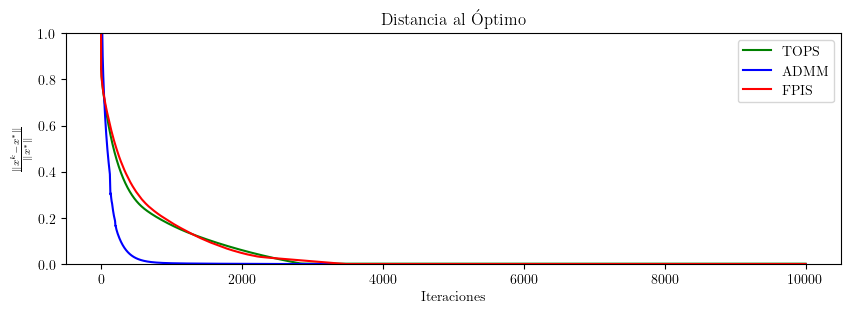

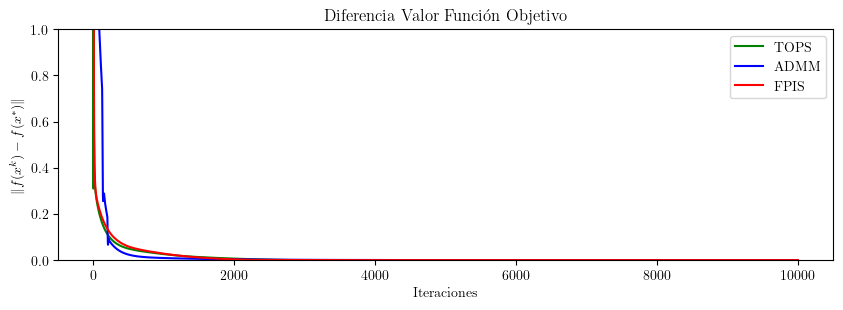

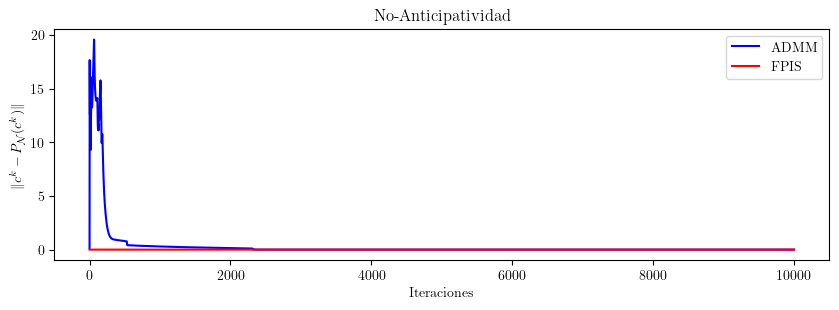

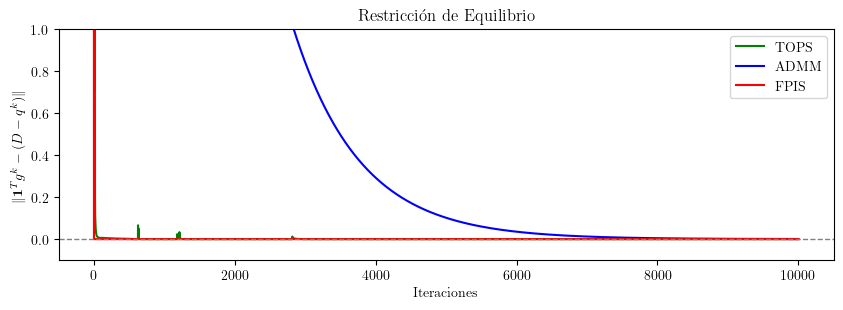

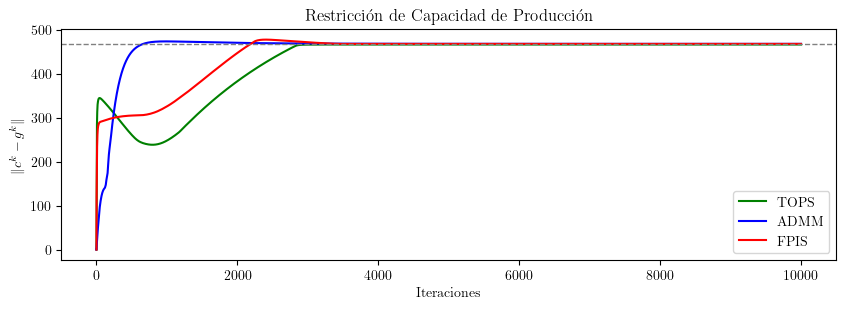

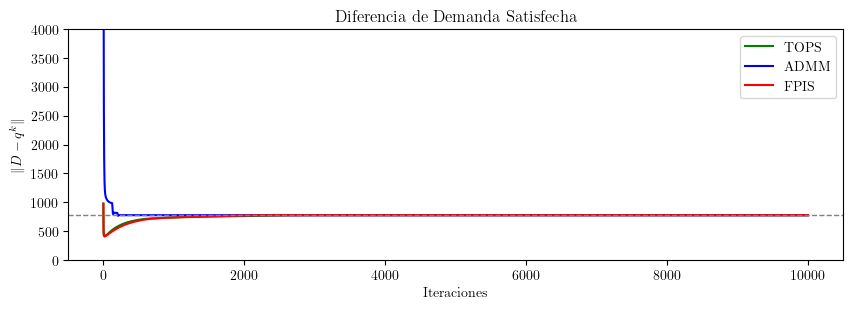

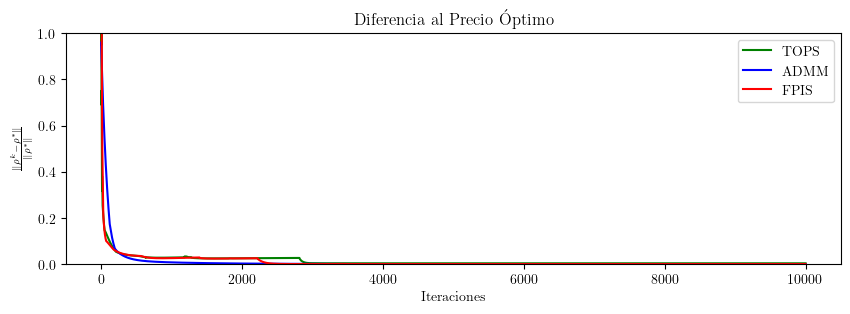

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Crear un rango de iteraciones para las gráficas
k = 0
l = int(max_iters_list / 1) + 1

zero_1 = np.zeros((N,1))
zero_2 = np.zeros((N,M))
zero_3 = np.zeros((1,M))
zeroo = (zero_1, zero_2, zero_3)

# Definir los niveles teóricos según tu solución teórica
nivel_teorico_equilibrio = norm_adjusted((zero_1,zero_2,x2.sum(axis=0) - (D - x3)), zeroo, Sigma)
nivel_teorico_capacidad = norm_adjusted((zero_1,x1 - x2,zero_3), zeroo, Sigma)
nivel_teorico_demanda = norm_adjusted((zero_1,zero_2,D - x3), zeroo, Sigma)

# Variable de sufijo para los nombres de archivo
suffix = "_2"

# Función para configurar y guardar cada gráfico
def configurar_grafico(ax, x_data, y_data, labels, colors, title, y_label, width, height, y_lim=None, nivel_teorico=None):
    for x, y, label, color in zip(x_data, y_data, labels, colors):
        ax.plot(x[k:l], y[k:l], '-', linewidth=1.5, label=label, color=color)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel('Iteraciones')
    ax.legend()
    if y_lim:
        ax.set_ylim(y_lim)
    if nivel_teorico is not None:
        ax.axhline(y=nivel_teorico, color='gray', linestyle='--', linewidth=1)
    ax.figure.set_figwidth(width)
    ax.figure.set_figheight(height)

# Datos para los gráficos
iter_data = [iter_DY, iter_ADMM, iter_BA]
labels = ['TOPS', 'ADMM', 'FPIS']
colors = ['green', 'blue', 'red']

# Definir la altura y el ancho deseado para cada gráfico
width = 10  # Ajusta esta variable según sea necesario
height = 3  # Ajusta esta variable según sea necesario

# Crear y guardar cada figura individualmente
fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [x_DY_sol, x_ADMM_sol, x_BA_sol], labels, colors, 'Distancia al Óptimo', 
                   r'$\frac{\|x^{k} - x^{*}\|}{\|x^{*}\|}$', width, height, y_lim=(0, 1))
plt.savefig(f'images/caso{suffix}/distancia_al_optimo{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [Fx_DY_sol, Fx_ADMM_sol, Fx_BA_sol], labels, colors, 'Diferencia Valor Función Objetivo', 
                   r'$\|f(x^{k})-f(x^{*})\|$', width, height, y_lim=(0, 1))
plt.savefig(f'images/caso{suffix}/diferencia_valor_funcion_objetivo{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data[1:], [Non_anti_DY, Non_anti_ADMM, Non_anti_BA][1:], labels[1:], colors[1:], 'No-Anticipatividad', 
                   r'$\|c^{k}-P_{\mathcal{N}}(c^{k})\|$', width, height)#, y_lim=(0, 25))
plt.savefig(f'images/caso{suffix}/no_anticipatividad{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [equili_DY_solu, equili_ADMM_solu, equili_BA_solu], labels, colors, 'Restricción de Equilibrio', 
                   r'$\|\textbf{1}^{T}g^{k}-(D-q^{k})\|$', width, height, y_lim=(-0.1, 1.0), nivel_teorico=nivel_teorico_equilibrio)
plt.savefig(f'images/caso{suffix}/restriccion_de_equilibrio{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [capacity_DY_solu, capacity_ADMM_solu, capacity_BA_solu], labels, colors, 'Restricción de Capacidad de Producción', 
                   r'$\|c^{k} - g^{k}\|$', width, height, nivel_teorico=nivel_teorico_capacidad)
plt.savefig(f'images/caso{suffix}/restriccion_de_capacidad_de_produccion{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [demand_DY_sol, demand_ADMM_sol, demand_BA_sol], labels, colors, 'Diferencia de Demanda Satisfecha', 
                   r'$\|D-q^{k}\|$', width, height, y_lim=(0, 4000), nivel_teorico=nivel_teorico_demanda)
plt.savefig(f'images/caso{suffix}/diferencia_de_demanda_satisfecha{suffix}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(width, height))
configurar_grafico(ax, iter_data, [dual_DY_sol, dual_ADMM_sol, BA_dual_sol], labels, colors, 'Diferencia al Precio Óptimo', 
                   r'$\frac{\|\rho^{k}-\rho^{*}\|}{\|\rho^{*}\|}$', width, height, y_lim=(0, 1))
plt.savefig(f'images/caso{suffix}/diferencia_al_precio_optimo{suffix}.png', bbox_inches='tight')
plt.show()


In [16]:
Times

{'CP': 0.08461213111877441,
 'DY': 1219.4612152576447,
 'BA': 632.7192559242249,
 'ADMM': 590.8202083110809}

In [17]:
iter_DY[-1], x_DY_sol[-1], Fx_DY_sol[-1], Non_anti_DY[-1], equili_DY_solu[-1], capacity_DY_solu[-1], demand_DY_sol[-1], dual_DY_sol[-1]

(9999,
 0.0018707239259118764,
 3.838783836264409e-05,
 0.0,
 9.76295432314967e-06,
 466.42247034170043,
 777.166041511746,
 0.003523146132476917)

In [18]:
iter_BA[-1], x_BA_sol[-1], Fx_BA_sol[-1], Non_anti_BA[-1], equili_BA_solu[-1], capacity_BA_solu[-1], demand_BA_sol[-1], BA_dual_sol[-1]

(9999,
 0.00034243730719639323,
 1.442964268896573e-06,
 0.0,
 9.75533275911769e-06,
 467.80093622220585,
 777.9293176951296,
 0.00021417750698211665)

In [19]:
iter_ADMM[-1], x_ADMM_sol[-1], Fx_ADMM_sol[-1], Non_anti_ADMM[-1], equili_ADMM_solu[-1], capacity_ADMM_solu[-1], demand_ADMM_sol[-1], dual_ADMM_sol[-1]

(9999,
 2.2936912828630326e-07,
 7.704763134959864e-07,
 1.0528671680236122e-13,
 0.0005252464789091867,
 467.9367410229821,
 778.1024461603864,
 5.447842018551336e-07)

In [20]:
nivel_teorico_equilibrio, nivel_teorico_capacidad, nivel_teorico_demanda

(9.780116885453774e-06, 467.9362565949723, 778.1024461607899)